## Postmodeling Report

This notebook demonstrates how we can use the postmodeling module of triage to dive deeper into the models we have trained. Typically, we do this anaylsis after we do Audition to narrow down the model groups we are interested in. 
Here, we take three models trained to predict the likelihood of near-term homelessness for people who are facing an evictions case to demonstrate how this module can be used. 

We have selected these three models based on the average precision over time:
- 843 Random Forest Model (best performing ML model)
- 850 Best baseline (ranking based on the recency of the most recent homelessness spell)
- 846 



In [1]:
from triage.component.postmodeling.model_analyzer import ModelAnalyzer
from triage.component.postmodeling.report_generator import PostmodelingReport
from triage.component.postmodeling.utils.add_predictions import add_predictions

In [2]:
import pandas as pd
from sqlalchemy import create_engine

### DB Connection

In [3]:
# The connection to the db which has the triage experiment information
engine = create_engine("postgresql:///?service=acdhs_housing")

In [4]:
engine

Engine(postgresql:///?service=acdhs_housing)

### Inputs to the report generator

In [5]:
model_groups=[843, 850, 846]
experiment_hashes = ['651124846d04bc2e431be6fcf97724f5']
project_path = 's3://dsapp-social-services-migrated/acdhs_housing/triage_experiments/' 

### Initializing the report object

In [6]:
rep = PostmodelingReport(engine, model_groups=model_groups, experiment_hashes=experiment_hashes, project_path=project_path)

#### Summary of validation cohort sizes and label base rates

In [11]:
rep.cohort_summary()

   train_end_time  cohort_size  num_positive_labels  label_base_rate
0      2016-04-01         3998                   73         0.018259
1      2016-08-01         4412                   99         0.022439
2      2016-12-01          272                   33         0.121324
3      2017-04-01          251                   25         0.099602
4      2017-08-01         4666                   98         0.021003
5      2017-12-01          299                   33         0.110368
6      2018-04-01          224                   22         0.098214
7      2018-08-01         4284                   92         0.021475
8      2018-12-01          297                   31         0.104377
9      2019-04-01         3872                   72         0.018595
10     2019-08-01         4177                   68         0.016280
11     2019-12-01          307                   22         0.071661
12     2020-04-01         3546                   26         0.007332
13     2020-08-01          262    

### What are the model groups we are analyzing?

In [7]:
model_groups = rep.display_model_groups()

{'model_group_id': 843, 'model_type': 'sklearn.ensemble.RandomForestClassifier', 'hyperparameters': {'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 10000, 'min_samples_leaf': 10, 'min_samples_split': 100}}
{'model_group_id': 846, 'model_type': 'sklearn.dummy.DummyClassifier', 'hyperparameters': {'strategy': 'prior'}}
{'model_group_id': 850, 'model_type': 'triage.component.catwalk.baselines.rankers.BaselineRankMultiFeature', 'hyperparameters': {'rules': [{'feature': 'hl_days_since_entity_id_all_days_since_hl_min', 'low_value_high_score': True}]}}


### Predictions

We need predictions to do most of the following analyses. If the predictions weren't saved to the DB during the experiment, we can use the following function to add predictions of the model groups we care about

In [13]:
add_predictions(
    db_engine=engine, # The database connection
    model_groups=model_groups, # List of model groups  
    project_path=project_path, # where the models and matrices are stored
    rank_order='worst', # How to break ties
    replace=False, # Whether to replace existing predictions
    experiment_hashes=experiment_hashes
)

2023-10-26 17:13:31 -    INFO Scoring 69 model ids
2023-10-26 17:13:31 -    INFO Each model group contains 23 models
2023-10-26 17:13:31 -    INFO Instantiating storage engines and the predictor
2023-10-26 17:13:31 -    INFO Processing 3 model_ids for train matrix 038212d0d3d52cdec318070d458dbb40 and test matrix a92b390da148c3b642315bf747913f2c
2023-10-26 17:13:31 -    INFO file in S3
2023-10-26 17:13:31 -    INFO Found credentials in shared credentials file: ~/.aws/credentials


2023-10-26 17:13:36 -    INFO Writing predictions for model_id 7602
2023-10-26 17:13:36 -    INFO Replace flag not set, looking for old predictions for model id 7602 on test matrix a92b390da148c3b642315bf747913f2c
2023-10-26 17:13:36 -    INFO file in S3
2023-10-26 17:13:39 -    INFO file in S3
2023-10-26 17:13:43 -    INFO file in S3
2023-10-26 17:13:46 -    INFO Found old predictions for model id 7602, matrix a92b390da148c3b642315bf747913f2c, returning saved versions
2023-10-26 17:13:46 -    INFO file in S3
2023-10-26 17:13:49 -    INFO Writing predictions for model_id 7603
2023-10-26 17:13:49 -    INFO Replace flag not set, looking for old predictions for model id 7603 on test matrix a92b390da148c3b642315bf747913f2c
2023-10-26 17:13:49 -    INFO file in S3
2023-10-26 17:13:52 -    INFO file in S3
2023-10-26 17:13:55 -    INFO file in S3
2023-10-26 17:13:58 -    INFO Found old predictions for model id 7603, matrix a92b390da148c3b642315bf747913f2c, returning saved versions
2023-10-26 

## 1. Score distributions


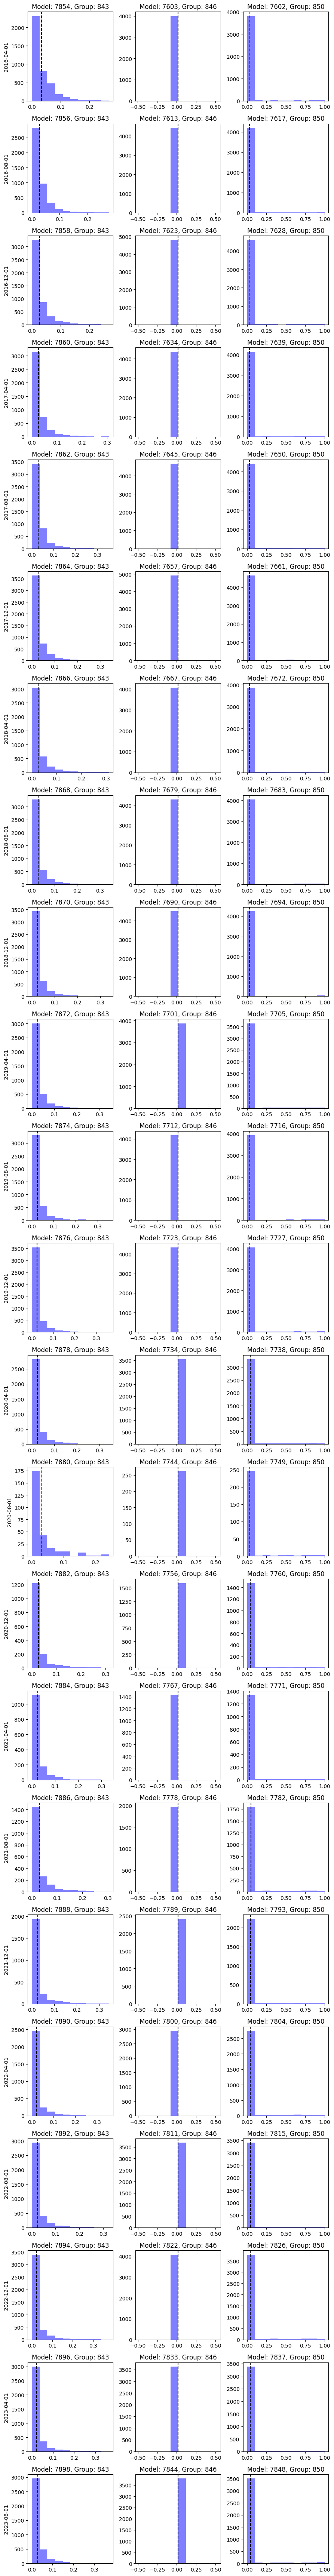

In [9]:
rep.plot_score_distributions()

### 2. PR-k Curves

/mnt/data/users/kasun/code/triage/src/triage/component/postmodeling/model_analyzer.py:839: RuntimeWarning: invalid value encountered in long_scalars
  recall = pred_pos.label_value.sum() / num_positives
/mnt/data/users/kasun/code/triage/src/triage/component/postmodeling/model_analyzer.py:839: RuntimeWarning: invalid value encountered in long_scalars
  recall = pred_pos.label_value.sum() / num_positives
/mnt/data/users/kasun/code/triage/src/triage/component/postmodeling/model_analyzer.py:839: RuntimeWarning: invalid value encountered in long_scalars
  recall = pred_pos.label_value.sum() / num_positives


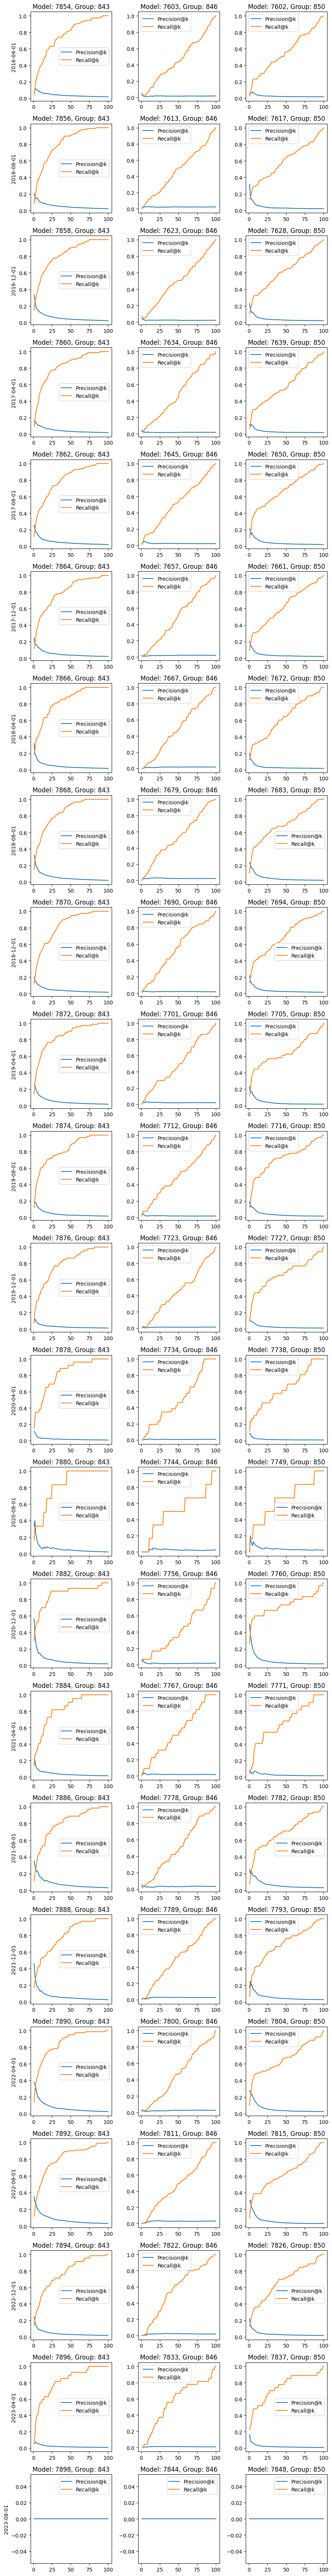

In [10]:
rep.plot_prk_curves()

### 3. Feature Importance

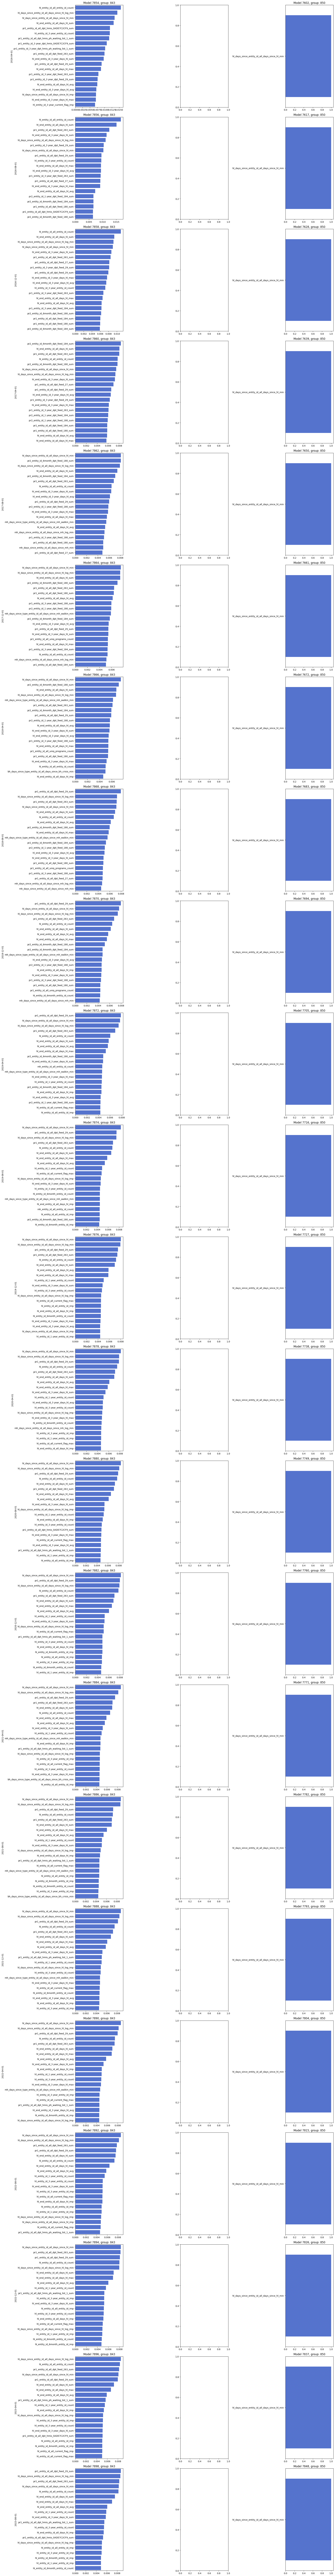

In [12]:
rep.plot_feature_importance()

### 4. Crosstabs

In [21]:
rep.calculate_crosstabs_pos_vs_neg(
    project_path=project_path,
    thresholds={'rank_abs_no_ties': 100},
    table_name='kasun_crosstab_test3',
    return_df=False,
    push_to_db=True,
    replace=False
) 

2023-08-22 20:29:51 -    INFO file in S3
2023-08-22 20:29:55 -    INFO file in S3
2023-08-22 20:29:58 -    INFO file in S3
2023-08-22 20:30:01 -    INFO Crosstabs using threshold: rank_abs_no_ties <= 100
2023-08-22 20:30:02 -    INFO mean_predicted_positive
2023-08-22 20:30:02 -    INFO mean_predicted_negative
2023-08-22 20:30:02 -    INFO std_predicted_positive
2023-08-22 20:30:02 -    INFO std_predicted_negative
2023-08-22 20:30:02 -    INFO mean_ratio
2023-08-22 20:30:02 -    INFO support_predicted_positive
2023-08-22 20:30:02 -    INFO support_predicted_negative
2023-08-22 20:30:02 -    INFO support_pct_predicted_positive
2023-08-22 20:30:02 -    INFO support_pct_predicted_negative
2023-08-22 20:30:02 -    INFO Pushing the results to the DB
2023-08-22 20:30:03 -    INFO file in S3
2023-08-22 20:30:07 -    INFO file in S3
2023-08-22 20:30:11 -    INFO file in S3
2023-08-22 20:30:14 -    INFO Crosstabs using threshold: rank_abs_no_ties <= 100
2023-08-22 20:30:14 -    INFO mean_predic

In [13]:
dfs = rep.display_crosstab_pos_vs_neg(
    threshold_type='rank_abs_no_ties',
    threshold=100,
    table_name='kasun_crosstab_test3',
    project_path=project_path,
    display_n_features=40,
    filter_features=None,
    support_threshold=0.2,
    return_dfs=True,
    show_plots=False
)

In [17]:
for model_id, df in dfs.items():
    print(model_id)
    display(df)

7854


(-)mean     (+)mean  \
feature_name                                                                  
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.000000    0.520000   
age_if_entity_id_all_adult_age_if_imp                  0.229092    0.000000   
pr_end_entity_id_all_program_duratio_imp               0.240636    0.000000   
pr1_entity_id_3 year_uniq_programs_imp                 0.229092    0.000000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    1.120000   
pr1_entity_id_all_uniq_programs_imp                    0.229092    0.000000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.000000    1.040000   
pr1_entity_id_all_dp_imp                               0.229092    0.000000   
pr1_entity_id_3 year_dpt__NULL_sum                     0.261160    0.000000   
pr1_entity_id_all_dpt__NULL_sum                        0.229092    0.000000   
pr1_entity_id_3 year_dp_imp                            0.229092    0.000000   
pr1_entity_id_3 year_current_flag_imp                  0.261160    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.274500    0.000000   
pr1_entity_id_all_current_flag_imp                     0.229092    0.000000   
age_if_entity_id_all_curr_age_imp                      0.245767    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.274500    0.000000   
pr_end_entity_id_all_program_duration_imp              0.240636    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...     0.229092    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...     0.229092    0.000000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.000000    0.520000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.000000    1.040000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.000000    1.120000   
address_entity_id_all_uniq_addresses_count             0.000770    1.530000   
pr_days_since_entity_id_all_days_since_pr_start...  2292.235840    1.687715   
hl_end_entity_id_3 year_days_hl_max                    0.138020  152.029999   
hl_end_entity_id_3 year_days_hl_sum                    0.529759  264.420013   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_2...     0.001283    0.580000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_2_sum       0.001539    0.600000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.002052    0.700000   
pr1_entity_id_all_dpt_hmis_12C6FC06C9_sum              0.001539    0.520000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.003335    0.870000   
mh_end_entity_id_all_event_duration_sum                0.090559   21.969999   
pr1_entity_id_3 year_dpt_feed_33_sum                   0.001796    0.300000   
hl_end_entity_id_all_days_hl_sum                       3.616214  309.519989   
pr1_entity_id_all_dpt_feed_29_sum                      0.015649    1.050000   
pr1_entity_id_all_dpt_feed_263_sum                     0.020267    1.340000   
pr1_entity_id_all_dpt_feed_33_sum                      0.006670    0.440000   
hl_end_entity_id_all_days_hl_max                       3.081580  174.639999   
mh_type_entity_id_3 year_lag_mh_walkin_max             2.408415  128.669998   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.004874    0.260000   

                                                          ratio  (-)supp  \
feature_name                                                               
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum                inf    0.000   
age_if_entity_id_all_adult_age_if_imp                       inf    0.229   
pr_end_entity_id_all_program_duratio_imp                    inf    0.241   
pr1_entity_id_3 year_uniq_programs_imp                      inf    0.229   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...          inf    0.000   
pr1_entity_id_all_uniq_programs_imp                         inf    0.229   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum                inf    0.000   
pr1_entity_id_all_dp_imp                             

7856


(-)mean     (+)mean  \
feature_name                                                                  
pr_days_since_entity_id_all_days_since_pr_start...     0.218228    0.000000   
pr1_entity_id_all_current_flag_imp                     0.218228    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.271336    0.000000   
hl_entity_id_1 year_entity_id_imp                      0.971939    0.000000   
hl_entity_id_3 year_entity_id_imp                      0.971939    0.000000   
hl_entity_id_6month_entity_id_imp                      0.971939    0.000000   
hl_entity_id_all_current_flag_imp                      0.971939    0.000000   
hl_entity_id_all_entity_id_imp                         0.971939    0.000000   
pr1_entity_id_3 year_uniq_programs_imp                 0.218228    0.000000   
pr1_entity_id_3 year_dpt__NULL_sum                     0.265074    0.000000   
age_if_entity_id_all_curr_age_imp                      0.231679    0.000000   
pr1_entity_id_3 year_dp_imp                            0.218228    0.000000   
pr1_entity_id_3 year_current_flag_imp                  0.265074    0.000000   
pr1_entity_id_all_dp_imp                               0.218228    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...     0.218228    0.000000   
pr_end_entity_id_all_program_duration_imp              0.226113    0.000000   
pr_end_entity_id_all_program_duratio_imp               0.226113    0.000000   
pr1_entity_id_all_dpt__NULL_sum                        0.218228    0.000000   
hl_end_entity_id_all_days_hl_imp                       0.969388    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.271336    0.000000   
pr1_entity_id_all_uniq_programs_imp                    0.218228    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.969388    0.000000   
age_if_entity_id_all_adult_age_if_imp                  0.218228    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.969388    0.000000   
hl_end_entity_id_3 year_days_hl_max                    0.034787  157.660004   
hl_days_since_entity_id_all_days_since_hl_log_min   9693.000000    2.640357   
pr_days_since_entity_id_all_days_since_pr_start...  2183.654541    1.727937   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.000696    0.520000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.000696    0.520000   
pr1_entity_id_3 year_dpt_hmis_12C6FC06C9_sum           0.000464    0.270000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.002319    1.230000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.002319    1.230000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.003015    1.530000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.003015    1.530000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_2...     0.000696    0.340000   
pr1_entity_id_3 year_dpt_feed_33_sum                   0.000696    0.330000   
hl_end_entity_id_3 year_days_hl_sum                    0.845779  304.890015   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.003247    1.080000   
pr1_entity_id_3 year_dpt_hmis_BC33EA4E26_sum           0.000696    0.230000   
pr1_entity_id_all_dpt_hmis_BC33EA4E26_sum              0.000696    0.230000   

                                                          ratio  (-)supp  \
feature_name                                                               
pr_days_since_entity_id_all_days_since_pr_start...          inf    0.218   
pr1_entity_id_all_current_flag_imp                          inf    0.218   
pr_end_entity_id_3 year_program_duration_imp                inf    0.271   
hl_entity_id_1 year_entity_id_imp                           inf    0.972   
hl_entity_id_3 year_entity_id_imp                           inf    0.972   
hl_entity_id_6month_entity_id_imp                           inf    0.972   
hl_entity_id_all_current_flag_imp                           inf    0.972   
hl_entity_id_all_entity_id_imp                       

7858


(-)mean     (+)mean  \
feature_name                                                                  
pr1_entity_id_3 year_uniq_programs_imp                 0.201823    0.000000   
pr2_entity_id_1 year_current_flag_imp                  0.279415    0.000000   
age_if_entity_id_all_curr_age_imp                      0.215391    0.000000   
pr2_entity_id_1 year_dpt__NULL_sum                     0.279415    0.000000   
pr1_entity_id_all_dp_imp                               0.201823    0.000000   
pr_end_entity_id_all_program_duration_imp              0.233411    0.000000   
pr_end_entity_id_all_program_duratio_imp               0.233411    0.000000   
pr1_entity_id_all_current_flag_imp                     0.201823    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.275599    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.275599    0.000000   
pr_end_entity_id_1 year_program_duration_imp           0.355099    0.000000   
pr_end_entity_id_1 year_program_duratio_imp            0.355099    0.000000   
pr2_entity_id_1 year_uniq_programs_imp                 0.279415    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...     0.201823    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...     0.201823    0.000000   
pr2_entity_id_6month_uniq_programs_imp                 0.279415    0.000000   
pr2_entity_id_6month_dp_imp                            0.279415    0.000000   
age_if_entity_id_all_adult_age_if_imp                  0.201823    0.000000   
pr2_entity_id_1 year_dp_imp                            0.279415    0.000000   
pr1_entity_id_all_uniq_programs_imp                    0.201823    0.000000   
pr1_entity_id_3 year_current_flag_imp                  0.232987    0.000000   
pr1_entity_id_3 year_dp_imp                            0.201823    0.000000   
pr1_entity_id_3 year_dpt__NULL_sum                     0.232987    0.000000   
pr1_entity_id_all_dpt__NULL_sum                        0.201823    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...  2019.509033    1.644832   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.000424    0.450000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.001272    1.210000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.000848    0.480000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.002332    1.270000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.002544    1.380000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.003816    1.450000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.002544    0.790000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.005300    0.840000   
phys_end_entity_id_all_ph_duration_avg                 0.006521    1.002690   
phys_end_entity_id_3 year_ph_duration_avg              0.006521    1.002690   
bh_end_entity_id_6month_event_duration_min             1.130592    0.010000   
mh_entity_id_1 year_event_type_MH CRISIS WALK-I...     0.009964    0.890000   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.032860    2.630000   
mh_type_entity_id_3 year_lag_mh_walkin_max             3.097096  235.639999   
pr1_entity_id_all_dpt_feed_29_sum                      0.017172    1.270000   

                                                          ratio  (-)supp  \
feature_name                                                               
pr1_entity_id_3 year_uniq_programs_imp                      inf    0.202   
pr2_entity_id_1 year_current_flag_imp                       inf    0.279   
age_if_entity_id_all_curr_age_imp                           inf    0.215   
pr2_entity_id_1 year_dpt__NULL_sum                          inf    0.279   
pr1_entity_id_all_dp_imp                                    inf    0.202   
pr_end_entity_id_all_program_duration_imp                   inf    0.233   
pr_end_entity_id_all_program_duratio_imp                    inf    0.233   
pr1_entity_id_all_current_flag_imp                   

7860


(-)mean     (+)mean  \
feature_name                                                                  
pr1_entity_id_all_uniq_programs_imp                    0.200611    0.000000   
pr_end_entity_id_all_program_duratio_imp               0.231185    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.270931    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.270931    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...     0.200611    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...     0.200611    0.000000   
pr1_entity_id_3 year_current_flag_imp                  0.228363    0.000000   
pr1_entity_id_3 year_dp_imp                            0.200611    0.000000   
pr1_entity_id_3 year_dpt__NULL_sum                     0.228363    0.000000   
age_if_entity_id_all_curr_age_imp                      0.217074    0.000000   
age_if_entity_id_all_adult_age_if_imp                  0.200611    0.000000   
pr_end_entity_id_all_program_duration_imp              0.231185    0.000000   
pr1_entity_id_all_current_flag_imp                     0.200611    0.000000   
pr1_entity_id_all_dpt__NULL_sum                        0.200611    0.000000   
pr1_entity_id_all_dp_imp                               0.200611    0.000000   
pr1_entity_id_3 year_uniq_programs_imp                 0.200611    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...  2007.467529    1.656814   
mh_entity_id_1 year_event_type_MH CRISIS WALK-I...     0.003998    1.140000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.003528    0.660000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.003998    0.740000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.003763    0.620000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.001881    0.250000   
bh_entity_id_1 year_event_type_MH CRISIS_sum           0.015287    2.020000   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.020226    2.530000   
bh_entity_id_6month_event_type_MH CRISIS_sum           0.009878    1.180000   
bh_entity_id_1 year_diagnosis_category_code_F99...     0.014817    1.520000   
bh_entity_id_6month_diagnosis_category_code_F99...     0.008702    0.840000   
bh_entity_id_3 year_diagnosis_category_code_F99...     0.021402    2.050000   
bh_entity_id_all_diagnosis_category_code_F99_sum       0.021402    2.050000   
eviction_days_since_entity_id_all_days_since_ev...   154.495056    1.662320   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.008467    0.760000   
mh_entity_id_all_event_type_MH CRISIS RESIDENTI...     0.004704    0.420000   
mh_type_entity_id_3 year_lag_mh_walkin_max             2.007996  170.630005   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.010583    0.890000   
pr2_entity_id_1 year_dpt_feed_292_sum                  0.003763    0.300000   
bh_type_entity_id_6month_lag_bh_crisis_max             2.152399  164.570007   
pr1_entity_id_all_dpt_feed_290_sum                     0.004704    0.350000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.010348    0.750000   
mh_end_entity_id_all_event_duration_sum                0.336312   22.850000   
mh_type_entity_id_3 year_lag_mh_walkin_avg             1.293945   83.457512   

                                                          ratio  (-)supp  \
feature_name                                                               
pr1_entity_id_all_uniq_programs_imp                         inf    0.201   
pr_end_entity_id_all_program_duratio_imp                    inf    0.231   
pr_end_entity_id_3 year_program_duration_imp                inf    0.271   
pr_end_entity_id_3 year_program_duratio_imp                 inf    0.271   
pr_days_since_entity_id_all_days_since_pr_start...          inf    0.201   
pr_days_since_entity_id_all_days_since_pr_start...          inf    0.201   
pr1_entity_id_3 year_current_flag_imp                       inf    0.228   
pr1_entity_id_3 year_dp_imp                          

7862


(-)mean     (+)mean  \
feature_name                                                                  
pr2_entity_id_1 year_current_flag_imp                  0.241787    0.000000   
pr_end_entity_id_all_program_duration_imp              0.217477    0.000000   
pr2_entity_id_1 year_dp_imp                            0.241787    0.000000   
pr2_entity_id_1 year_dpt_feed_29_sum                   0.000000    0.220000   
pr2_entity_id_1 year_dpt_hmis_0ADE7C2CF9_sum           0.000000    0.240000   
pr2_entity_id_1 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.260000   
pr2_entity_id_1 year_uniq_programs_imp                 0.241787    0.000000   
pr2_entity_id_6month_dp_imp                            0.241787    0.000000   
pr2_entity_id_6month_uniq_programs_imp                 0.241787    0.000000   
pr_end_entity_id_1 year_program_duratio_imp            0.340123    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.258870    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.258870    0.000000   
pr_end_entity_id_all_program_duratio_imp               0.217477    0.000000   
pr_end_entity_id_1 year_program_duration_imp           0.340123    0.000000   
pr2_entity_id_1 year_dpt__NULL_sum                     0.241787    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...  1764.449951    1.665565   
pr2_entity_id_1 year_dpt_feed_263_sum                  0.000219    0.230000   
mh_entity_id_1 year_event_type_MH CRISIS WALK-I...     0.003066    1.630000   
mh_entity_id_6month_event_type_MH CRISIS WALK-I...     0.001533    0.710000   
bh_entity_id_6month_event_type_MH CRISIS_sum           0.007446    1.360000   
bh_entity_id_1 year_event_type_MH CRISIS_sum           0.015988    2.710000   
pr2_entity_id_6month_dpt_feed_292_sum                  0.001533    0.250000   
bh_entity_id_1 year_diagnosis_category_code_F99...     0.013141    2.060000   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.025405    3.900000   
bh_type_entity_id_6month_lag_bh_crisis_max             1.661191  234.830002   
mh_end_entity_id_all_event_duration_sum                0.261498   35.389999   
bh_entity_id_6month_diagnosis_category_code_F99...     0.007446    0.970000   
pr2_entity_id_1 year_dpt_feed_292_sum                  0.003066    0.390000   
mh_type_entity_id_1 year_lag_mh_phone_max              1.084319  133.490005   
bh_entity_id_3 year_diagnosis_category_code_F99...     0.026719    3.250000   
bh_entity_id_all_diagnosis_category_code_F99_sum       0.026719    3.250000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.007227    0.790000   
mh_type_entity_id_1 year_lag_mh_phone_avg              1.045335  112.232834   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.004161    0.410000   
mh_type_entity_id_1 year_lag_mh_phone_min              1.006351   95.400002   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.008103    0.760000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.010293    0.940000   
bh_entity_id_3 year_event_type_MH CRISIS_sum           0.076216    6.270000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.007446    0.590000   
eviction_days_since_entity_id_all_days_since_ev...   104.546951    1.633096   

                                                          ratio  (-)supp  \
feature_name                                                               
pr2_entity_id_1 year_current_flag_imp                       inf    0.242   
pr_end_entity_id_all_program_duration_imp                   inf    0.217   
pr2_entity_id_1 year_dp_imp                                 inf    0.242   
pr2_entity_id_1 year_dpt_feed_29_sum                        inf    0.000   
pr2_entity_id_1 year_dpt_hmis_0ADE7C2CF9_sum                inf    0.000   
pr2_entity_id_1 year_dpt_hmis_ph_waiting_list_1...          inf    0.000   
pr2_entity_id_1 year_uniq_programs_imp                      inf    0.242   
pr2_entity_id_6month_dp_imp                          

7864


(-)mean     (+)mean  \
feature_name                                                                  
pr_end_entity_id_1 year_program_duratio_imp            0.324246    0.000000   
pr_end_entity_id_1 year_program_duration_imp           0.324246    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.243080    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.243080    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...  1685.137207    1.629857   
mh_end_entity_id_all_event_duration_sum                0.152549   35.869999   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.002081    0.340000   
mh_entity_id_6month_event_type_MH CRISIS WALK-I...     0.005827    0.920000   
mh_entity_id_1 year_event_type_MH CRISIS WALK-I...     0.009365    1.350000   
mh_entity_id_3 year_event_type_MH CRISIS RESIDE...     0.002706    0.370000   
bh_type_entity_id_6month_lag_bh_crisis_max             2.024350  259.450012   
bh_entity_id_6month_event_type_MH CRISIS_sum           0.014152    1.720000   
state_pr_entity_id_3 year_current_flag_max             0.006035    0.690000   
bh_entity_id_1 year_event_type_MH CRISIS_sum           0.024766    2.750000   
pr1_entity_id_3 year_dpt_feed_290_sum                  0.002706    0.300000   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.027888    3.040000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.005827    0.630000   
bh_entity_id_6month_diagnosis_category_code_F99...     0.013528    1.280000   
mh_type_entity_id_1 year_lag_mh_walkin_max             2.145682  194.509995   
mh_type_entity_id_1 year_lag_mh_mobile_max             1.766493  157.339996   
pr2_entity_id_6month_dpt_feed_292_sum                  0.003746    0.310000   
bh_type_entity_id_1 year_lag_bh_crisis_max             4.320499  338.230011   
mh_entity_id_1 year_event_type_MH EMERGENCY_sum        0.004370    0.340000   
bh_entity_id_1 year_diagnosis_category_code_F99...     0.022893    1.750000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.009365    0.710000   
mh_type_entity_id_3 year_lag_mh_walkin_max             4.177732  315.769989   
bh_entity_id_1 year_event_type_MH EMERGENCY_sum        0.004370    0.330000   
mh_type_entity_id_1 year_lag_mh_mobile_avg             1.756608  132.006653   
pr2_entity_id_1 year_dpt_feed_292_sum                  0.006035    0.450000   
eviction_days_since_entity_id_all_days_since_ev...   128.617538    1.741948   
bh_entity_id_3 year_event_type_MH CRISIS_sum           0.078668    5.560000   
bh_entity_id_3 year_diagnosis_category_code_F32...     0.014152    0.980000   
bh_entity_id_all_diagnosis_category_code_F32_sum       0.014152    0.980000   
mh_entity_id_all_event_type_MH CRISIS RESIDENTI...     0.009573    0.640000   
mh_type_entity_id_1 year_lag_mh_walkin_avg             1.623968  107.199333   
mh_type_entity_id_3 year_lag_mh_phone_min              2.542352  166.850006   
bh_entity_id_3 year_diagnosis_category_code_F99...     0.043496    2.840000   
bh_entity_id_all_diagnosis_category_code_F99_sum       0.043496    2.840000   
mh_entity_id_6month_event_type_MH CRISIS TELEPH...     0.005827    0.380000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.014568    0.950000   

                                                          ratio  (-)supp  \
feature_name                                                               
pr_end_entity_id_1 year_program_duratio_imp                 inf    0.324   
pr_end_entity_id_1 year_program_duration_imp                inf    0.324   
pr_end_entity_id_3 year_program_duratio_imp                 inf    0.243   
pr_end_entity_id_3 year_program_duration_imp                inf    0.243   
pr_days_since_entity_id_all_days_since_pr_start...  1033.916992    1.000   
mh_end_entity_id_all_event_duration_sum              235.136887    0.108   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum         163.369995    0.002   
mh_entity_id_6month_event_type_MH CRISIS WALK-I...   

7866


(-)mean     (+)mean  \
feature_name                                                                  
pr1_entity_id_3 year_dpt__NULL_sum                     0.201765    0.000000   
pr2_entity_id_1 year_current_flag_imp                  0.290290    0.000000   
pr2_entity_id_1 year_dp_imp                            0.290290    0.000000   
pr2_entity_id_1 year_dpt__NULL_sum                     0.290290    0.000000   
pr2_entity_id_1 year_uniq_programs_imp                 0.290290    0.000000   
pr2_entity_id_6month_dp_imp                            0.290290    0.000000   
pr2_entity_id_6month_uniq_programs_imp                 0.290290    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.244893    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.244893    0.000000   
pr1_entity_id_3 year_current_flag_imp                  0.201765    0.000000   
pr_end_entity_id_all_program_duratio_imp               0.205044    0.000000   
pr_end_entity_id_all_program_duration_imp              0.205044    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...  1756.840698    1.655956   
state_pr_entity_id_3 year_current_flag_max             0.001765    0.770000   
mh_type_entity_id_3 year_lag_mh_walkin_max             0.690542  217.929993   
mh_type_entity_id_3 year_lag_mh_walkin_avg             0.496256  108.658020   
mh_end_entity_id_all_event_duration_sum                0.181841   35.150002   
mh_type_entity_id_3 year_lag_mh_walkin_min             0.437831   79.680000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.004792    0.650000   
hl_end_entity_id_3 year_days_hl_min                    0.257251   29.559999   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.004288    0.460000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.007314    0.780000   
hl_end_entity_id_3 year_days_hl_avg                    0.550462   57.225330   
hl_end_entity_id_3 year_days_hl_max                    0.893569   88.580002   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.011602    1.050000   
hl_end_entity_id_3 year_days_hl_sum                    2.092812  180.460007   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.006557    0.560000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.007314    0.600000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.015637    1.200000   
eviction_days_since_entity_id_all_days_since_ev...   107.602501    1.667538   
mh_type_entity_id_all_lag_mh_walkin_max                5.825725  360.140015   
bh_type_entity_id_1 year_lag_bh_crisis_max             4.637074  285.160004   
bh_dx_entity_id_all_lag_bh_311_min                     2.842875  167.820007   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.037831    2.230000   
bh_entity_id_6month_diagnosis_category_code_F99...     0.012610    0.680000   
bh_entity_id_6month_event_type_MH CRISIS_sum           0.015385    0.810000   
bh_entity_id_1 year_diagnosis_category_code_F99...     0.019924    1.030000   
mh_entity_id_all_event_type_MH CRISIS RESIDENTI...     0.010845    0.560000   
pr1_entity_id_3 year_dpt_feed_292_sum                  0.013367    0.670000   
bh_dx_entity_id_all_lag_bh_311_avg                     3.836200  191.901718   

                                                          ratio  (-)supp  \
feature_name                                                               
pr1_entity_id_3 year_dpt__NULL_sum                          inf    0.202   
pr2_entity_id_1 year_current_flag_imp                       inf    0.290   
pr2_entity_id_1 year_dp_imp                                 inf    0.290   
pr2_entity_id_1 year_dpt__NULL_sum                          inf    0.290   
pr2_entity_id_1 year_uniq_programs_imp                      inf    0.290   
pr2_entity_id_6month_dp_imp                                 inf    0.290   
pr2_entity_id_6month_uniq_programs_imp                      inf    0.290   
pr_end_entity_id_3 year_program_duratio_imp          

7868


(-)mean     (+)mean  \
feature_name                                                                  
pr_end_entity_id_3 year_program_duration_imp           0.234226    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.234226    0.000000   
address_days_since_entity_id_all_days_since_eff...  1640.668701    1.377238   
bh_entity_id_all_entity_id_count                       0.026769   25.740000   
pr_days_since_entity_id_all_days_since_pr_start...  1590.917725    1.659084   
bh_dx_entity_id_1 year_lag_bh_F99_max                  0.121415  115.089996   
bh_dx_entity_id_3 year_lag_bh_F99_avg                  0.074956   57.347431   
bh_dx_entity_id_all_lag_bh_F99_avg                     0.074956   57.347431   
mh_entity_id_6month_event_type_MH CRISIS WALK-I...     0.002390    0.690000   
mh_end_entity_id_all_event_duration_sum                0.327438   59.490002   
mh_entity_id_1 year_event_type_MH CRISIS WALK-I...     0.007648    1.340000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.003346    0.560000   
mh_type_entity_id_3 year_lag_mh_walkin_max             2.599904  430.850006   
bh_dx_entity_id_3 year_lag_bh_F99_max                  0.844646  125.190002   
bh_dx_entity_id_all_lag_bh_F99_max                     0.844646  125.190002   
mh_type_entity_id_all_lag_mh_walkin_max                4.771749  633.900024   
mh_type_entity_id_all_lag_mh_walkin_min                0.816205  103.300003   
mh_type_entity_id_3 year_lag_mh_walkin_avg             1.805116  213.115112   
mh_entity_id_all_event_type_MH CRISIS WALK-IN_sum      0.096080   10.540000   
bh_entity_id_6month_event_type_MH CRISIS_sum           0.013862    1.500000   
hl_end_entity_id_3 year_days_hl_min                    0.219885   23.480000   
bh_entity_id_1 year_event_type_MH CRISIS_sum           0.025813    2.730000   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.034895    3.650000   
mh_type_entity_id_all_lag_mh_walkin_avg                2.134595  215.960251   
bh_dx_entity_id_all_lag_bh_296_max                     4.398423  438.000000   
pr2_entity_id_6month_dpt_feed_292_sum                  0.002151    0.210000   
mh_type_entity_id_3 year_lag_mh_walkin_min             1.485421  144.350006   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.009560    0.890000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.010038    0.910000   
pr1_entity_id_3 year_dpt_feed_290_sum                  0.003107    0.280000   
mh_entity_id_3 year_event_type_MH CRISIS RESIDE...     0.003585    0.320000   
bh_dx_entity_id_all_lag_bh_296_min                     2.847514  253.009995   
mh_entity_id_all_event_type_MH CRISIS RESIDENTI...     0.009799    0.860000   
bh_entity_id_6month_diagnosis_category_code_F99...     0.011950    1.030000   
bh_dx_entity_id_all_lag_bh_296_avg                     3.575980  307.649658   
pr1_entity_id_all_dpt_feed_290_sum                     0.009082    0.760000   
pr2_entity_id_1 year_dpt_feed_292_sum                  0.005258    0.420000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.012189    0.970000   
bh_entity_id_1 year_diagnosis_category_code_F99...     0.022945    1.780000   
eviction_days_since_entity_id_all_days_since_ev...   128.289093    1.694873   

                                                          ratio  (-)supp  \
feature_name                                                               
pr_end_entity_id_3 year_program_duration_imp                inf    0.234   
pr_end_entity_id_3 year_program_duratio_imp                 inf    0.234   
address_days_since_entity_id_all_days_since_eff...  1191.274414    0.998   
bh_entity_id_all_entity_id_count                     961.572876    0.206   
pr_days_since_entity_id_all_days_since_pr_start...   958.913391    1.000   
bh_dx_entity_id_1 year_lag_bh_F99_max                947.906555    0.005   
bh_dx_entity_id_3 year_lag_bh_F99_avg                765.079224    0.012   
bh_dx_entity_id_all_lag_bh_F99_avg                   

7870


(-)mean     (+)mean  \
feature_name                                                                  
state_pr_entity_id_all_uniq_programs_imp               0.300342    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.300342    0.000000   
pr2_entity_id_1 year_dp_imp                            0.279818    0.000000   
pr2_entity_id_1 year_dpt__NULL_sum                     0.279818    0.000000   
pr2_entity_id_1 year_uniq_programs_imp                 0.279818    0.000000   
pr2_entity_id_6month_dp_imp                            0.279818    0.000000   
pr2_entity_id_6month_uniq_programs_imp                 0.279818    0.000000   
pr_end_entity_id_1 year_program_duratio_imp            0.292132    0.000000   
pr_end_entity_id_1 year_program_duration_imp           0.292132    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.215507    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.215507    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.300342    0.000000   
state_pr_entity_id_1 year_category_imp                 0.300342    0.000000   
state_pr_entity_id_1 year_uniq_programs_imp            0.300342    0.000000   
state_pr_entity_id_3 year_category_imp                 0.300342    0.000000   
state_pr_entity_id_3 year_uniq_programs_imp            0.300342    0.000000   
state_pr_entity_id_6month_category_imp                 0.300342    0.000000   
state_pr_entity_id_6month_uniq_programs_imp            0.300342    0.000000   
state_pr_entity_id_all_category__NULL_sum              0.300342    0.000000   
state_pr_entity_id_all_category_imp                    0.300342    0.000000   
state_pr_entity_id_all_current_flag_imp                0.300342    0.000000   
pr2_entity_id_1 year_current_flag_imp                  0.279818    0.000000   
pr2_entity_id_6month_current_flag_max                  0.000228    0.580000   
bh_entity_id_all_entity_id_count                       0.007298   15.950000   
address_days_since_entity_id_all_days_since_eff...  1565.267700    0.983216   
state_pr_days_since_entity_id_all_days_since_el...  3004.549561    1.925797   
pr_days_since_entity_id_all_days_since_pr_start...  1497.577637    1.693824   
mh_type_entity_id_3 year_lag_mh_walkin_min             0.601140  161.690002   
mh_type_entity_id_3 year_lag_mh_walkin_avg             0.912048  212.424881   
mh_type_entity_id_3 year_lag_mh_walkin_max             1.572634  327.239990   
mh_entity_id_3 year_event_type_MH CRISIS RESIDE...     0.001824    0.320000   
bh_dx_entity_id_all_lag_bh_F99_avg                     0.253495   43.486645   
bh_dx_entity_id_3 year_lag_bh_F99_avg                  0.261591   44.480644   
bh_dx_entity_id_3 year_lag_bh_F99_max                  0.755074  101.709999   
bh_dx_entity_id_all_lag_bh_F99_max                     0.755986  101.739998   
mh_entity_id_6month_event_type_MH CRISIS WALK-I...     0.004333    0.540000   
mh_end_entity_id_all_event_duration_sum                0.320182   38.450001   
pr2_entity_id_6month_dpt_feed_292_sum                  0.002281    0.270000   
mh_type_entity_id_1 year_lag_mh_inpatient_min          3.677537  413.809998   
mh_entity_id_1 year_event_type_MH CRISIS WALK-I...     0.006842    0.760000   

                                                          ratio  (-)supp  \
feature_name                                                               
state_pr_entity_id_all_uniq_programs_imp                    inf    0.300   
state_pr_days_since_entity_id_all_days_since_el...          inf    0.300   
pr2_entity_id_1 year_dp_imp                                 inf    0.280   
pr2_entity_id_1 year_dpt__NULL_sum                          inf    0.280   
pr2_entity_id_1 year_uniq_programs_imp                      inf    0.280   
pr2_entity_id_6month_dp_imp                                 inf    0.280   
pr2_entity_id_6month_uniq_programs_imp                      inf    0.280   
pr_end_entity_id_1 year_program_duratio_imp          

7872


(-)mean     (+)mean  \
feature_name                                                                  
state_pr_entity_id_all_uniq_programs_imp               0.308059    0.000000   
state_pr_entity_id_1 year_category_imp                 0.308059    0.000000   
pr_end_entity_id_1 year_program_duratio_imp            0.304613    0.000000   
pr_end_entity_id_1 year_program_duration_imp           0.304613    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.220042    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.220042    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.308059    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.308059    0.000000   
state_pr_end_entity_id_3 year_event_duratio_imp        0.378579    0.000000   
state_pr_end_entity_id_3 year_event_duration_imp       0.378579    0.000000   
state_pr_end_entity_id_all_event_duratio_imp           0.325822    0.000000   
state_pr_end_entity_id_all_event_duration_imp          0.325822    0.000000   
state_pr_entity_id_1 year_uniq_programs_imp            0.308059    0.000000   
state_pr_entity_id_3 year_category__NULL_sum           0.363468    0.000000   
state_pr_entity_id_3 year_category_imp                 0.308059    0.000000   
state_pr_entity_id_3 year_current_flag_imp             0.363468    0.000000   
state_pr_entity_id_3 year_uniq_programs_imp            0.308059    0.000000   
state_pr_entity_id_6month_category_imp                 0.308059    0.000000   
state_pr_entity_id_6month_uniq_programs_imp            0.308059    0.000000   
state_pr_entity_id_all_category__NULL_sum              0.308059    0.000000   
state_pr_entity_id_all_category_imp                    0.308059    0.000000   
state_pr_entity_id_all_current_flag_imp                0.308059    0.000000   
hl_end_entity_id_3 year_days_hl_min                    0.000530   20.870001   
state_pr_days_since_entity_id_all_days_since_el...  3081.680420    1.867327   
bh_entity_id_all_entity_id_count                       0.011135   15.400000   
pr_days_since_entity_id_all_days_since_pr_start...  1557.753418    1.699662   
address_days_since_entity_id_all_days_since_eff...   867.868774    1.099150   
mh_end_entity_id_all_event_duration_sum                0.136797   33.029999   
bh_dx_entity_id_3 year_lag_bh_F99_max                  0.414899   98.870003   
bh_dx_entity_id_all_lag_bh_F99_max                     0.418346   99.250000   
mh_entity_id_1 year_event_type_MH CRISIS WALK-I...     0.004507    1.030000   
mh_type_entity_id_3 year_lag_mh_walkin_avg             0.954581  161.566696   
mh_type_entity_id_3 year_lag_mh_walkin_min             0.653765  104.750000   
mh_type_entity_id_3 year_lag_mh_walkin_max             1.828738  288.709991   
pr1_entity_id_all_dpt_feed_290_sum                     0.005567    0.610000   
bh_entity_id_1 year_event_type_MH CRISIS_sum           0.017497    1.870000   
pr1_entity_id_3 year_dpt_feed_290_sum                  0.002651    0.280000   
mh_entity_id_all_event_type_MH CRISIS RESIDENTI...     0.006628    0.690000   
pr2_entity_id_1 year_dpt_feed_292_sum                  0.002916    0.250000   
eviction_days_since_entity_id_all_days_since_ev...   142.174957    1.682320   

                                                           ratio  (-)supp  \
feature_name                                                                
state_pr_entity_id_all_uniq_programs_imp                     inf    0.308   
state_pr_entity_id_1 year_category_imp                       inf    0.308   
pr_end_entity_id_1 year_program_duratio_imp                  inf    0.305   
pr_end_entity_id_1 year_program_duration_imp                 inf    0.305   
pr_end_entity_id_3 year_program_duratio_imp                  inf    0.220   
pr_end_entity_id_3 year_program_duration_imp                 inf    0.220   
state_pr_days_since_entity_id_all_days_since_el...           inf    0.308   
state_pr_days_since_entity_id_all_days_since

7874


(-)mean     (+)mean  \
feature_name                                                                  
state_pr_entity_id_all_uniq_programs_imp               0.315919    0.000000   
state_pr_entity_id_1 year_uniq_programs_imp            0.315919    0.000000   
pr_end_entity_id_1 year_program_duration_imp           0.322296    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.235713    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.235713    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.315919    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.315919    0.000000   
state_pr_end_entity_id_all_event_duratio_imp           0.332843    0.000000   
state_pr_end_entity_id_all_event_duration_imp          0.332843    0.000000   
state_pr_entity_id_1 year_category_imp                 0.315919    0.000000   
state_pr_entity_id_3 year_category_imp                 0.315919    0.000000   
state_pr_entity_id_3 year_uniq_programs_imp            0.315919    0.000000   
state_pr_entity_id_6month_category_imp                 0.315919    0.000000   
state_pr_entity_id_6month_uniq_programs_imp            0.315919    0.000000   
state_pr_entity_id_all_category__NULL_sum              0.315919    0.000000   
state_pr_entity_id_all_category_imp                    0.315919    0.000000   
state_pr_entity_id_all_current_flag_imp                0.315919    0.000000   
pr_end_entity_id_1 year_program_duratio_imp            0.322296    0.000000   
state_pr_days_since_entity_id_all_days_since_el...  3160.276123    1.935344   
pr_days_since_entity_id_all_days_since_pr_start...  1586.039917    1.641189   
address_days_since_entity_id_all_days_since_eff...   857.299377    1.267553   
bh_entity_id_all_entity_id_count                       0.052735   22.059999   
bh_dx_entity_id_1 year_lag_bh_F99_min                  0.041452   16.770000   
mh_type_entity_id_3 year_lag_mh_walkin_max             1.134903  354.010010   
bh_type_entity_id_6month_lag_bh_crisis_max             0.757910  214.649994   
bh_type_entity_id_6month_lag_bh_crisis_min             0.461369  130.070007   
bh_type_entity_id_6month_lag_bh_crisis_avg             0.610375  156.995300   
bh_dx_entity_id_1 year_lag_bh_F99_max                  0.361786   87.709999   
bh_dx_entity_id_1 year_lag_bh_F99_avg                  0.185439   41.034924   
mh_type_entity_id_3 year_lag_mh_walkin_avg             0.790274  166.353745   
mh_entity_id_1 year_event_type_MH CRISIS WALK-I...     0.007113    1.300000   
mh_type_entity_id_3 year_lag_mh_walkin_min             0.447388   80.790001   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.003189    0.530000   
mh_end_entity_id_all_event_duration_sum                0.284768   44.029999   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.026981    3.670000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.008339    0.990000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.008830    1.000000   
mh_entity_id_all_event_type_MH CRISIS RESIDENTI...     0.008339    0.860000   
bh_dx_entity_id_3 year_lag_bh_F99_max                  1.353937  139.440002   
hl_end_entity_id_3 year_days_hl_min                    0.271768   27.840000   

                                                          ratio  (-)supp  \
feature_name                                                               
state_pr_entity_id_all_uniq_programs_imp                    inf    0.316   
state_pr_entity_id_1 year_uniq_programs_imp                 inf    0.316   
pr_end_entity_id_1 year_program_duration_imp                inf    0.322   
pr_end_entity_id_3 year_program_duratio_imp                 inf    0.236   
pr_end_entity_id_3 year_program_duration_imp                inf    0.236   
state_pr_days_since_entity_id_all_days_since_el...          inf    0.316   
state_pr_days_since_entity_id_all_days_since_el...          inf    0.316   
state_pr_end_entity_id_all_event_duratio_imp         

7876


(-)mean     (+)mean  \
feature_name                                                                  
state_pr_entity_id_all_uniq_programs_imp               0.299127    0.000000   
pr_end_entity_id_1 year_program_duratio_imp            0.309271    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.216796    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.216796    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.299127    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.299127    0.000000   
state_pr_end_entity_id_all_event_duratio_imp           0.317056    0.000000   
state_pr_end_entity_id_all_event_duration_imp          0.317056    0.000000   
state_pr_entity_id_1 year_category_imp                 0.299127    0.000000   
state_pr_entity_id_1 year_uniq_programs_imp            0.299127    0.000000   
state_pr_entity_id_3 year_category_imp                 0.299127    0.000000   
state_pr_entity_id_3 year_uniq_programs_imp            0.299127    0.000000   
state_pr_entity_id_6month_category_imp                 0.299127    0.000000   
state_pr_entity_id_6month_uniq_programs_imp            0.299127    0.000000   
state_pr_entity_id_all_category__NULL_sum              0.299127    0.000000   
state_pr_entity_id_all_category_imp                    0.299127    0.000000   
state_pr_entity_id_all_current_flag_imp                0.299127    0.000000   
pr_end_entity_id_1 year_program_duration_imp           0.309271    0.000000   
state_pr_days_since_entity_id_all_days_since_el...  2992.431152    2.027633   
address_days_since_entity_id_all_days_since_eff...   850.247070    0.947199   
pr_days_since_entity_id_all_days_since_pr_start...  1504.290771    1.720962   
hl_end_entity_id_3 year_days_hl_avg                    0.202408   56.899639   
bh_entity_id_all_entity_id_count                       0.096249   20.879999   
mh_type_entity_id_3 year_lag_mh_walkin_max             2.066289  372.250000   
mh_type_entity_id_3 year_lag_mh_walkin_avg             1.111466  192.342468   
mh_end_entity_id_6month_event_duration_avg             0.950755    0.005737   
mh_type_entity_id_3 year_lag_mh_walkin_min             0.696391  111.970001   
mh_end_entity_id_all_event_duration_sum                0.340410   51.000000   
hl_end_entity_id_3 year_days_hl_max                    0.752772  110.760002   
mh_type_entity_id_all_lag_mh_walkin_min                0.450106   62.099998   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.003303    0.410000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.008257    0.980000   
mh_entity_id_1 year_event_type_MH CRISIS WALK-I...     0.006605    0.770000   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.021467    2.360000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.009436    1.010000   
bh_entity_id_6month_diagnosis_category_code_F99...     0.008964    0.950000   
bh_entity_id_6month_event_type_MH CRISIS_sum           0.011559    1.220000   
bh_entity_id_1 year_diagnosis_category_code_F99...     0.016042    1.670000   
bh_entity_id_1 year_event_type_MH CRISIS_sum           0.020524    2.080000   
address_days_since_entity_id_all_days_since_eff...   887.010864    8.890000   

                                                          ratio  (-)supp  \
feature_name                                                               
state_pr_entity_id_all_uniq_programs_imp                    inf    0.299   
pr_end_entity_id_1 year_program_duratio_imp                 inf    0.309   
pr_end_entity_id_3 year_program_duratio_imp                 inf    0.217   
pr_end_entity_id_3 year_program_duration_imp                inf    0.217   
state_pr_days_since_entity_id_all_days_since_el...          inf    0.299   
state_pr_days_since_entity_id_all_days_since_el...          inf    0.299   
state_pr_end_entity_id_all_event_duratio_imp                inf    0.317   
state_pr_end_entity_id_all_event_duration_imp        

7878


(-)mean     (+)mean  \
feature_name                                                                  
state_pr_entity_id_all_uniq_programs_imp               0.298317    0.000000   
pr_end_entity_id_1 year_program_duratio_imp            0.302670    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.214161    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.214161    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.298317    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.298317    0.000000   
state_pr_entity_id_1 year_category_imp                 0.298317    0.000000   
state_pr_entity_id_1 year_uniq_programs_imp            0.298317    0.000000   
state_pr_entity_id_3 year_category_imp                 0.298317    0.000000   
state_pr_entity_id_3 year_uniq_programs_imp            0.298317    0.000000   
state_pr_entity_id_6month_category_imp                 0.298317    0.000000   
state_pr_entity_id_6month_uniq_programs_imp            0.298317    0.000000   
state_pr_entity_id_all_category__NULL_sum              0.298317    0.000000   
state_pr_entity_id_all_category_imp                    0.298317    0.000000   
state_pr_entity_id_all_current_flag_imp                0.298317    0.000000   
pr_end_entity_id_1 year_program_duration_imp           0.302670    0.000000   
state_pr_days_since_entity_id_all_days_since_el...  2984.290527    1.938595   
address_days_since_entity_id_all_days_since_eff...   744.047180    1.105802   
pr_days_since_entity_id_all_days_since_pr_start...   999.835083    1.673716   
mh_type_entity_id_3 year_lag_mh_walkin_min             0.153802   57.939999   
mh_type_entity_id_3 year_lag_mh_walkin_avg             0.313560   99.440041   
mh_type_entity_id_3 year_lag_mh_walkin_max             0.686883  216.979996   
hl_end_entity_id_3 year_days_hl_avg                    0.268161   51.414494   
bh_entity_id_all_entity_id_count                       0.116657   18.730000   
hl_end_entity_id_3 year_days_hl_max                    0.711259   84.010002   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.019733    2.190000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.006965    0.710000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.007255    0.720000   
eviction_days_since_entity_id_all_days_since_ev...   175.894684    1.833744   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.006965    0.630000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.024666    1.810000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.006965    0.510000   
hl_end_entity_id_3 year_days_hl_sum                    2.198781  160.410004   
bh_dx_entity_id_3 year_lag_bh_F99_max                  1.921068  138.809998   
bh_entity_id_3 year_event_type_MH CRISIS_sum           0.057458    3.920000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.028149    1.870000   
mh_end_entity_id_all_event_duration_sum                0.574289   37.419998   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.008996    0.540000   
address_days_since_entity_id_all_days_since_eff...   784.634338   13.340000   
bh_dx_entity_id_all_lag_bh_296_max                     4.486361  256.709991   

                                                          ratio  (-)supp  \
feature_name                                                               
state_pr_entity_id_all_uniq_programs_imp                    inf    0.298   
pr_end_entity_id_1 year_program_duratio_imp                 inf    0.303   
pr_end_entity_id_3 year_program_duratio_imp                 inf    0.214   
pr_end_entity_id_3 year_program_duration_imp                inf    0.214   
state_pr_days_since_entity_id_all_days_since_el...          inf    0.298   
state_pr_days_since_entity_id_all_days_since_el...          inf    0.298   
state_pr_entity_id_1 year_category_imp                      inf    0.298   
state_pr_entity_id_1 year_uniq_programs_imp          

7880


(-)mean  \
feature_name                                                        
mh_entity_id_all_event_type_MH CRISIS TELEPHONE...       0.000000   
pr1_entity_id_3 year_dpt_feed_287_sum                    0.000000   
pr1_entity_id_3 year_dpt_feed_38_sum                     0.000000   
pr1_entity_id_3 year_dpt_feed_36_sum                     0.000000   
pr1_entity_id_all_dpt_feed_291_sum                       0.000000   
bh_entity_id_all_diagnosis_category_code_F99_sum         0.000000   
bh_entity_id_3 year_event_type_SUD ASSESSMENT_sum        0.000000   
address_days_since_entity_id_all_days_since_eff...    1358.956055   
pr_days_since_entity_id_all_days_since_pr_start...    1544.740601   
mh_entity_id_all_lag_mh_max                              0.617284   
bh_type_entity_id_all_lag_bh_crisis_max                  0.617284   
address_days_since_entity_id_all_days_since_eff...    1415.888916   
mh_entity_id_all_lag_mh_avg                              0.617284   
bh_type_entity_id_all_lag_bh_crisis_avg                  0.617284   
bh_type_entity_id_all_lag_bh_crisis_min                  0.617284   
pr1_entity_id_3 year_dpt_feed_46_sum                     0.006173   
pr1_entity_id_all_dpt_feed_38_sum                        0.006173   
eviction_days_since_entity_id_all_days_since_ev...     187.050919   
mh_entity_id_all_event_type_MH CRISIS MOBILE_sum         0.006173   
pr1_entity_id_3 year_dpt_feed_42_sum                     0.006173   
bh_entity_id_all_event_type_MH CRISIS_sum                0.024691   
bh_entity_id_all_event_type_SUD ASSESSMENT_sum           0.012346   
pr1_entity_id_all_dpt_feed_289_sum                       0.006173   
bh_entity_id_3 year_lag_bh_max                           5.555555   
mh_entity_id_all_lag_mh_min                              0.617284   
pr1_entity_id_all_dpt_feed_36_sum                        0.012346   
ofp_entity_id_all_matter_id_count                       29.055555   
pr1_entity_id_3 year_dpt_feed_34_sum                     0.012346   
pr1_entity_id_all_dpt_feed_41_sum                        0.006173   
pr1_entity_id_3 year_dpt_feed_40_sum                     0.012346   
pr1_entity_id_3 year_dpt_feed_39_sum                     0.012346   
pr1_entity_id_all_dpt_feed_35_sum                        0.012346   
pr1_entity_id_all_dpt_feed_46_sum                        0.030864   
eviction_cases_entity_id_all_claimamount_sum        144689.328125   
state_pr_entity_id_6month_uniq_programs_count            0.024691   
eviction_cases_entity_id_all_monthlyrentamount_sum   45580.074219   
bh_entity_id_3 year_lag_bh_avg                           5.555555   
eviction_dspn_entity_id_all_totaljudgmentamount...  115944.679688   
bh_entity_id_all_diagnosis_category_code_F11_sum         0.030864   
pr1_entity_id_all_dpt_feed_287_sum                       0.024691   

                                                        (+)mean        ratio  \
feature_name                                                                   
mh_entity_id_all_event_type_MH CRISIS TELEPHONE...     0.600000          inf   
pr1_entity_id_3 year_dpt_feed_287_sum                  0.370000          inf   
pr1_entity_id_3 year_dpt_feed_38_sum                   0.440000          inf   
pr1_entity_id_3 year_dpt_feed_36_sum                   0.530000          inf   
pr1_entity_id_all_dpt_feed_291_sum                     0.470000          inf   
bh_entity_id_all_diagnosis_category_code_F99_sum       1.030000          inf   
bh_entity_id_3 year_event_type_SUD ASSESSMENT_sum      0.590000          inf   
address_days_since_entity_id_all_days_since_eff...     0.739735  1837.083984   
pr_days_since_entity_id_all_days_since_pr_start...     1.749217   883.103882   
mh_entity_id_all_lag_mh_max                          372.500000   603.450012   
bh_type_entity_id_all_lag_bh_crisis_max              198.300003   321.246002   
address_days_since_entity_id_all_days_since_eff...     6.750000   209.761337   
mh_entity_id_all_lag_mh_avg            

7882


(-)mean     (+)mean  \
feature_name                                                                  
state_pr_entity_id_all_uniq_programs_imp               0.301342    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.301342    0.000000   
state_pr_entity_id_all_current_flag_imp                0.301342    0.000000   
state_pr_entity_id_all_category_imp                    0.301342    0.000000   
state_pr_entity_id_all_category__NULL_sum              0.301342    0.000000   
state_pr_entity_id_6month_uniq_programs_imp            0.301342    0.000000   
state_pr_entity_id_6month_category_imp                 0.301342    0.000000   
state_pr_entity_id_3 year_uniq_programs_imp            0.301342    0.000000   
state_pr_entity_id_3 year_category_imp                 0.301342    0.000000   
state_pr_entity_id_1 year_uniq_programs_imp            0.301342    0.000000   
state_pr_entity_id_1 year_category_imp                 0.301342    0.000000   
state_pr_end_entity_id_all_event_duration_imp          0.317450    0.000000   
state_pr_end_entity_id_all_event_duratio_imp           0.317450    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.301342    0.000000   
state_pr_days_since_entity_id_all_days_since_el...  3014.624268    2.064488   
address_days_since_entity_id_all_days_since_eff...   672.294434    1.034912   
pr_days_since_entity_id_all_days_since_pr_start...   988.161987    1.700485   
pr1_entity_id_all_dpt_feed_32_sum                      0.001342    0.330000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.002013    0.490000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.002013    0.480000   
mh_type_entity_id_3 year_lag_mh_walkin_max             0.989933  184.259995   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.008054    1.350000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.002013    0.330000   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.008054    1.300000   
mh_entity_id_6month_lag_mh_min                         0.326846   48.959999   
hl_end_entity_id_all_days_hl_min                       0.053691    7.480000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.002685    0.370000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.004027    0.550000   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum              0.002685    0.350000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.011409    1.440000   
mh_entity_id_6month_lag_mh_max                         2.681208  327.000000   
mh_entity_id_6month_lag_mh_avg                         1.399161  150.511673   
mh_type_entity_id_3 year_lag_mh_walkin_avg             0.984899   87.724129   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.002685    0.210000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_6_sum       0.006711    0.500000   
pr1_entity_id_all_dpt_feed_29_sum                      0.015436    1.120000   
mh_end_entity_id_6month_event_duration_avg             0.951958    0.013610   
mh_end_entity_id_all_event_duration_sum                0.403356   26.750000   
hl_end_entity_id_all_days_hl_sum                       5.291946  341.579987   
pr1_entity_id_3 year_dpt_feed_292_sum                  0.005369    0.330000   

                                                          ratio  (-)supp  \
feature_name                                                               
state_pr_entity_id_all_uniq_programs_imp                    inf    0.301   
state_pr_days_since_entity_id_all_days_since_el...          inf    0.301   
state_pr_entity_id_all_current_flag_imp                     inf    0.301   
state_pr_entity_id_all_category_imp                         inf    0.301   
state_pr_entity_id_all_category__NULL_sum                   inf    0.301   
state_pr_entity_id_6month_uniq_programs_imp                 inf    0.301   
state_pr_entity_id_6month_category_imp                      inf    0.301   
state_pr_entity_id_3 year_uniq_programs_imp          

7884


(-)mean     (+)mean  \
feature_name                                                                 
pr_days_since_entity_id_all_days_since_pr_start...  873.842102    1.754517   
address_days_since_entity_id_all_days_since_eff...  527.704773    1.089381   
state_pr_entity_id_1 year_current_flag_max            0.002256    0.660000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...    0.001504    0.370000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum          0.001504    0.360000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum             0.001504    0.290000   
pr1_entity_id_3 year_dpt_feed_263_sum                 0.001504    0.250000   
pr1_entity_id_3 year_dpt_feed_29_sum                  0.001504    0.230000   
mh_end_entity_id_all_event_duration_sum               0.369173   30.740000   
hl_end_entity_id_all_days_hl_sum                      2.679699  222.919998   
pr1_entity_id_all_dpt_feed_263_sum                    0.012030    1.000000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum             0.009774    0.800000   
eviction_days_since_entity_id_all_days_since_ev...  121.851601    1.504154   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum      0.011278    0.840000   
bh_entity_id_all_lag_bh_min                           4.407519  296.019989   
pr1_entity_id_all_dpt_feed_29_sum                     0.012030    0.790000   
mh_entity_id_1 year_lag_mh_avg                        2.963702  186.696289   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_13_sum     0.004511    0.270000   
hl_end_entity_id_all_days_hl_max                      2.145113  118.019997   
pr1_entity_id_all_dpt_feed_103_sum                    0.004511    0.240000   
mh_type_entity_id_all_lag_mh_walkin_max               5.750376  292.630005   
bh_dx_entity_id_3 year_lag_bh_F99_min                 1.055639   49.990002   
bh_dx_entity_id_3 year_lag_bh_F99_max                 3.290977  139.690002   
bh_dx_entity_id_all_lag_bh_F99_max                    3.733083  156.100006   
mh_entity_id_all_event_type_MH CRISIS WALK-IN_sum     0.093233    3.750000   
pr1_entity_id_all_dpt_feed_28_sum                     0.009774    0.390000   
bh_dx_entity_id_3 year_lag_bh_F99_avg                 2.097945   83.271202   
pr1_entity_id_all_dpt_feed_264_sum                    0.009774    0.380000   
bh_entity_id_all_entity_id_count                      0.369925   13.310000   
hl_end_entity_id_all_days_hl_avg                      1.832895   65.922951   
mh_entity_id_3 year_lag_mh_min                        4.165413  137.940002   
bh_dx_entity_id_all_lag_bh_F99_avg                    2.381082   77.801064   
mh_type_entity_id_all_lag_mh_walkin_avg               3.193475   98.504433   
state_pr_end_entity_id_all_event_duration_imp         0.306015    0.010000   
state_pr_end_entity_id_all_event_duratio_imp          0.306015    0.010000   
mh_end_entity_id_3 year_event_duration_min            0.886466    0.030000   
bh_dx_entity_id_all_lag_bh_F99_min                    1.344361   38.880001   
mh_type_entity_id_all_lag_mh_phone_max               11.111279  318.609985   
state_pr_days_since_entity_id_all_days_since_el...    0.281955    0.010000   
state_pr_days_since_entity_id_all_days_since_el...    0.281955    0.010000   

                                                         ratio  (-)supp  \
feature_name                                                              
pr_days_since_entity_id_all_days_since_pr_start...  498.052673    1.000   
address_days_since_entity_id_all_days_since_eff...  484.408020    0.993   
state_pr_entity_id_1 year_current_flag_max          292.600006    0.477   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...  246.050003    0.002   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum        239.400009    0.002   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum           192.849991    0.002   
pr1_entity_id_3 year_dpt_feed_263_sum               166.250000    0.002   
pr1_entity_id_3 year_dpt_feed_29_sum                152.949997    0.002   
mh_end_entity_id_all_event_d

7886


(-)mean     (+)mean  \
feature_name                                                                  
state_pr_entity_id_all_uniq_programs_imp               0.269128    0.000000   
state_pr_entity_id_all_current_flag_imp                0.269128    0.000000   
state_pr_entity_id_all_category_imp                    0.269128    0.000000   
state_pr_entity_id_all_category__NULL_sum              0.269128    0.000000   
state_pr_entity_id_6month_uniq_programs_imp            0.269128    0.000000   
state_pr_entity_id_6month_category_imp                 0.269128    0.000000   
state_pr_entity_id_3 year_uniq_programs_imp            0.269128    0.000000   
state_pr_entity_id_3 year_category_imp                 0.269128    0.000000   
state_pr_entity_id_1 year_uniq_programs_imp            0.269128    0.000000   
state_pr_entity_id_1 year_category_imp                 0.269128    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.269128    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.269128    0.000000   
state_pr_days_since_entity_id_all_days_since_el...  2692.560791    2.102567   
pr_days_since_entity_id_all_days_since_pr_start...   820.351013    1.834316   
hl_end_entity_id_3 year_days_hl_avg                    0.081416   29.149389   
address_days_since_entity_id_all_days_since_eff...   435.045807    1.503450   
hl_end_entity_id_3 year_days_hl_max                    0.216693   48.070000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.005886    0.550000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.005886    0.550000   
hl_end_entity_id_3 year_days_hl_sum                    1.218299   99.949997   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.022472    1.790000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.008561    0.680000   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.018727    1.460000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.005350    0.390000   
eviction_days_since_entity_id_all_days_since_ev...   119.448166    1.746945   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.027287    1.840000   
mh_end_entity_id_all_event_duration_max                0.142322    8.950000   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum              0.005886    0.360000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.005350    0.310000   
mh_entity_id_all_event_type_MH CRISIS WALK-IN_sum      0.119850    6.290000   
mh_entity_id_all_event_type_MH CRISIS RESIDENTI...     0.013376    0.620000   
pr1_entity_id_all_dpt_feed_290_sum                     0.012841    0.560000   
bh_type_entity_id_all_lag_bh_emerg_max                 7.898341  341.709991   
mh_type_entity_id_all_lag_mh_emerg_max                 7.903692  341.739990   
bh_entity_id_3 year_event_type_MH CRISIS_sum           0.070091    2.980000   
pr1_entity_id_3 year_dpt_feed_292_sum                  0.010166    0.390000   
pr1_entity_id_all_dpt_feed_29_sum                      0.033173    1.250000   
bh_entity_id_1 year_event_type_MH CRISIS_sum           0.035313    1.280000   
bh_dx_entity_id_all_lag_bh_311_max                     5.987159  215.330002   
bh_entity_id_1 year_diagnosis_category_code_F99...     0.029428    1.050000   

                                                          ratio  (-)supp  \
feature_name                                                               
state_pr_entity_id_all_uniq_programs_imp                    inf    0.269   
state_pr_entity_id_all_current_flag_imp                     inf    0.269   
state_pr_entity_id_all_category_imp                         inf    0.269   
state_pr_entity_id_all_category__NULL_sum                   inf    0.269   
state_pr_entity_id_6month_uniq_programs_imp                 inf    0.269   
state_pr_entity_id_6month_category_imp                      inf    0.269   
state_pr_entity_id_3 year_uniq_programs_imp                 inf    0.269   
state_pr_entity_id_3 year_category_imp               

7888


(-)mean     (+)mean  \
feature_name                                                                  
state_pr_entity_id_all_uniq_programs_imp               0.285158    0.000000   
state_pr_entity_id_all_current_flag_imp                0.285158    0.000000   
state_pr_entity_id_all_category_imp                    0.285158    0.000000   
state_pr_entity_id_all_category__NULL_sum              0.285158    0.000000   
state_pr_entity_id_6month_uniq_programs_imp            0.285158    0.000000   
state_pr_entity_id_6month_category_imp                 0.285158    0.000000   
state_pr_entity_id_3 year_uniq_programs_imp            0.285158    0.000000   
state_pr_entity_id_3 year_category_imp                 0.285158    0.000000   
state_pr_entity_id_1 year_uniq_programs_imp            0.285158    0.000000   
state_pr_entity_id_1 year_category_imp                 0.285158    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.285158    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.285158    0.000000   
state_pr_days_since_entity_id_all_days_since_el...  2852.844238    1.976414   
hl_end_entity_id_3 year_days_hl_max                    0.074427   95.830002   
phys_end_entity_id_6month_ph_duration_max              0.001298    1.400000   
pr_days_since_entity_id_all_days_since_pr_start...   914.789490    1.789320   
address_days_since_entity_id_all_days_since_eff...   407.973267    1.051172   
hl_end_entity_id_3 year_days_hl_sum                    0.566421  174.639999   
pr1_entity_id_all_dpt_hmis_887309D048_sum              0.001298    0.400000   
pr1_entity_id_all_dpt_feed_32_sum                      0.001298    0.380000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_4_sum       0.001731    0.500000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.005193    0.510000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.005193    0.500000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.003029    0.260000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.005193    0.440000   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.021203    1.650000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.004760    0.360000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.003462    0.250000   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum              0.005625    0.400000   
pr1_entity_id_3 year_dpt_feed_103_sum                  0.003029    0.210000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.033752    2.060000   
mh_entity_id_all_event_type_MH CRISIS WALK-IN_sum      0.122025    6.980000   
mh_end_entity_id_all_event_duration_sum                0.702726   39.980000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.038944    2.110000   
eviction_days_since_entity_id_all_days_since_ev...    92.581291    1.732694   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.016876    0.760000   
pr1_entity_id_all_dpt_feed_29_sum                      0.037646    1.560000   
pr1_entity_id_all_dpt_feed_263_sum                     0.045435    1.870000   
hl_end_entity_id_all_days_hl_sum                      10.819559  442.140015   
state_pr_entity_id_3 year_category__NULL_sum           0.372999    0.010000   

                                                          ratio  (-)supp  \
feature_name                                                               
state_pr_entity_id_all_uniq_programs_imp                    inf    0.285   
state_pr_entity_id_all_current_flag_imp                     inf    0.285   
state_pr_entity_id_all_category_imp                         inf    0.285   
state_pr_entity_id_all_category__NULL_sum                   inf    0.285   
state_pr_entity_id_6month_uniq_programs_imp                 inf    0.285   
state_pr_entity_id_6month_category_imp                      inf    0.285   
state_pr_entity_id_3 year_uniq_programs_imp                 inf    0.285   
state_pr_entity_id_3 year_category_imp               

7890


(-)mean     (+)mean  \
feature_name                                                                 
pr2_entity_id_1 year_current_flag_imp                 0.282349    0.000000   
pr2_entity_id_1 year_dp_imp                           0.282349    0.000000   
pr2_entity_id_1 year_dpt__NULL_sum                    0.282349    0.000000   
pr2_entity_id_1 year_uniq_programs_imp                0.282349    0.000000   
pr2_entity_id_6month_dp_imp                           0.282349    0.000000   
pr2_entity_id_6month_uniq_programs_imp                0.282349    0.000000   
pr_end_entity_id_1 year_program_duratio_imp           0.307665    0.000000   
pr_end_entity_id_1 year_program_duration_imp          0.307665    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...  852.737183    1.767770   
address_days_since_entity_id_all_days_since_eff...  335.315369    1.063805   
hl_end_entity_id_3 year_days_hl_avg                   0.153510   34.593567   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...    0.003516    0.610000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum          0.003516    0.610000   
pr1_entity_id_3 year_dpt_feed_29_sum                  0.003165    0.420000   
hl_end_entity_id_3 year_days_hl_max                   0.524613   62.020000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_4_sum      0.003868    0.430000   
pr1_entity_id_all_dpt_hmis_887309D048_sum             0.003516    0.390000   
phys_end_entity_id_3 year_ph_duration_avg             0.010602    0.915226   
pr1_entity_id_3 year_dpt_feed_264_sum                 0.002813    0.230000   
pr1_entity_id_3 year_dpt_feed_263_sum                 0.005977    0.480000   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...    0.027075    1.980000   
pr1_entity_id_all_dpt_feed_32_sum                     0.004571    0.330000   
eviction_days_since_entity_id_all_days_since_ev...  121.218353    1.763346   
mh_end_entity_id_all_event_duration_sum               0.592475   39.330002   
mh_entity_id_all_event_type_MH CRISIS WALK-IN_sum     0.110408    7.310000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum             0.026723    1.620000   
hl_end_entity_id_3 year_days_hl_sum                   1.841772  109.010002   
bh_dx_entity_id_1 year_lag_bh_F99_min                 1.496484   81.550003   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum      0.030942    1.660000   
pr1_entity_id_all_dpt_feed_290_sum                    0.010197    0.530000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum             0.013713    0.710000   
mh_entity_id_all_event_type_MH CRISIS RESIDENTI...    0.012307    0.610000   
pr1_entity_id_all_dpt_feed_29_sum                     0.030942    1.530000   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum             0.007736    0.380000   
mh_type_entity_id_3 year_lag_mh_walkin_max            5.919479  284.059998   
bh_entity_id_3 year_diagnosis_category_code_F99...    0.053446    2.540000   
bh_entity_id_all_diagnosis_category_code_F99_sum      0.122011    5.380000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_6_sum      0.012658    0.540000   
bh_dx_entity_id_1 year_lag_bh_F99_avg                 2.431903  103.393059   
pr1_entity_id_3 year_dpt_feed_292_sum                 0.013713    0.580000   

                                                         ratio  (-)supp  \
feature_name                                                              
pr2_entity_id_1 year_current_flag_imp                      inf    0.282   
pr2_entity_id_1 year_dp_imp                                inf    0.282   
pr2_entity_id_1 year_dpt__NULL_sum                         inf    0.282   
pr2_entity_id_1 year_uniq_programs_imp                     inf    0.282   
pr2_entity_id_6month_dp_imp                                inf    0.282   
pr2_entity_id_6month_uniq_programs_imp                     inf    0.282   
pr_end_entity_id_1 year_program_duratio_imp                inf    0.308   
pr_end_entity_id_1 year_program_duration_imp               inf    0.308   
pr_days_since_entity_id_all_

7892


(-)mean     (+)mean  \
feature_name                                                                  
state_pr_entity_id_all_uniq_programs_imp               0.249163    0.000000   
state_pr_entity_id_1 year_uniq_programs_imp            0.249163    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.249163    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.249163    0.000000   
state_pr_end_entity_id_3 year_event_duratio_imp        0.352121    0.000000   
state_pr_end_entity_id_3 year_event_duration_imp       0.352121    0.000000   
state_pr_end_entity_id_all_event_duratio_imp           0.261998    0.000000   
state_pr_end_entity_id_all_event_duration_imp          0.261998    0.000000   
state_pr_entity_id_1 year_category_imp                 0.249163    0.000000   
state_pr_entity_id_3 year_category_imp                 0.249163    0.000000   
state_pr_entity_id_3 year_uniq_programs_imp            0.249163    0.000000   
state_pr_entity_id_6month_category_imp                 0.249163    0.000000   
state_pr_entity_id_6month_uniq_programs_imp            0.249163    0.000000   
state_pr_entity_id_all_category__NULL_sum              0.249163    0.000000   
state_pr_entity_id_all_category_imp                    0.249163    0.000000   
state_pr_entity_id_all_current_flag_imp                0.249163    0.000000   
hl_end_entity_id_3 year_days_hl_max                    0.050781   89.699997   
state_pr_days_since_entity_id_all_days_since_el...  2492.968506    1.944908   
pr_days_since_entity_id_all_days_since_pr_start...   766.375427    1.761081   
hl_end_entity_id_3 year_days_hl_sum                    0.578962  187.949997   
address_days_since_entity_id_all_days_since_eff...   219.425049    1.475823   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.006138    0.740000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.006138    0.740000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.003627    0.320000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.005580    0.480000   
pr1_entity_id_3 year_dpt_feed_103_sum                  0.003069    0.250000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.003348    0.270000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.006975    0.520000   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.020926    1.410000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_4_sum       0.004743    0.310000   
pr1_entity_id_all_dpt_feed_32_sum                      0.004743    0.270000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.047433    2.670000   
mh_end_entity_id_all_event_duration_sum                0.836217   46.400002   
mh_entity_id_all_event_type_MH CRISIS WALK-IN_sum      0.169085    9.080000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.051897    2.760000   
mh_type_entity_id_3 year_lag_mh_walkin_max             4.449219  228.020004   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.023438    1.190000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_2_sum       0.011440    0.550000   
pr1_entity_id_all_dpt_feed_29_sum                      0.047991    1.820000   
bh_entity_id_all_entity_id_count                       0.659877   24.219999   

                                                          ratio  (-)supp  \
feature_name                                                               
state_pr_entity_id_all_uniq_programs_imp                    inf    0.249   
state_pr_entity_id_1 year_uniq_programs_imp                 inf    0.249   
state_pr_days_since_entity_id_all_days_since_el...          inf    0.249   
state_pr_days_since_entity_id_all_days_since_el...          inf    0.249   
state_pr_end_entity_id_3 year_event_duratio_imp             inf    0.352   
state_pr_end_entity_id_3 year_event_duration_imp            inf    0.352   
state_pr_end_entity_id_all_event_duratio_imp                inf    0.262   
state_pr_end_entity_id_all_event_duration_imp        

7894


(-)mean     (+)mean  \
feature_name                                                                  
state_pr_entity_id_all_uniq_programs_imp               0.242944    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.242944    0.000000   
ph_start_days_since_entity_id_all_days_since_imp       0.350302    0.000000   
ph_start_days_since_entity_id_all_days_since_lo...     0.350302    0.000000   
phys_end_days_since_entity_id_all_days_since_imp       0.350302    0.000000   
phys_end_days_since_entity_id_all_days_since_lo...     0.350302    0.000000   
phys_end_entity_id_all_ph_duratio_imp                  0.350302    0.000000   
phys_end_entity_id_all_ph_duration_imp                 0.350302    0.000000   
phys_entity_id_1 year_entity_id_imp                    0.350302    0.000000   
phys_entity_id_3 year_entity_id_imp                    0.350302    0.000000   
phys_entity_id_6month_entity_id_imp                    0.350302    0.000000   
phys_entity_id_all_current_flag_imp                    0.350302    0.000000   
phys_entity_id_all_entity_id_imp                       0.350302    0.000000   
phys_entity_id_all_lag_ph_imp                          0.357359    0.000000   
phys_entity_id_all_scu_cd__NULL_sum                    0.350302    0.000000   
phys_entity_id_all_source__NULL_sum                    0.350302    0.000000   
state_pr_entity_id_3 year_uniq_programs_imp            0.242944    0.000000   
state_pr_entity_id_all_current_flag_imp                0.242944    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.242944    0.000000   
state_pr_end_entity_id_all_event_duratio_imp           0.252772    0.000000   
state_pr_end_entity_id_all_event_duration_imp          0.252772    0.000000   
state_pr_entity_id_1 year_category_imp                 0.242944    0.000000   
state_pr_entity_id_1 year_uniq_programs_imp            0.242944    0.000000   
state_pr_entity_id_3 year_category_imp                 0.242944    0.000000   
state_pr_entity_id_6month_category_imp                 0.242944    0.000000   
state_pr_entity_id_6month_uniq_programs_imp            0.242944    0.000000   
state_pr_entity_id_all_category__NULL_sum              0.242944    0.000000   
state_pr_entity_id_all_category_imp                    0.242944    0.000000   
phys_end_days_since_entity_id_all_days_since_lo...  3503.916992    1.667904   
ph_start_days_since_entity_id_all_days_since_lo...  3503.919189    1.679665   
state_pr_days_since_entity_id_all_days_since_el...  2430.756592    1.982335   
hl_end_entity_id_3 year_days_hl_sum                    0.195312  133.820007   
pr_days_since_entity_id_all_days_since_pr_start...   644.555969    1.785146   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.023690    4.010000   
address_days_since_entity_id_all_days_since_eff...   198.498260    1.483627   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.004284    0.450000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.004284    0.450000   
bh_entity_id_3 year_event_type_MH CRISIS_sum           0.065272    5.710000   
bh_entity_id_3 year_diagnosis_category_code_F99...     0.051663    4.230000   
mh_entity_id_all_event_type_MH CRISIS WALK-IN_sum      0.131300   10.030000   

                                                          ratio  (-)supp  \
feature_name                                                               
state_pr_entity_id_all_uniq_programs_imp                    inf    0.243   
state_pr_days_since_entity_id_all_days_since_el...          inf    0.243   
ph_start_days_since_entity_id_all_days_since_imp            inf    0.350   
ph_start_days_since_entity_id_all_days_since_lo...          inf    0.350   
phys_end_days_since_entity_id_all_days_since_imp            inf    0.350   
phys_end_days_since_entity_id_all_days_since_lo...          inf    0.350   
phys_end_entity_id_all_ph_duratio_imp                       inf    0.350   
phys_end_entity_id_all_ph_duration_imp               

7896


(-)mean     (+)mean  \
feature_name                                                                  
state_pr_entity_id_all_uniq_programs_imp               0.242123    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.242123    0.000000   
state_pr_entity_id_all_current_flag_imp                0.242123    0.000000   
state_pr_entity_id_all_category_imp                    0.242123    0.000000   
state_pr_entity_id_all_category__NULL_sum              0.242123    0.000000   
state_pr_entity_id_6month_uniq_programs_imp            0.242123    0.000000   
state_pr_entity_id_6month_category_imp                 0.242123    0.000000   
state_pr_entity_id_3 year_uniq_programs_imp            0.242123    0.000000   
state_pr_entity_id_3 year_category_imp                 0.242123    0.000000   
state_pr_entity_id_1 year_uniq_programs_imp            0.242123    0.000000   
state_pr_entity_id_1 year_category_imp                 0.242123    0.000000   
state_pr_end_entity_id_all_event_duration_imp          0.251490    0.000000   
state_pr_end_entity_id_all_event_duratio_imp           0.251490    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.242123    0.000000   
state_pr_days_since_entity_id_all_days_since_el...  2422.542480    1.963644   
hl_end_entity_id_3 year_days_hl_max                    0.203804   79.239998   
pr_days_since_entity_id_all_days_since_pr_start...   600.859863    1.839120   
phys_end_entity_id_1 year_ph_duration_avg              0.004308    0.693052   
hl_end_entity_id_3 year_days_hl_sum                    0.979847  132.289993   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.003690    0.360000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.004258    0.380000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.006812    0.560000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.007096    0.560000   
bh_dx_entity_id_all_lag_bh_311_max                     2.841328  215.320007   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.016179    1.220000   
mh_type_entity_id_3 year_lag_mh_walkin_max             2.571388  182.589996   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.016747    1.130000   
address_days_since_entity_id_all_days_since_eff...   101.274216    1.579735   
mh_end_entity_id_all_event_duration_sum                0.598638   37.689999   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.036900    2.270000   
bh_dx_entity_id_all_lag_bh_311_avg                     2.142468  126.937576   
mh_entity_id_all_event_type_MH CRISIS WALK-IN_sum      0.135680    7.720000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.041726    2.320000   
bh_dx_entity_id_all_lag_bh_311_min                     1.555776   84.570000   
pr1_entity_id_all_dpt_feed_29_sum                      0.035197    1.830000   
bh_entity_id_all_entity_id_count                       0.429464   19.969999   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum              0.008799    0.400000   
pr1_entity_id_all_dpt_feed_263_sum                     0.049390    2.110000   
bh_entity_id_all_diagnosis_category_code_F32_sum       0.042861    1.830000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_3_sum       0.008799    0.370000   

                                                          ratio  (-)supp  \
feature_name                                                               
state_pr_entity_id_all_uniq_programs_imp                    inf    0.242   
state_pr_days_since_entity_id_all_days_since_el...          inf    0.242   
state_pr_entity_id_all_current_flag_imp                     inf    0.242   
state_pr_entity_id_all_category_imp                         inf    0.242   
state_pr_entity_id_all_category__NULL_sum                   inf    0.242   
state_pr_entity_id_6month_uniq_programs_imp                 inf    0.242   
state_pr_entity_id_6month_category_imp                      inf    0.242   
state_pr_entity_id_3 year_uniq_programs_imp          

7898


(-)mean     (+)mean  \
feature_name                                                                  
state_pr_entity_id_all_uniq_programs_imp               0.246345    0.000000   
phys_entity_id_3 year_entity_id_imp                    0.347861    0.000000   
phys_entity_id_all_current_flag_imp                    0.347861    0.000000   
phys_entity_id_all_entity_id_imp                       0.347861    0.000000   
phys_entity_id_all_scu_cd__NULL_sum                    0.347861    0.000000   
phys_entity_id_all_source__NULL_sum                    0.347861    0.000000   
phys_entity_id_1 year_entity_id_imp                    0.347861    0.000000   
phys_end_entity_id_all_ph_duration_imp                 0.347861    0.000000   
phys_end_entity_id_all_ph_duratio_imp                  0.347861    0.000000   
phys_end_days_since_entity_id_all_days_since_lo...     0.347861    0.000000   
phys_end_days_since_entity_id_all_days_since_imp       0.347861    0.000000   
ph_start_days_since_entity_id_all_days_since_lo...     0.347861    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.246345    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.246345    0.000000   
ph_start_days_since_entity_id_all_days_since_imp       0.347861    0.000000   
state_pr_end_entity_id_all_event_duratio_imp           0.256632    0.000000   
state_pr_end_entity_id_all_event_duration_imp          0.256632    0.000000   
state_pr_entity_id_1 year_category_imp                 0.246345    0.000000   
state_pr_entity_id_1 year_uniq_programs_imp            0.246345    0.000000   
state_pr_entity_id_3 year_category_imp                 0.246345    0.000000   
state_pr_entity_id_3 year_uniq_programs_imp            0.246345    0.000000   
state_pr_entity_id_6month_category_imp                 0.246345    0.000000   
state_pr_entity_id_6month_uniq_programs_imp            0.246345    0.000000   
state_pr_entity_id_all_category__NULL_sum              0.246345    0.000000   
state_pr_entity_id_all_category_imp                    0.246345    0.000000   
state_pr_entity_id_all_current_flag_imp                0.246345    0.000000   
phys_entity_id_6month_entity_id_imp                    0.347861    0.000000   
phys_end_days_since_entity_id_all_days_since_lo...  3479.775391    2.126254   
ph_start_days_since_entity_id_all_days_since_lo...  3479.775391    2.126357   
state_pr_days_since_entity_id_all_days_since_el...  2464.980713    2.192765   
hl_end_entity_id_3 year_days_hl_sum                    0.508663  198.509995   
pr_days_since_entity_id_all_days_since_pr_start...   665.315979    2.000655   
mh_end_entity_id_all_event_duration_max                0.028966    7.520000   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.029237    4.810000   
mh_type_entity_id_all_lag_mh_resid_min                 0.709529  108.430000   
mh_type_entity_id_all_lag_mh_resid_avg                 1.030771  156.637497   
mh_type_entity_id_all_lag_mh_resid_max                 1.636437  232.000000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.005685    0.790000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.006497    0.820000   
mh_type_entity_id_3 year_lag_mh_walkin_max             2.440985  280.730011   

                                                          ratio  (-)supp  \
feature_name                                                               
state_pr_entity_id_all_uniq_programs_imp                    inf    0.246   
phys_entity_id_3 year_entity_id_imp                         inf    0.348   
phys_entity_id_all_current_flag_imp                         inf    0.348   
phys_entity_id_all_entity_id_imp                            inf    0.348   
phys_entity_id_all_scu_cd__NULL_sum                         inf    0.348   
phys_entity_id_all_source__NULL_sum                         inf    0.348   
phys_entity_id_1 year_entity_id_imp                         inf    0.348   
phys_end_entity_id_all_ph_duration_imp               

7603


(-)mean      (+)mean  \
feature_name                                                                   
state_pr_entity_id_all_current_flag_max                0.024371     0.130000   
ofp_entity_id_all_matter_id_count                      1.123653     0.230000   
dspn_days_since_entity_id_all_days_since_judgme...   478.720367   101.617668   
dspn_days_since_entity_id_all_days_since_judgme...   548.061584   161.050003   
pr2_entity_id_1 year_current_flag_max                  0.115957     0.040000   
state_pr_entity_id_6month_uniq_programs_count          0.150334     0.060000   
phys_end_entity_id_3 year_ph_duration_max              0.468189     0.190000   
phys_end_entity_id_all_ph_duration_max                 0.468189     0.190000   
phys_end_entity_id_1 year_ph_duration_max              0.386095     0.170000   
state_pr_entity_id_3 year_current_flag_max             0.074141     0.150000   
state_pr_entity_id_1 year_uniq_programs_count          0.440226     0.240000   
phys_end_entity_id_3 year_ph_duration_avg              0.056600     0.100959   
phys_end_entity_id_all_ph_duration_avg                 0.056600     0.100959   
eviction_cases_entity_id_all_monthlyrentamount_sum  2173.968262  1239.545410   
eviction_cases_entity_id_all_matter_id_count           4.135198     2.420000   
eviction_dspn_entity_id_all_landlord_win_sum           3.521036     2.080000   
state_pr_end_entity_id_6month_event_duration_min      60.998718    36.759998   
eviction_dspn_entity_id_all_totaljudgmentamount...  5741.040527  3468.360352   
state_pr_end_entity_id_1 year_event_duration_min      64.929192    39.470001   
state_pr_end_entity_id_1 year_event_duration_max     218.238586   132.910004   
phys_entity_id_6month_lag_ph_min                       2.184967     3.580000   
eviction_cases_entity_id_all_claimamount_sum        6890.337891  4322.296387   
phys_entity_id_all_entity_id_count                    22.883530    14.380000   
phys_entity_id_3 year_entity_id_count                 22.883530    14.380000   
state_pr_end_entity_id_1 year_event_duration_avg     122.176979    76.899567   
phys_entity_id_3 year_scu_cd_Other_sum                20.091585    12.700000   
phys_entity_id_all_scu_cd_Other_sum                   20.091585    12.700000   
state_pr_end_entity_id_3 year_event_duration_max     334.558746   214.000000   
phys_entity_id_all_source_Outpatient_sum              23.276295    14.910000   
phys_entity_id_3 year_source_Outpatient_sum           23.276295    14.910000   
eviction_cases_entity_id_3 year_monthlyrentamou...  1774.987305  1138.921753   
state_pr_entity_id_1 year_current_flag_max             0.170857     0.260000   
eviction_cases_entity_id_3 year_matter_id_count        3.284248     2.170000   
eviction_dspn_entity_id_3 year_landlord_win_sum        2.795280     1.850000   
phys_end_entity_id_1 year_ph_duration_avg              0.079396     0.119201   
phys_entity_id_1 year_lag_ph_min                       0.699846     1.040000   
eviction_dspn_entity_id_3 year_totaljudgmentamo...  4629.477539  3116.986328   
phys_entity_id_3 year_scu_cd_ER_sum                    3.339405     2.250000   
phys_entity_id_all_scu_cd_ER_sum                       3.339405     2.250000   
phys_end_entity_id_all_ph_duration_min                 0.094407     0.140000   

                                                       ratio  (-)supp  (+)supp  
feature_name                                                                    
state_pr_entity_id_all_current_flag_max             5.334105    0.405     0.37  
ofp_entity_id_all_matter_id_count                   4.885448    0.501     0.45  
dspn_days_since_entity_id_all_days_since_judgme...  4.710995    0.992     0.99  
dspn_days_since_entity_id_all_days_since_judgme...  3.403052    1.000     1.00  
pr2_entity_id_1 year_current_flag_max               2.898923    0.461     0.41  
state_pr_entity_id_6month_uniq_programs_count       2.505558    0.366     0.37  
phys_end_entity_id_3 year_ph_duration_max      

7613


(-)mean      (+)mean  \
feature_name                                                                   
phys_end_entity_id_6month_ph_duration_max              0.146336     0.000000   
phys_end_entity_id_3 year_ph_duration_avg              0.002632     0.028469   
phys_end_entity_id_all_ph_duration_avg                 0.002632     0.028469   
state_pr_entity_id_all_current_flag_max                0.016002     0.150000   
address_entity_id_all_unique_zip_cds_count             0.043135     0.180000   
ofp_entity_id_all_matter_id_count                      1.083952     0.300000   
state_pr_entity_id_6month_uniq_programs_count          0.305427     0.090000   
state_pr_entity_id_3 year_current_flag_max             0.066327     0.160000   
phys_end_entity_id_1 year_ph_duration_max              0.449443     0.950000   
pr_end_entity_id_3 year_program_duration_min          53.330936    26.219999   
state_pr_entity_id_1 year_uniq_programs_count          0.495826     0.250000   
state_pr_entity_id_1 year_current_flag_max             0.146568     0.290000   
eviction_dspn_entity_id_all_totaljudgmentamount...  5663.407227  2872.818359   
eviction_cases_entity_id_all_claimamount_sum        6905.264160  3590.969971   
phys_end_entity_id_all_ph_duration_min                 0.053571     0.100000   
phys_end_entity_id_3 year_ph_duration_min              0.053571     0.100000   
pr2_entity_id_6month_current_flag_max                  0.087199     0.160000   
pr_end_entity_id_6month_program_duration_min          51.650509    28.559999   
pr_end_entity_id_6month_program_duration_avg         110.415062    61.054508   
state_pr_entity_id_6month_category_count               0.685993     0.380000   
phys_end_entity_id_1 year_ph_duration_avg              0.049455     0.087578   
pr_end_entity_id_1 year_program_duration_min          48.428341    27.440001   
eviction_cases_entity_id_all_monthlyrentamount_sum  2219.099609  1282.028931   
dspn_days_since_entity_id_all_days_since_judgme...   694.920227   401.600830   
eviction_dspn_entity_id_all_landlord_win_sum           3.422774     2.010000   
eviction_cases_entity_id_all_matter_id_count           4.112941     2.420000   
phys_entity_id_all_lag_ph_avg                          6.554084     3.890779   
phys_entity_id_3 year_lag_ph_avg                       6.554084     3.890779   
phys_end_entity_id_3 year_ph_duration_max              0.608998     1.010000   
phys_end_entity_id_all_ph_duration_max                 0.608998     1.010000   
phys_entity_id_1 year_lag_ph_avg                       9.513823     5.779236   
pr_end_entity_id_3 year_program_duration_avg         166.084503   101.091553   
dspn_days_since_entity_id_all_days_since_judgme...   772.112244   470.880005   
eviction_dspn_entity_id_3 year_totaljudgmentamo...  4380.655762  2688.542236   
pr_end_entity_id_1 year_program_duration_avg         119.342529    74.133766   
eviction_cases_entity_id_3 year_claimamount_sum     5339.576172  3320.309326   
state_pr_end_entity_id_all_event_duration_min         40.880798    25.490000   
state_pr_end_entity_id_all_event_duration_avg        143.623550    91.685829   
state_pr_entity_id_1 year_category_count               1.449907     0.930000   
pr_end_entity_id_6month_program_duration_max         286.960114   184.350006   

                                                        ratio  (-)supp  \
feature_name                                                             
phys_end_entity_id_6month_ph_duration_max                 inf    0.378   
phys_end_entity_id_3 year_ph_duration_avg           10.815204    0.470   
phys_end_entity_id_all_ph_duration_avg              10.815204    0.470   
state_pr_entity_id_all_current_flag_max              9.373913    0.407   
address_entity_id_all_unique_zip_cds_count           4.172904    0.373   
ofp_entity_id_all_matter_id_count                    3.613172    0.488   
state_pr_entity_id_6month_uniq_programs_count        3.393630    0.425   
state_pr_entity_id_3 year_cur

7623


(-)mean      (+)mean  \
feature_name                                                                   
phys_end_entity_id_3 year_ph_duration_avg              0.027710     0.003192   
phys_end_entity_id_all_ph_duration_avg                 0.027710     0.003192   
phys_entity_id_3 year_lag_ph_min                       0.025864     0.180000   
phys_entity_id_all_lag_ph_min                          0.025864     0.180000   
state_pr_entity_id_3 year_current_flag_max             0.135679     0.030000   
phys_entity_id_6month_lag_ph_min                       3.314183     0.980000   
ofp_entity_id_all_matter_id_count                      1.103032     0.340000   
phys_entity_id_1 year_lag_ph_min                       2.590206     0.890000   
state_pr_entity_id_1 year_current_flag_max             0.207123     0.080000   
phys_end_entity_id_1 year_ph_duration_min              0.100276     0.040000   
phys_end_entity_id_all_ph_duration_max                 0.681789     0.280000   
phys_end_entity_id_3 year_ph_duration_max              0.681789     0.280000   
phys_end_entity_id_1 year_ph_duration_max              0.375026     0.160000   
state_pr_end_entity_id_6month_event_duration_min      52.501167   111.150002   
pr1_entity_id_3 year_dpt_feed_209_sum                  0.378630     0.190000   
pr1_entity_id_3 year_dpt_feed_202_sum                  0.378630     0.190000   
state_pr_end_entity_id_1 year_event_duration_min      53.808777   104.190002   
pr1_entity_id_all_dpt_feed_205_sum                     0.526606     0.280000   
eviction_dspn_entity_id_all_totaljudgmentamount...  5647.146484  3042.452393   
eviction_cases_entity_id_all_claimamount_sum        6811.333496  3674.635742   
eviction_dspn_entity_id_all_landlord_win_sum           3.412126     1.880000   
eviction_cases_entity_id_all_monthlyrentamount_sum  2191.606201  1214.985352   
eviction_cases_entity_id_all_matter_id_count           4.033708     2.250000   
pr_end_entity_id_3 year_program_duration_min          53.248463    30.240000   
phys_end_entity_id_1 year_ph_duration_avg              0.063458     0.036250   
pr1_entity_id_all_dpt_feed_209_sum                     0.637057     0.390000   
pr1_entity_id_all_dpt_feed_202_sum                     0.637057     0.390000   
state_pr_end_entity_id_6month_event_duration_avg      76.854446   123.156502   
phys_entity_id_6month_lag_ph_avg                      10.991618     6.956200   
phys_entity_id_1 year_lag_ph_avg                      11.740717     7.479023   
pr1_entity_id_all_dpt_feed_210_sum                     0.383930     0.250000   
state_pr_entity_id_6month_uniq_programs_count          0.276659     0.420000   
pr1_entity_id_all_dpt_feed_216_sum                     0.728853     0.490000   
pr1_entity_id_3 year_dpt_feed_201_sum                  0.472970     0.320000   
state_pr_entity_id_6month_category_count               0.591902     0.870000   
eviction_cases_entity_id_3 year_claimamount_sum     5065.533203  3499.128662   
pr1_entity_id_all_dpt_feed_50_sum                      0.650201     0.450000   
eviction_dspn_entity_id_3 year_totaljudgmentamo...  4234.512695  2937.225586   
pr1_entity_id_all_dpt_feed_207_sum                     0.388806     0.270000   
eviction_cases_entity_id_3 year_monthlyrentamou...  1657.043579  1160.645264   

                                                       ratio  (-)supp  (+)supp  
feature_name                                                                    
phys_end_entity_id_3 year_ph_duration_avg           8.679967    0.493     0.50  
phys_end_entity_id_all_ph_duration_avg              8.679967    0.493     0.50  
phys_entity_id_3 year_lag_ph_min                    6.959508    0.402     0.42  
phys_entity_id_all_lag_ph_min                       6.959508    0.402     0.42  
state_pr_entity_id_3 year_current_flag_max          4.522648    0.325     0.37  
phys_entity_id_6month_lag_ph_min                    3.381819    0.340     0.36  
ofp_entity_id_all_matter_id_count              

7634


(-)mean      (+)mean  \
feature_name                                                                   
phys_end_entity_id_1 year_ph_duration_avg              0.048744     0.003731   
phys_entity_id_3 year_lag_ph_min                       0.174976     0.950000   
phys_entity_id_all_lag_ph_min                          0.174976     0.950000   
phys_end_entity_id_6month_ph_duration_max              0.163688     0.860000   
ofp_entity_id_1 year_matter_id_count                   0.154751     0.040000   
ofp_entity_id_all_matter_id_count                      1.242239     0.430000   
phys_end_entity_id_1 year_ph_duration_max              0.513876     1.130000   
address_entity_id_6month_unique_zip_cds_count          0.281279     0.130000   
state_pr_entity_id_all_current_flag_max                0.062324     0.030000   
phys_end_entity_id_3 year_ph_duration_avg              0.056078     0.111087   
phys_end_entity_id_all_ph_duration_avg                 0.056078     0.111087   
eviction_cases_entity_id_all_claimamount_sum        7414.292480  3916.695068   
phys_end_entity_id_all_ph_duration_max                 0.899577     1.690000   
phys_end_entity_id_3 year_ph_duration_max              0.899577     1.690000   
eviction_dspn_entity_id_all_totaljudgmentamount...  6129.901367  3325.414307   
eviction_cases_entity_id_all_monthlyrentamount_sum  2374.741211  1315.602539   
state_pr_entity_id_6month_uniq_programs_count          0.265757     0.150000   
phys_entity_id_6month_lag_ph_min                       3.088194     5.340000   
eviction_cases_entity_id_all_matter_id_count           4.388993     2.580000   
eviction_dspn_entity_id_all_landlord_win_sum           3.690499     2.230000   
state_pr_entity_id_6month_category_count               0.546096     0.340000   
eviction_cases_entity_id_3 year_claimamount_sum     5254.198242  3534.834961   
eviction_dspn_entity_id_3 year_totaljudgmentamo...  4355.690430  3001.625732   
state_pr_end_entity_id_all_event_duration_min         38.119003    54.900002   
eviction_cases_entity_id_3 year_monthlyrentamou...  1712.450928  1199.602539   
address_entity_id_1 year_unique_zip_cds_count          0.966604     0.680000   
state_pr_entity_id_3 year_current_flag_max             0.111712     0.080000   
state_pr_entity_id_1 year_category_MG_sum              0.821966     0.590000   
pr2_entity_id_1 year_dpt_feed_82_sum                   0.486830     0.350000   
pr2_entity_id_6month_dpt_feed_82_sum                   0.263641     0.190000   
phys_entity_id_1 year_lag_ph_min                       3.116416     4.320000   
pr1_entity_id_3 year_dpt_feed_209_sum                  0.374177     0.270000   
pr1_entity_id_3 year_dpt_feed_202_sum                  0.374177     0.270000   
state_pr_entity_id_6month_category_MG_sum              0.397930     0.290000   
eviction_cases_entity_id_3 year_matter_id_count        3.031515     2.220000   
phys_end_entity_id_1 year_ph_duration_min              0.108890     0.080000   
state_pr_end_entity_id_6month_event_duration_min      48.079021    64.830002   
eviction_days_since_entity_id_all_days_since_ev...   149.792130   201.631897   
pr2_entity_id_1 year_dpt_feed_81_sum                   0.265287     0.200000   
eviction_dspn_entity_id_3 year_landlord_win_sum        2.542568     1.920000   

                                                        ratio  (-)supp  \
feature_name                                                             
phys_end_entity_id_1 year_ph_duration_avg           13.065637    0.441   
phys_entity_id_3 year_lag_ph_min                     5.429301    0.396   
phys_entity_id_all_lag_ph_min                        5.429301    0.396   
phys_end_entity_id_6month_ph_duration_max            5.253908    0.361   
ofp_entity_id_1 year_matter_id_count                 3.868767    0.405   
ofp_entity_id_all_matter_id_count                    2.888928    0.510   
phys_end_entity_id_1 year_ph_duration_max            2.198975    0.441   
address_entity_id_6month_uniq

7645


(-)mean      (+)mean  \
feature_name                                                                   
eviction_days_since_entity_id_all_days_since_ev...   104.548569     1.559426   
phys_end_entity_id_1 year_ph_duration_avg              0.017777     0.191275   
phys_entity_id_1 year_lag_ph_min                       3.918966     0.730000   
phys_entity_id_6month_lag_ph_min                       4.810556     1.010000   
phys_end_entity_id_3 year_ph_duration_max              1.062637     0.320000   
phys_end_entity_id_all_ph_duration_max                 1.062637     0.320000   
phys_entity_id_3 year_lag_ph_min                       0.196014     0.590000   
phys_entity_id_all_lag_ph_min                          0.196014     0.590000   
eviction_days_since_entity_id_all_days_since_ev...   162.904953    55.380001   
phys_end_entity_id_1 year_ph_duration_min              0.080377     0.220000   
phys_end_entity_id_1 year_ph_duration_max              0.528252     0.200000   
ofp_entity_id_all_matter_id_count                      1.244196     0.500000   
phys_end_entity_id_6month_ph_duration_avg              0.163284     0.397619   
phys_end_entity_id_all_ph_duration_sum                55.300701    26.320000   
phys_end_entity_id_3 year_ph_duration_sum             55.300701    26.320000   
phys_end_entity_id_6month_ph_duration_min              0.225799     0.440000   
pr1_entity_id_all_dpt_feed_210_sum                     0.441962     0.240000   
eviction_dspn_entity_id_all_totaljudgmentamount...  6158.001465  3411.209717   
phys_entity_id_all_scu_cd_Other_sum                   37.789310    21.120001   
phys_entity_id_3 year_scu_cd_Other_sum                37.789310    21.120001   
pr2_entity_id_6month_dpt_feed_67_sum                   0.444590     0.250000   
phys_entity_id_all_entity_id_count                    43.742226    25.190001   
phys_entity_id_3 year_entity_id_count                 43.742226    25.190001   
eviction_dspn_entity_id_all_landlord_win_sum           3.658344     2.120000   
phys_entity_id_all_source_Outpatient_sum              43.915462    25.549999   
phys_entity_id_3 year_source_Outpatient_sum           43.915462    25.549999   
pr2_entity_id_6month_dpt_feed_304_sum                  0.411082     0.240000   
eviction_cases_entity_id_all_claimamount_sum        7564.354004  4448.655762   
pr2_entity_id_6month_dpt_feed_299_sum                  0.436925     0.260000   
pr_end_entity_id_6month_program_duration_min          48.186817    29.080000   
pr2_entity_id_6month_dpt_feed_145_sum                  0.280333     0.170000   
state_pr_entity_id_1 year_current_flag_max             0.145861     0.240000   
state_pr_entity_id_all_current_flag_max                0.006132     0.010000   
pr_end_entity_id_all_program_duration_min             41.429478    25.430000   
pr2_entity_id_6month_dpt_feed_147_sum                  0.423565     0.260000   
pr2_entity_id_6month_dpt_feed_306_sum                  0.405826     0.250000   
pr1_entity_id_all_dpt_feed_146_sum                     0.726237     0.450000   
pr1_entity_id_3 year_dpt_feed_146_sum                  0.725361     0.450000   
eviction_cases_entity_id_all_matter_id_count           4.438677     2.770000   
pr2_entity_id_6month_dpt_feed_302_sum                  0.252738     0.160000   

                                                        ratio  (-)supp  \
feature_name                                                             
eviction_days_since_entity_id_all_days_since_ev...  67.042969    0.983   
phys_end_entity_id_1 year_ph_duration_avg           10.759875    0.452   
phys_entity_id_1 year_lag_ph_min                     5.368447    0.397   
phys_entity_id_6month_lag_ph_min                     4.762927    0.341   
phys_end_entity_id_3 year_ph_duration_max            3.320740    0.526   
phys_end_entity_id_all_ph_duration_max               3.320740    0.526   
phys_entity_id_3 year_lag_ph_min                     3.009989    0.413   
phys_entity_id_all_lag_ph_min

7657


(-)mean      (+)mean  \
feature_name                                                                   
bh_end_entity_id_all_event_duration_min                4.925494    19.900000   
state_pr_entity_id_1 year_current_flag_max             0.074089     0.240000   
bh_entity_id_all_entity_id_count                       0.256608     0.090000   
ofp_entity_id_all_matter_id_count                      1.310510     0.600000   
phys_entity_id_6month_lag_ph_min                       4.006035     7.800000   
bh_end_entity_id_all_event_duration_max               63.643913    33.790001   
pr_end_entity_id_6month_program_duration_min          47.062225    25.680000   
phys_end_entity_id_6month_ph_duration_max              0.161498     0.090000   
pr2_entity_id_6month_current_flag_max                  0.089906     0.160000   
eviction_cases_entity_id_all_monthlyrentamount_sum  2462.532471  1399.134644   
eviction_cases_entity_id_all_matter_id_count           4.467013     2.580000   
eviction_dspn_entity_id_all_landlord_win_sum           3.811030     2.240000   
phys_end_entity_id_3 year_ph_duration_avg              0.144042     0.091019   
phys_end_entity_id_all_ph_duration_avg                 0.144042     0.091019   
eviction_cases_entity_id_all_claimamount_sum        7602.424316  4882.146973   
phys_entity_id_3 year_scu_cd_ER_sum                    7.340479     4.760000   
phys_entity_id_all_scu_cd_ER_sum                       7.340479     4.760000   
state_pr_end_entity_id_6month_event_duration_min      41.885120    27.430000   
pr2_entity_id_1 year_dpt_feed_211_sum                  0.195630     0.290000   
eviction_dspn_entity_id_all_totaljudgmentamount...  6299.145996  4264.312988   
state_pr_end_entity_id_3 year_event_duration_max     327.555267   222.429993   
phys_entity_id_1 year_lag_ph_min                       3.915921     5.650000   
phys_end_entity_id_all_ph_duration_min                 0.086368     0.060000   
phys_end_entity_id_3 year_ph_duration_min              0.086368     0.060000   
state_pr_entity_id_6month_current_flag_max             0.209365     0.300000   
bh_end_entity_id_all_event_duration_sum               81.199165    56.990002   
state_pr_end_entity_id_all_event_duration_max        457.722595   325.989990   
pr2_entity_id_1 year_dpt_feed_213_sum                  0.207700     0.290000   
pr1_entity_id_all_dpt_feed_60_sum                      0.543600     0.390000   
state_pr_end_entity_id_all_event_duration_min         36.080540    50.230000   
state_pr_end_entity_id_6month_event_duration_avg      57.989853    42.956749   
eviction_cases_entity_id_3 year_monthlyrentamou...  1664.213989  1239.134644   
eviction_cases_entity_id_3 year_matter_id_count        2.860562     2.130000   
phys_end_entity_id_all_ph_duration_sum                58.811031    43.959999   
phys_end_entity_id_3 year_ph_duration_sum             58.811031    43.959999   
state_pr_entity_id_3 year_uniq_programs_count          1.108637     0.830000   
eviction_dspn_entity_id_3 year_totaljudgmentamo...  1849.199585  2461.877441   
eviction_dspn_entity_id_all_totaljudgmentamount...  1965.370850  2607.055908   
eviction_dspn_entity_id_3 year_totaljudgmentamo...  1606.711548  2122.213379   
pr1_entity_id_3 year_dpt_feed_60_sum                   0.316337     0.240000   

                                                       ratio  (-)supp  (+)supp  
feature_name                                                                    
bh_end_entity_id_all_event_duration_min             4.040204    0.203     0.21  
state_pr_entity_id_1 year_current_flag_max          3.239326    0.396     0.30  
bh_entity_id_all_entity_id_count                    2.851197    0.203     0.22  
ofp_entity_id_all_matter_id_count                   2.184183    0.521     0.58  
phys_entity_id_6month_lag_ph_min                    1.947062    0.340     0.36  
bh_end_entity_id_all_event_duration_max             1.883513    0.203     0.21  
pr_end_entity_id_6month_program_duration_min   

7667


(-)mean      (+)mean  \
feature_name                                                                   
eviction_days_since_entity_id_all_days_since_ev...   107.601097     1.723380   
bh_end_entity_id_all_event_duration_min                6.738209     0.540000   
bh_end_entity_id_all_event_duration_avg               18.171173     1.743254   
state_pr_entity_id_3 year_current_flag_max             0.016898     0.170000   
bh_end_entity_id_all_event_duration_sum               83.873642     9.100000   
bh_end_entity_id_all_event_duration_max               59.916771     7.210000   
phys_entity_id_3 year_lag_ph_min                       0.290542     2.090000   
phys_entity_id_all_lag_ph_min                          0.452711     2.090000   
phys_entity_id_6month_lag_ph_min                       2.613871     0.620000   
pr2_entity_id_6month_current_flag_max                  0.059773     0.250000   
phys_end_entity_id_1 year_ph_duration_max              0.550315     2.030000   
state_pr_entity_id_all_current_flag_max                0.065826     0.190000   
ofp_entity_id_all_matter_id_count                      1.508449     0.550000   
phys_entity_id_6month_lag_ph_avg                      12.240548     4.826190   
eviction_days_since_entity_id_all_days_since_ev...   170.928619    67.879997   
phys_end_entity_id_3 year_ph_duration_max              1.238840     2.800000   
phys_end_entity_id_all_ph_duration_max                 1.285750     2.800000   
phys_end_entity_id_all_ph_duration_min                 0.080454     0.040000   
eviction_cases_entity_id_all_monthlyrentamount_sum  2812.539307  1402.918945   
phys_entity_id_6month_lag_ph_max                      55.505169    28.610001   
eviction_cases_entity_id_all_claimamount_sum        8698.137695  4505.995605   
state_pr_entity_id_6month_current_flag_max             0.207566     0.110000   
eviction_dspn_entity_id_all_totaljudgmentamount...  7114.979980  3825.949463   
phys_end_entity_id_6month_ph_duration_min              0.248676     0.460000   
phys_end_entity_id_3 year_ph_duration_sum             64.655235   118.620003   
phys_end_entity_id_3 year_ph_duration_min              0.071879     0.040000   
phys_end_entity_id_all_ph_duration_sum                69.123329   123.529999   
eviction_dspn_entity_id_all_landlord_win_sum           4.225221     2.470000   
eviction_cases_entity_id_3 year_monthlyrentamou...  1828.664185  1071.554321   
eviction_cases_entity_id_all_matter_id_count           5.001513     2.960000   
phys_end_entity_id_6month_ph_duration_avg              0.187807     0.305294   
pr1_entity_id_all_dpt_feed_54_sum                      0.976545     0.610000   
eviction_cases_entity_id_3 year_claimamount_sum     5482.765137  3438.893799   
phys_end_entity_id_1 year_ph_duration_sum             22.492308    35.720001   
state_pr_entity_id_all_category_C_sum                  1.214376     1.910000   
pr2_entity_id_1 year_dpt_feed_211_sum                  0.186129     0.290000   
pr2_entity_id_1 year_current_flag_max                  0.277175     0.430000   
pr2_entity_id_1 year_dpt_feed_213_sum                  0.201261     0.310000   
pr2_entity_id_6month_dpt_feed_306_sum                  0.398991     0.260000   
pr2_entity_id_6month_dpt_feed_147_sum                  0.413367     0.270000   

                                                        ratio  (-)supp  \
feature_name                                                             
eviction_days_since_entity_id_all_days_since_ev...  62.436069    1.000   
bh_end_entity_id_all_event_duration_min             12.478166    0.204   
bh_end_entity_id_all_event_duration_avg             10.423709    0.204   
state_pr_entity_id_3 year_current_flag_max          10.060449    0.402   
bh_end_entity_id_all_event_duration_sum              9.216884    0.204   
bh_end_entity_id_all_event_duration_max              8.310231    0.204   
phys_entity_id_3 year_lag_ph_min                     7.193446    0.413   
phys_entity_id_all_lag_ph_min

7679


(-)mean      (+)mean  \
feature_name                                                                   
bh_end_entity_id_all_event_duration_min                5.321941     0.440000   
phys_end_entity_id_3 year_ph_duration_min              0.119981     0.020000   
phys_end_entity_id_3 year_ph_duration_avg              0.191866     0.037094   
phys_end_entity_id_all_ph_duration_avg                 0.206635     0.057954   
ofp_entity_id_all_matter_id_count                      1.566205     0.450000   
phys_end_entity_id_all_ph_duration_min                 0.137189     0.040000   
phys_entity_id_1 year_lag_ph_min                       3.971319     1.260000   
phys_entity_id_6month_lag_ph_min                       3.533700     1.310000   
pr2_entity_id_6month_current_flag_max                  0.079828     0.040000   
phys_end_entity_id_3 year_ph_duration_max              1.173996     0.600000   
phys_end_entity_id_all_ph_duration_max                 1.323375     0.710000   
pr1_entity_id_all_dpt_feed_51_sum                      0.685946     0.380000   
eviction_cases_entity_id_all_claimamount_sum        8760.189453  4957.588867   
eviction_dspn_entity_id_all_totaljudgmentamount...  7136.558594  4142.395508   
eviction_dspn_entity_id_all_landlord_win_sum           4.218451     2.480000   
phys_end_entity_id_1 year_ph_duration_max              0.517686     0.310000   
pr1_entity_id_all_dpt_feed_54_sum                      1.032027     0.620000   
eviction_cases_entity_id_all_monthlyrentamount_sum  2827.644287  1716.458496   
eviction_cases_entity_id_all_matter_id_count           5.052581     3.070000   
eviction_days_since_entity_id_all_days_since_ev...   123.513329   201.512573   
bh_entity_id_all_entity_id_count                       0.632648     0.390000   
pr1_entity_id_all_dpt_feed_294_sum                     0.621415     0.390000   
pr_end_entity_id_6month_program_duration_min          55.167542    34.810001   
phys_end_entity_id_1 year_ph_duration_min              0.063576     0.100000   
state_pr_end_entity_id_6month_event_duration_sum     158.038483   101.680000   
pr2_entity_id_1 year_dpt_feed_78_sum                   0.161807     0.250000   
phys_entity_id_6month_lag_ph_avg                      12.912322     8.488286   
pr1_entity_id_3 year_dpt_feed_202_sum                  0.422801     0.280000   
pr1_entity_id_3 year_dpt_feed_209_sum                  0.422801     0.280000   
state_pr_end_entity_id_3 year_event_duration_min      48.229446    32.540001   
eviction_cases_entity_id_3 year_claimamount_sum     5330.380371  3609.822754   
phys_entity_id_3 year_lag_ph_avg                      12.761220     8.645504   
state_pr_entity_id_1 year_current_flag_max             0.044216     0.030000   
state_pr_end_entity_id_all_event_duration_min         38.606358    26.209999   
pr2_entity_id_1 year_dpt_feed_211_sum                  0.197180     0.290000   
pr1_entity_id_3 year_dpt_feed_201_sum                  0.558078     0.380000   
state_pr_end_entity_id_6month_event_duration_max     107.059990    73.230003   
dspn_days_since_entity_id_all_days_since_judgme...   754.353699  1101.310791   
ph_moveout_entity_id_all_days_in_ph_min              155.895309   226.279999   
pr1_entity_id_3 year_dpt_feed_205_sum                  0.361616     0.250000   

                                                        ratio  (-)supp  \
feature_name                                                             
bh_end_entity_id_all_event_duration_min             12.095320    0.225   
phys_end_entity_id_3 year_ph_duration_min            5.999044    0.558   
phys_end_entity_id_3 year_ph_duration_avg            5.172379    0.558   
phys_end_entity_id_all_ph_duration_avg               3.565499    0.566   
ofp_entity_id_all_matter_id_count                    3.480454    0.535   
phys_end_entity_id_all_ph_duration_min               3.429733    0.566   
phys_entity_id_1 year_lag_ph_min                     3.151841    0.405   
phys_entity_id_6month_lag_ph_

7690


(-)mean      (+)mean  \
feature_name                                                                   
eviction_days_since_entity_id_all_days_since_ev...   131.654388     1.705775   
bh_entity_id_all_entity_id_count                       0.370353     0.030000   
phys_end_entity_id_all_ph_duration_min                 0.202281     0.020000   
phys_end_entity_id_all_ph_duration_avg                 0.268913     0.028750   
phys_end_entity_id_6month_ph_duration_max              0.047206     0.400000   
phys_end_entity_id_1 year_ph_duration_min              0.039453     0.300000   
state_pr_entity_id_1 year_current_flag_max             0.018928     0.070000   
eviction_days_since_entity_id_all_days_since_ev...   198.086884    69.139999   
ofp_entity_id_all_matter_id_count                      1.587457     0.600000   
state_pr_entity_id_6month_uniq_programs_count          0.464766     0.200000   
pr1_entity_id_all_dpt_feed_50_sum                      0.937058     0.440000   
state_pr_entity_id_3 year_current_flag_max             0.101254     0.050000   
eviction_cases_entity_id_all_monthlyrentamount_sum  2797.799316  1383.807983   
pr1_entity_id_all_dpt_feed_216_sum                     1.044242     0.520000   
eviction_dspn_entity_id_all_landlord_win_sum           4.235348     2.160000   
eviction_cases_entity_id_all_claimamount_sum        8768.941406  4507.733887   
eviction_cases_entity_id_all_matter_id_count           5.021665     2.630000   
state_pr_entity_id_6month_category_count               0.888483     0.470000   
phys_end_entity_id_6month_ph_duration_avg              0.222240     0.418810   
state_pr_end_entity_id_all_event_duration_min         37.572407    70.029999   
eviction_dspn_entity_id_all_totaljudgmentamount...  7165.522461  3913.819580   
state_pr_end_entity_id_1 year_event_duration_min      53.207981    97.339996   
pr1_entity_id_3 year_dpt_feed_216_sum                  0.432383     0.240000   
phys_entity_id_all_lag_ph_avg                         11.879276     6.685939   
phys_entity_id_3 year_lag_ph_avg                      14.888415     8.505466   
pr1_entity_id_all_dpt_feed_294_sum                     0.641733     0.370000   
phys_end_entity_id_6month_ph_duration_min              0.243101     0.420000   
ph_moveout_entity_id_all_days_in_ph_min              158.335693    94.220001   
state_pr_entity_id_all_current_flag_max                0.160319     0.100000   
phys_entity_id_6month_lag_ph_avg                      14.181482     9.134252   
phys_entity_id_1 year_lag_ph_avg                      16.699955    10.789807   
ofp_entity_id_1 year_matter_id_count                   0.182668     0.120000   
pr2_entity_id_1 year_dpt_feed_304_sum                  0.846294     0.560000   
eviction_cases_entity_id_3 year_monthlyrentamou...  1690.166260  1123.487915   
state_pr_entity_id_6month_current_flag_max             0.206613     0.310000   
pr2_entity_id_1 year_dpt_feed_306_sum                  0.839681     0.560000   
phys_entity_id_6month_scu_cd_ER_sum                    1.232839     0.830000   
phys_end_entity_id_3 year_ph_duration_max              1.221893     0.830000   
pr2_entity_id_1 year_dpt_feed_299_sum                  0.882554     0.600000   
eviction_cases_entity_id_3 year_claimamount_sum     5159.817383  3546.092773   

                                                        ratio  (-)supp  \
feature_name                                                             
eviction_days_since_entity_id_all_days_since_ev...  77.181587    0.989   
bh_entity_id_all_entity_id_count                    12.345117    0.219   
phys_end_entity_id_all_ph_duration_min              10.114025    0.591   
phys_end_entity_id_all_ph_duration_avg               9.353473    0.591   
phys_end_entity_id_6month_ph_duration_max            8.473430    0.367   
phys_end_entity_id_1 year_ph_duration_min            7.604046    0.465   
state_pr_entity_id_1 year_current_flag_max           3.698193    0.413   
eviction_days_since_entity_id

7701


(-)mean      (+)mean  \
feature_name                                                                    
ofp_entity_id_1 year_matter_id_count                    0.154030     0.000000   
bh_end_entity_id_all_event_duration_min                 3.796395     0.140000   
phys_entity_id_6month_lag_ph_min                        2.646342    12.350000   
state_pr_entity_id_1 year_current_flag_max              0.044539     0.010000   
phys_entity_id_1 year_lag_ph_min                        3.649788    11.160000   
ofp_entity_id_all_matter_id_count                       1.783669     0.600000   
phys_end_entity_id_6month_ph_duration_max               0.115058     0.040000   
pr2_entity_id_6month_current_flag_max                   0.055673     0.140000   
phys_entity_id_all_lag_ph_min                           0.401113     0.890000   
eviction_dspn_entity_id_all_landlord_win_sum            4.755037     2.170000   
eviction_cases_entity_id_all_monthlyrentamount_sum   3195.521729  1479.286255   
eviction_cases_entity_id_all_matter_id_count            5.658006     2.680000   
eviction_cases_entity_id_all_claimamount_sum        10155.304688  4881.318359   
eviction_dspn_entity_id_all_totaljudgmentamount...   8178.790039  4074.530273   
phys_end_entity_id_1 year_ph_duration_min               0.111612     0.060000   
pr1_entity_id_all_dpt_feed_294_sum                      0.635737     0.350000   
bh_end_entity_id_all_event_duration_avg                17.160660     9.480285   
state_pr_entity_id_3 year_current_flag_max              0.072641     0.130000   
pr1_entity_id_3 year_dpt_feed_148_sum                   0.223224     0.390000   
address_days_since_entity_id_all_days_since_eff...    854.615295   501.019348   
address_days_since_entity_id_all_days_since_eff...    867.030518   513.570007   
phys_entity_id_3 year_source_Inpatient_sum              0.308324     0.520000   
pr1_entity_id_all_dpt_feed_50_sum                       0.975610     0.580000   
pr1_entity_id_all_dpt_feed_54_sum                       1.072110     0.640000   
pr1_entity_id_3 year_dpt_feed_303_sum                   0.233298     0.380000   
phys_entity_id_3 year_lag_ph_avg                       14.749557     9.058758   
pr1_entity_id_all_dpt_feed_205_sum                      0.794008     0.490000   
phys_end_entity_id_1 year_ph_duration_avg               0.086472     0.053542   
eviction_dspn_entity_id_3 year_landlord_win_sum         2.555143     1.600000   
state_pr_entity_id_all_category_PS_sum                  0.426034     0.680000   
ph_moveout_entity_id_all_days_in_ph_min               160.674179   100.870003   
phys_end_entity_id_all_ph_duration_avg                  0.237916     0.151223   
eviction_cases_entity_id_3 year_monthlyrentamou...   1838.280273  1192.927979   
pr1_entity_id_all_dpt_feed_51_sum                       0.680806     0.450000   
phys_entity_id_6month_lag_ph_avg                       11.509047    17.050011   
eviction_cases_entity_id_3 year_matter_id_count         3.061506     2.070000   
pr2_entity_id_1 year_dpt_feed_305_sum                   0.304613     0.450000   
eviction_cases_entity_id_3 year_claimamount_sum      5722.026367  3911.201904   
pr1_entity_id_3 year_dpt_feed_205_sum                   0.394486     0.270000   
phys_entity_id_all_source_Inpatient_sum                 0.431336     0.630000   

                                                        ratio  (-)supp  \
feature_name                                                             
ofp_entity_id_1 year_matter_id_count                      inf    0.391   
bh_end_entity_id_all_event_duration_min             27.117104    0.224   
phys_entity_id_6month_lag_ph_min                     4.666820    0.333   
state_pr_entity_id_1 year_current_flag_max           4.453871    0.400   
phys_entity_id_1 year_lag_ph_min                     3.057712    0.395   
ofp_entity_id_all_matter_id_count                    2.972782    0.534   
phys_end_entity_id_6month_ph_duration_max            2.876458 

7712


(-)mean      (+)mean  \
feature_name                                                                   
bh_entity_id_all_entity_id_count                       0.593819     0.000000   
phys_end_entity_id_1 year_ph_duration_max              0.414030     0.000000   
ofp_entity_id_1 year_matter_id_count                   0.146431     0.010000   
phys_entity_id_1 year_lag_ph_min                       3.240863     0.520000   
bh_end_entity_id_all_event_duration_avg               18.138493     3.560063   
bh_end_entity_id_all_event_duration_max               75.567085    18.780001   
state_pr_entity_id_3 year_current_flag_max             0.059112     0.210000   
dspn_days_since_entity_id_all_days_since_judgme...   680.875244   201.602676   
bh_end_entity_id_all_event_duration_sum              101.090019    30.820000   
dspn_days_since_entity_id_all_days_since_judgme...   759.723572   265.679993   
pr2_entity_id_6month_current_flag_max                  0.060093     0.160000   
state_pr_entity_id_all_current_flag_max                0.125337     0.280000   
phys_end_entity_id_3 year_ph_duration_max              1.252637     0.610000   
eviction_cases_entity_id_all_claimamount_sum        9902.006836  4847.549805   
phys_end_entity_id_6month_ph_duration_min              0.284032     0.140000   
eviction_cases_entity_id_all_monthlyrentamount_sum  3176.965820  1660.412354   
phys_end_entity_id_6month_ph_duration_avg              0.263350     0.139140   
ofp_entity_id_all_matter_id_count                      1.738288     0.930000   
eviction_dspn_entity_id_all_totaljudgmentamount...  8076.000977  4335.644531   
phys_end_entity_id_1 year_ph_duration_min              0.144224     0.080000   
phys_end_entity_id_all_ph_duration_max                 1.562669     0.920000   
phys_entity_id_6month_lag_ph_avg                      11.705428    19.461075   
eviction_cases_entity_id_all_matter_id_count           5.524405     3.390000   
eviction_cases_entity_id_3 year_claimamount_sum     5519.908691  3489.049316   
phys_end_entity_id_3 year_ph_duration_min              0.116507     0.180000   
eviction_dspn_entity_id_all_landlord_win_sum           4.640913     3.010000   
eviction_cases_entity_id_3 year_monthlyrentamou...  1818.019897  1195.040161   
phys_entity_id_6month_lag_ph_max                      58.393425    88.790001   
phys_end_entity_id_1 year_ph_duration_avg              0.115173     0.077232   
pr1_entity_id_all_dpt_feed_148_sum                     0.357616     0.240000   
phys_entity_id_all_source_Inpatient_sum                0.473878     0.320000   
pr1_entity_id_all_dpt_feed_98_sum                      0.353937     0.240000   
pr1_entity_id_all_dpt_feed_54_sum                      1.057886     0.720000   
phys_entity_id_1 year_lag_ph_max                      96.470688   141.149994   
eviction_dspn_entity_id_3 year_totaljudgmentamo...  4505.428711  3122.622803   
pr1_entity_id_all_dpt_feed_303_sum                     0.359823     0.250000   
pr_end_entity_id_6month_program_duration_max         311.096161   440.540009   
pr_days_since_entity_id_all_days_since_pr_start...  1559.058105  1101.683350   
eviction_days_since_entity_id_all_days_since_ev...   143.864395   101.681686   
phys_entity_id_1 year_lag_ph_avg                      15.827144    22.273367   

                                                        ratio  (-)supp  \
feature_name                                                             
bh_entity_id_all_entity_id_count                          inf    0.226   
phys_end_entity_id_1 year_ph_duration_max                 inf    0.421   
ofp_entity_id_1 year_matter_id_count                14.643121    0.392   
phys_entity_id_1 year_lag_ph_min                     6.232430    0.377   
bh_end_entity_id_all_event_duration_avg              5.094992    0.226   
bh_end_entity_id_all_event_duration_max              4.023806    0.226   
state_pr_entity_id_3 year_current_flag_max           3.552572    0.425   
dspn_days_since_entity_id_all

7723


(-)mean      (+)mean  \
feature_name                                                                   
bh_end_entity_id_all_event_duration_min                4.452465     0.170000   
phys_end_entity_id_1 year_ph_duration_max              0.119132     0.020000   
bh_entity_id_all_entity_id_count                       0.585515     0.140000   
phys_entity_id_all_lag_ph_min                          0.097193     0.230000   
eviction_days_since_entity_id_all_days_since_ev...   129.068497   301.600464   
state_pr_entity_id_1 year_current_flag_max             0.032791     0.070000   
eviction_cases_entity_id_all_claimamount_sum        9857.415039  4741.064941   
ofp_entity_id_all_matter_id_count                      1.765511     0.860000   
eviction_dspn_entity_id_all_totaljudgmentamount...  8014.892090  3943.724365   
phys_end_entity_id_1 year_ph_duration_avg              0.131184     0.254056   
eviction_days_since_entity_id_all_days_since_ev...   195.693558   361.119995   
eviction_cases_entity_id_all_monthlyrentamount_sum  3180.646484  1731.112549   
phys_end_entity_id_1 year_ph_duration_min              0.142015     0.260000   
eviction_dspn_entity_id_all_landlord_win_sum           4.586459     2.710000   
eviction_cases_entity_id_all_matter_id_count           5.484076     3.260000   
state_pr_entity_id_6month_current_flag_max             0.192026     0.120000   
bh_end_entity_id_all_event_duration_max               72.684120   116.300003   
ph_moveout_entity_id_all_days_in_ph_min              170.774704   270.299988   
eviction_cases_entity_id_3 year_claimamount_sum     5275.852051  3360.198730   
phys_end_entity_id_6month_ph_duration_max              0.167492     0.260000   
eviction_dspn_entity_id_3 year_totaljudgmentamo...  4292.680176  2814.025879   
pr_end_entity_id_3 year_program_duratio_imp            0.213494     0.140000   
pr_end_entity_id_3 year_program_duration_imp           0.213494     0.140000   
pr_end_entity_id_6month_program_duration_min          73.421089   110.000000   
pr1_entity_id_all_dpt_feed_148_sum                     0.358575     0.240000   
pr_days_since_entity_id_all_days_since_pr_start...  1480.698242  1001.812500   
phys_entity_id_1 year_lag_ph_avg                      17.014719    11.619745   
ph_moveout_entity_id_all_days_in_ph_avg              241.865082   352.994141   
pr_end_entity_id_1 year_program_duration_min          69.784386   101.669998   
dspn_days_since_entity_id_all_days_since_judgme...   757.906555  1067.089966   
bh_end_entity_id_all_event_duration_sum               92.400330   129.839996   
pr2_entity_id_1 year_dpt_feed_305_sum                  0.308563     0.430000   
ph_moveout_entity_id_all_days_in_ph_max              320.877808   446.880005   
address_days_since_entity_id_all_days_since_eff...   836.089905   601.069153   
bh_end_entity_id_all_event_duration_avg               17.323002    24.078178   
eviction_dspn_entity_id_1 year_totaljudgmentamo...  2586.623535  1872.563232   
ph_moveout_entity_id_all_days_in_ph_sum              383.695435   525.890015   
dspn_days_since_entity_id_all_days_since_judgme...   659.750366   901.573303   
eviction_cases_entity_id_1 year_claimamount_sum     3167.924805  2321.883789   
eviction_cases_entity_id_3 year_monthlyrentamou...  1762.978271  1293.485352   

                                                        ratio  (-)supp  \
feature_name                                                             
bh_end_entity_id_all_event_duration_min             26.190971    0.229   
phys_end_entity_id_1 year_ph_duration_max            5.956594    0.421   
bh_entity_id_all_entity_id_count                     4.182253    0.232   
phys_entity_id_all_lag_ph_min                        2.366432    0.439   
eviction_days_since_entity_id_all_days_since_ev...   2.336747    1.000   
state_pr_entity_id_1 year_current_flag_max           2.134748    0.421   
eviction_cases_entity_id_all_claimamount_sum         2.079156    0.961   
ofp_entity_id_all_matter_id_c

7734


(-)mean      (+)mean  \
feature_name                                                                    
bh_end_entity_id_all_event_duration_min                 3.578352    21.670000   
ofp_entity_id_all_matter_id_count                       2.075450     0.640000   
state_pr_entity_id_3 year_current_flag_max              0.183111     0.060000   
state_pr_entity_id_6month_current_flag_max              0.085026     0.210000   
bh_end_entity_id_3 year_event_duration_min              8.024666     3.450000   
eviction_dspn_entity_id_all_totaljudgmentamount...   9309.312500  4057.140869   
eviction_cases_entity_id_all_claimamount_sum        11472.929688  5047.606445   
eviction_cases_entity_id_all_matter_id_count            6.283227     2.820000   
eviction_dspn_entity_id_all_landlord_win_sum            5.287290     2.400000   
bh_entity_id_all_lag_bh_avg                           107.628700   236.713654   
eviction_cases_entity_id_all_monthlyrentamount_sum   3675.035889  1678.300903   
pr_end_entity_id_6month_program_duration_min          103.279747    47.799999   
phys_end_entity_id_all_ph_duration_avg                  0.265668     0.125369   
phys_end_entity_id_all_ph_duration_min                  0.202554     0.100000   
phys_entity_id_6month_scu_cd_ER_sum                     1.219965     2.450000   
phys_end_entity_id_1 year_ph_duration_avg               0.127758     0.253666   
bh_end_entity_id_all_event_duration_avg                17.373283    33.834232   
phys_end_entity_id_1 year_ph_duration_min               0.142484     0.260000   
phys_entity_id_3 year_lag_ph_min                        3.446895     1.920000   
eviction_days_since_entity_id_all_days_since_ev...    172.993866   101.795830   
state_pr_end_entity_id_3 year_event_duration_min       47.770748    28.799999   
pr1_entity_id_all_dpt_feed_46_sum                       0.366222     0.590000   
pr2_entity_id_6month_dpt_feed_302_sum                   0.230412     0.370000   
bh_entity_id_all_lag_bh_max                           229.587631   364.220001   
state_pr_entity_id_all_current_flag_max                 0.247824     0.160000   
phys_entity_id_1 year_scu_cd_ER_sum                     2.392339     3.630000   
eviction_cases_entity_id_3 year_matter_id_count         3.021764     2.000000   
pr1_entity_id_all_dpt_feed_34_sum                       0.403947     0.610000   
state_pr_end_entity_id_all_event_duration_min          33.151482    22.059999   
eviction_dspn_entity_id_3 year_totaljudgmentamo...   4716.753418  3151.157471   
eviction_dspn_entity_id_3 year_landlord_win_sum         2.540917     1.700000   
pr2_entity_id_6month_dpt_feed_300_sum                   0.242310     0.360000   
eviction_cases_entity_id_3 year_monthlyrentamou...   1910.783936  1311.600342   
pr1_entity_id_3 year_dpt_feed_145_sum                   1.251886     0.860000   
phys_end_entity_id_6month_ph_duration_sum               7.893209    11.460000   
eviction_cases_entity_id_3 year_claimamount_sum      5808.446289  4007.578125   
phys_entity_id_6month_entity_id_count                   7.874347    11.400000   
ph_moveout_entity_id_all_days_in_ph_min               160.699646   232.470001   
pr_end_entity_id_3 year_program_duration_min           50.172375    72.120003   
pr1_entity_id_3 year_dpt_feed_330_sum                   0.271039     0.190000   

                                                       ratio  (-)supp  (+)supp  
feature_name                                                                    
bh_end_entity_id_all_event_duration_min             6.055861    0.236     0.33  
ofp_entity_id_all_matter_id_count                   3.242890    0.539     0.51  
state_pr_entity_id_3 year_current_flag_max          3.051847    0.526     0.47  
state_pr_entity_id_6month_current_flag_max          2.469829    0.440     0.36  
bh_end_entity_id_3 year_event_duration_min          2.325990    0.135     0.21  
eviction_dspn_entity_id_all_totaljudgmentamount...  2.294550    0.912     0.91  
evicti

7744


(-)mean  \
feature_name                                                        
state_pr_entity_id_1 year_current_flag_max               0.117284   
ofp_entity_id_all_matter_id_count                       29.259260   
eviction_cases_entity_id_all_claimamount_sum        144627.937500   
eviction_cases_entity_id_all_monthlyrentamount_sum   45583.535156   
eviction_dspn_entity_id_all_landlord_win_sum            61.450619   
eviction_cases_entity_id_all_matter_id_count            74.629631   
eviction_dspn_entity_id_all_totaljudgmentamount...  115825.898438   
eviction_cases_entity_id_3 year_claimamount_sum      42093.988281   
eviction_cases_entity_id_3 year_monthlyrentamou...   14025.898438   
eviction_dspn_entity_id_3 year_landlord_win_sum         17.018518   
eviction_dspn_entity_id_3 year_totaljudgmentamo...   34760.859375   
eviction_cases_entity_id_3 year_matter_id_count         20.246914   
phys_end_entity_id_1 year_ph_duration_max                0.296296   
eviction_dspn_entity_id_1 year_landlord_win_sum          4.611111   
eviction_cases_entity_id_1 year_monthlyrentamou...    3773.856201   
eviction_cases_entity_id_1 year_claimamount_sum      11149.394531   
eviction_cases_entity_id_1 year_matter_id_count          5.432099   
eviction_dspn_entity_id_1 year_totaljudgmentamo...    9506.965820   
eviction_days_since_entity_id_all_days_since_ev...      63.530605   
bh_end_entity_id_all_event_duration_avg                 10.638350   
phys_entity_id_6month_lag_ph_min                         4.598765   
eviction_dspn_entity_id_6month_landlord_win_sum          1.703704   
state_pr_entity_id_6month_current_flag_max               0.148148   
phys_end_entity_id_3 year_ph_duration_max                2.037037   
phys_entity_id_1 year_lag_ph_min                         3.567901   
phys_entity_id_all_lag_ph_min                            1.228395   
eviction_cases_entity_id_6month_monthlyrentamou...    1273.197754   
pr2_entity_id_6month_current_flag_max                    0.265432   
eviction_dspn_entity_id_6month_totaljudgmentamo...    3581.719238   
eviction_cases_entity_id_6month_matter_id_count          1.864197   
phys_end_entity_id_all_ph_duration_max                   2.370370   
phys_end_entity_id_3 year_ph_duration_sum               81.956787   
bh_entity_id_all_lag_bh_avg                             84.741554   
eviction_cases_entity_id_6month_claimamount_sum       3602.331787   
bh_entity_id_all_entity_id_count                         1.290123   
pr1_entity_id_all_dpt_feed_65_sum                        0.339506   
phys_entity_id_3 year_scu_cd_Other_sum                  59.024693   
phys_entity_id_all_scu_cd_Other_sum                    110.055557   
phys_entity_id_3 year_entity_id_count                   65.074074   
state_pr_entity_id_6month_uniq_programs_count            0.481481   

                                                        (+)mean       ratio  \
feature_name                                                                  
state_pr_entity_id_1 year_current_flag_max             0.000000         inf   
ofp_entity_id_all_matter_id_count                      0.090000  325.102875   
eviction_cases_entity_id_all_claimamount_sum        3509.257080   41.213264   
eviction_cases_entity_id_all_monthlyrentamount_sum  1153.818481   39.506680   
eviction_dspn_entity_id_all_landlord_win_sum           1.590000   38.648190   
eviction_cases_entity_id_all_matter_id_count           2.000000   37.314816   
eviction_dspn_entity_id_all_totaljudgmentamount...  3186.621582   36.347553   
eviction_cases_entity_id_3 year_claimamount_sum     2728.314941   15.428566   
eviction_cases_entity_id_3 year_monthlyrentamou...   939.846252   14.923609   
eviction_dspn_entity_id_3 year_landlord_win_sum        1.150000   14.798712   
eviction_dspn_entity_id_3 year_totaljudgmentamo...  2456.437012   14.150927   
eviction_cases_entity_id_3 year_matter_id_count        1.520000   13.320338   
phys_end_entity_id_1 year_ph_duration_max            

7756


(-)mean      (+)mean  \
feature_name                                                                    
eviction_days_since_entity_id_all_days_since_ev...     82.172745     1.671877   
ofp_entity_id_all_matter_id_count                       3.285906     0.110000   
eviction_dspn_entity_id_all_landlord_win_sum            7.859060     1.330000   
bh_end_entity_id_3 year_event_duration_min              9.715436     1.660000   
bh_end_entity_id_all_event_duration_min                 8.885906     1.670000   
eviction_cases_entity_id_all_matter_id_count           10.352349     2.290000   
eviction_dspn_entity_id_all_totaljudgmentamount...  15752.397461  3558.366211   
eviction_cases_entity_id_all_monthlyrentamount_sum   6376.571777  1664.987671   
bh_end_entity_id_3 year_event_duration_sum             81.537582    21.730000   
bh_end_entity_id_3 year_event_duration_max             73.172485    20.760000   
eviction_cases_entity_id_all_claimamount_sum        21590.248047  6480.997070   
address_days_since_entity_id_all_days_since_eff...    658.859253   201.220825   
address_days_since_entity_id_all_days_since_eff...    698.570496   241.710007   
bh_end_entity_id_3 year_event_duration_avg             29.212189    10.138453   
phys_end_entity_id_1 year_ph_duration_max               0.468456     0.170000   
eviction_dspn_entity_id_3 year_landlord_win_sum         2.116107     0.820000   
eviction_days_since_entity_id_all_days_since_ev...    140.739594    60.599998   
state_pr_entity_id_1 year_current_flag_max              0.021477     0.010000   
pr1_entity_id_3 year_dpt_feed_214_sum                   0.276510     0.130000   
bh_entity_id_all_lag_bh_avg                            96.207680    45.899891   
eviction_dspn_entity_id_3 year_totaljudgmentamo...   5413.859863  2642.556641   
eviction_cases_entity_id_3 year_matter_id_count         3.472483     1.760000   
eviction_cases_entity_id_3 year_monthlyrentamou...   2377.717529  1308.795898   
phys_end_entity_id_6month_ph_duration_avg               0.167771     0.297436   
phys_end_entity_id_3 year_ph_duration_avg               0.221105     0.126660   
pr1_entity_id_all_dpt_feed_214_sum                      0.348322     0.200000   
bh_end_entity_id_all_event_duration_sum               174.976517   103.029999   
bh_end_entity_id_all_event_duration_avg                29.643288    17.635508   
phys_entity_id_all_source_Inpatient_sum                 0.604698     0.360000   
phys_end_entity_id_1 year_ph_duration_avg               0.058997     0.096452   
eviction_cases_entity_id_3 year_claimamount_sum      8681.278320  5414.017578   
pr_end_entity_id_3 year_program_duration_min           33.143623    53.049999   
pr_days_since_entity_id_all_days_since_pr_start...    947.893433   601.701111   
phys_end_entity_id_3 year_ph_duration_max               1.169127     0.750000   
phys_entity_id_3 year_lag_ph_min                        5.097987     3.290000   
state_pr_end_entity_id_6month_event_duration_min       52.381207    79.919998   
state_pr_end_entity_id_all_event_duration_min          33.383221    22.120001   
pr_days_since_entity_id_all_days_since_pr_start...   1040.759766   693.179993   
pr1_entity_id_all_dpt_feed_148_sum                      0.327517     0.220000   
phys_entity_id_6month_lag_ph_min                        8.036242     5.410000   

                                                        ratio  (-)supp  \
feature_name                                                             
eviction_days_since_entity_id_all_days_since_ev...  49.150002    0.981   
ofp_entity_id_all_matter_id_count                   29.871872    0.377   
eviction_dspn_entity_id_all_landlord_win_sum         5.909068    0.696   
bh_end_entity_id_3 year_event_duration_min           5.852672    0.174   
bh_end_entity_id_all_event_duration_min              5.320902    0.272   
eviction_cases_entity_id_all_matter_id_count         4.520677    0.992   
eviction_dspn_entity_id_all_totaljudgmentamount...   4.426862 

7767


(-)mean      (+)mean  \
feature_name                                                                    
phys_end_entity_id_all_ph_duration_min                  0.303759     0.020000   
ofp_entity_id_all_matter_id_count                       3.487970     0.300000   
phys_end_entity_id_6month_ph_duration_avg               0.066310     0.408735   
eviction_dspn_entity_id_all_landlord_win_sum            8.304511     1.400000   
eviction_dspn_entity_id_all_totaljudgmentamount...  16191.593750  3100.829346   
phys_entity_id_all_lag_ph_min                           0.579699     2.930000   
eviction_cases_entity_id_all_monthlyrentamount_sum   6818.513672  1522.767456   
eviction_cases_entity_id_all_matter_id_count           11.294737     2.550000   
phys_end_entity_id_all_ph_duration_avg                  0.389823     0.095597   
phys_entity_id_6month_lag_ph_min                        8.181203     2.130000   
eviction_dspn_entity_id_3 year_landlord_win_sum         1.642857     0.440000   
eviction_cases_entity_id_all_claimamount_sum        23047.552734  6186.761719   
phys_end_entity_id_6month_ph_duration_min               0.120301     0.420000   
state_pr_entity_id_3 year_current_flag_max              0.217293     0.070000   
phys_entity_id_6month_lag_ph_avg                       22.695023     7.403348   
bh_end_entity_id_all_event_duration_avg                28.790884     9.971813   
state_pr_entity_id_6month_current_flag_max              0.088722     0.250000   
phys_entity_id_6month_lag_ph_max                       91.146614    33.610001   
eviction_dspn_entity_id_3 year_totaljudgmentamo...   4324.221680  1685.655518   
bh_entity_id_all_entity_id_count                        1.327820     0.570000   
pr2_entity_id_6month_dpt_feed_304_sum                   0.459399     0.200000   
state_pr_entity_id_all_current_flag_max                 0.298496     0.130000   
pr2_entity_id_6month_dpt_feed_306_sum                   0.454887     0.200000   
eviction_cases_entity_id_3 year_monthlyrentamou...   2207.155273  1028.661743   
pr2_entity_id_6month_dpt_feed_299_sum                   0.470677     0.220000   
pr1_entity_id_all_dpt_feed_53_sum                       0.639098     0.310000   
eviction_cases_entity_id_3 year_matter_id_count         3.371428     1.660000   
bh_end_entity_id_all_event_duration_sum               178.493988    88.599998   
pr1_entity_id_all_dpt_feed_51_sum                       0.942105     0.470000   
pr2_entity_id_1 year_dpt_feed_305_sum                   0.374436     0.190000   
phys_end_entity_id_6month_ph_duration_max               0.348872     0.180000   
phys_end_entity_id_1 year_ph_duration_max               0.583459     0.310000   
phys_end_entity_id_3 year_ph_duration_max               1.250376     2.350000   
state_pr_end_entity_id_3 year_event_duration_min       48.699249    89.290001   
eviction_cases_entity_id_3 year_claimamount_sum      8224.729492  4634.347168   
bh_entity_id_all_lag_bh_max                           265.121796   149.850006   
pr2_entity_id_1 year_dpt_feed_306_sum                   0.862406     0.500000   
pr2_entity_id_1 year_dpt_feed_299_sum                   0.904511     0.530000   
pr2_entity_id_1 year_dpt_feed_304_sum                   0.879699     0.520000   
pr1_entity_id_3 year_dpt_feed_305_sum                   0.954135     0.570000   

                                                        ratio  (-)supp  \
feature_name                                                             
phys_end_entity_id_all_ph_duration_min              15.187969    0.628   
ofp_entity_id_all_matter_id_count                   11.626566    0.305   
phys_end_entity_id_6month_ph_duration_avg            6.164025    0.408   
eviction_dspn_entity_id_all_landlord_win_sum         5.931794    0.579   
eviction_dspn_entity_id_all_totaljudgmentamount...   5.221698    0.559   
phys_entity_id_all_lag_ph_min                        5.054345    0.453   
eviction_cases_entity_id_all_monthlyrentamount_sum   4.477712 

7778


(-)mean      (+)mean  \
feature_name                                                                    
eviction_days_since_entity_id_all_days_since_ev...    119.448662     1.737805   
phys_entity_id_1 year_lag_ph_min                        6.871054     0.190000   
phys_entity_id_6month_lag_ph_min                        6.231140     0.470000   
phys_end_entity_id_1 year_ph_duration_min               0.022472     0.200000   
eviction_dspn_entity_id_all_landlord_win_sum            6.668807     1.040000   
eviction_cases_entity_id_all_matter_id_count            8.751204     1.970000   
phys_end_entity_id_3 year_ph_duration_max               1.192081     0.270000   
eviction_cases_entity_id_all_monthlyrentamount_sum   5331.022461  1251.838013   
eviction_dspn_entity_id_6month_landlord_win_sum         0.207598     0.050000   
eviction_dspn_entity_id_all_totaljudgmentamount...  13542.615234  3325.657715   
eviction_dspn_entity_id_1 year_landlord_win_sum         0.283039     0.070000   
eviction_cases_entity_id_all_claimamount_sum        18310.277344  5310.139160   
eviction_dspn_entity_id_3 year_landlord_win_sum         1.509898     0.500000   
state_pr_entity_id_1 year_current_flag_max              0.089353     0.030000   
phys_end_entity_id_6month_ph_duration_avg               0.113757     0.299756   
state_pr_entity_id_6month_current_flag_max              0.073301     0.180000   
eviction_days_since_entity_id_all_days_since_ev...    213.525955    91.459999   
bh_end_entity_id_all_event_duration_avg                28.440819    12.423663   
bh_entity_id_all_lag_bh_avg                           127.019348    60.293316   
address_days_since_entity_id_all_days_since_eff...    424.336731   201.655334   
phys_entity_id_all_lag_ph_min                           0.617977     0.310000   
eviction_cases_entity_id_3 year_monthlyrentamou...   1772.255249   927.732971   
phys_end_entity_id_1 year_ph_duration_sum              28.468700    15.230000   
eviction_dspn_entity_id_3 year_totaljudgmentamo...   4347.378418  2353.815430   
state_pr_end_entity_id_all_event_duration_min          26.808455    14.580000   
eviction_cases_entity_id_3 year_matter_id_count         2.626003     1.450000   
state_pr_end_entity_id_6month_event_duration_min       79.475655    44.410000   
phys_end_entity_id_all_ph_duration_max                  1.918138     1.080000   
phys_end_entity_id_6month_ph_duration_min               0.175495     0.300000   
phys_entity_id_1 year_scu_cd_Other_sum                 23.331728    13.660000   
phys_entity_id_6month_lag_ph_avg                       20.280239    11.897222   
phys_entity_id_1 year_entity_id_count                  26.070625    15.390000   
phys_end_entity_id_3 year_ph_duration_sum              66.372925    39.349998   
address_days_since_entity_id_all_days_since_eff...    532.043884   316.040009   
phys_end_entity_id_6month_ph_duration_sum              14.040664     8.360000   
phys_entity_id_1 year_source_Outpatient_sum            26.258963    15.740000   
eviction_cases_entity_id_3 year_claimamount_sum      6870.403320  4194.909668   
phys_entity_id_3 year_lag_ph_avg                       25.786325    15.874273   
phys_end_entity_id_all_ph_duration_sum                131.299088    81.239998   
phys_entity_id_1 year_lag_ph_avg                       26.024172    16.188972   

                                                        ratio  (-)supp  \
feature_name                                                             
eviction_days_since_entity_id_all_days_since_ev...  68.735344    1.000   
phys_entity_id_1 year_lag_ph_min                    36.163445    0.427   
phys_entity_id_6month_lag_ph_min                    13.257744    0.372   
phys_end_entity_id_1 year_ph_duration_min            8.900000    0.487   
eviction_dspn_entity_id_all_landlord_win_sum         6.412315    0.739   
eviction_cases_entity_id_all_matter_id_count         4.442235    0.988   
phys_end_entity_id_3 year_ph_duration_max            4.415116 

7789


(-)mean      (+)mean  \
feature_name                                                                    
phys_end_entity_id_1 year_ph_duration_max               0.364777     0.000000   
phys_entity_id_6month_lag_ph_min                        4.215924     0.650000   
eviction_dspn_entity_id_all_landlord_win_sum            5.648204     1.320000   
phys_end_entity_id_3 year_ph_duration_max               0.945911     0.240000   
eviction_cases_entity_id_all_matter_id_count            7.455647     1.960000   
eviction_dspn_entity_id_all_totaljudgmentamount...  11914.541016  3173.041016   
phys_entity_id_1 year_lag_ph_min                        4.112505     1.190000   
eviction_cases_entity_id_all_monthlyrentamount_min    570.654297  1889.379395   
eviction_cases_entity_id_all_claimamount_sum        16250.807617  5054.691406   
eviction_cases_entity_id_6month_monthlyrentamou...    591.518616  1889.906372   
eviction_cases_entity_id_6month_monthlyrentamou...    595.189087  1891.173096   
eviction_cases_entity_id_6month_monthlyrentamou...    600.823669  1892.406372   
eviction_cases_entity_id_1 year_monthlyrentamou...    634.374084  1968.979370   
eviction_cases_entity_id_3 year_monthlyrentamou...    635.865234  1972.969360   
eviction_cases_entity_id_1 year_monthlyrentamou...    643.281677  1971.377441   
eviction_cases_entity_id_1 year_monthlyrentamou...    653.833740  1973.736450   
eviction_cases_entity_id_all_monthlyrentamount_avg    657.201294  1969.045776   
eviction_cases_entity_id_3 year_monthlyrentamou...    670.634155  1992.959961   
phys_end_entity_id_1 year_ph_duration_avg               0.074880     0.213965   
eviction_cases_entity_id_3 year_monthlyrentamou...    721.369202  2014.286377   
eviction_cases_entity_id_6month_monthlyrentamou...    698.517395  1931.127441   
eviction_cases_entity_id_all_monthlyrentamount_max    758.345520  2036.776367   
eviction_cases_entity_id_1 year_monthlyrentamou...    808.459839  2031.021606   
phys_end_entity_id_1 year_ph_duration_min               0.087841     0.220000   
eviction_days_since_entity_id_all_days_since_ev...     83.927773   201.715622   
eviction_dspn_entity_id_3 year_landlord_win_sum         1.254868     0.690000   
eviction_dspn_entity_id_3 year_totaljudgmentamo...   4013.991699  2238.991699   
eviction_cases_entity_id_all_monthlyrentamount_sum   4573.208984  2583.051758   
eviction_days_since_entity_id_all_days_since_ev...    173.945908   302.760010   
eviction_cases_entity_id_3 year_matter_id_count         2.256599     1.310000   
bh_end_entity_id_all_event_duration_avg                25.100302    43.227242   
phys_entity_id_3 year_scu_cd_ER_sum                     7.049329     4.250000   
phys_entity_id_1 year_scu_cd_ER_sum                     2.737776     1.670000   
eviction_cases_entity_id_3 year_claimamount_sum      6454.312500  3981.905518   
phys_entity_id_6month_scu_cd_ER_sum                     1.522285     0.940000   
state_pr_end_entity_id_all_event_duration_min          25.434877    40.380001   
phys_entity_id_all_source_Inpatient_sum                 0.613587     0.390000   
pr1_entity_id_all_dpt_feed_303_sum                      0.469926     0.310000   
pr1_entity_id_3 year_dpt_feed_145_sum                   0.327997     0.220000   
phys_end_entity_id_6month_ph_duration_avg               0.198183     0.295065   

                                                       ratio  (-)supp  (+)supp  
feature_name                                                                    
phys_end_entity_id_1 year_ph_duration_max                inf    0.450     0.39  
phys_entity_id_6month_lag_ph_min                    6.486037    0.358     0.33  
eviction_dspn_entity_id_all_landlord_win_sum        4.278943    0.759     0.79  
phys_end_entity_id_3 year_ph_duration_max           3.941295    0.529     0.46  
eviction_cases_entity_id_all_matter_id_count        3.803901    0.992     0.98  
eviction_dspn_entity_id_all_totaljudgmentamount...  3.754928    0.731     0.76  
phys_e

7800


(-)mean      (+)mean  \
feature_name                                                                    
eviction_days_since_entity_id_all_days_since_ev...    121.219330     1.735613   
phys_entity_id_6month_lag_ph_min                        6.817862     0.360000   
ofp_entity_id_all_matter_id_count                       1.831575     0.110000   
phys_entity_id_1 year_lag_ph_min                        7.286568     0.670000   
pr2_entity_id_6month_current_flag_max                   0.035162     0.210000   
mh_entity_id_all_entity_id_count                        0.202883     0.980000   
phys_entity_id_all_lag_ph_min                           0.074543     0.320000   
mh_end_entity_id_all_event_duration_max                 0.220113     0.830000   
address_days_since_entity_id_all_days_since_eff...    331.791992   101.267761   
dspn_days_since_entity_id_all_days_since_judgme...   1573.089722   501.663666   
phys_end_entity_id_3 year_ph_duration_max               0.822785     0.270000   
eviction_dspn_entity_id_all_landlord_win_sum            5.046062     1.790000   
pr_days_since_entity_id_all_days_since_pr_start...    842.183350   301.918396   
eviction_days_since_entity_id_all_days_since_ev...    196.280594    73.379997   
eviction_cases_entity_id_all_matter_id_count            6.611814     2.490000   
eviction_dspn_entity_id_all_totaljudgmentamount...  10820.338867  4085.319336   
address_days_since_entity_id_all_days_since_eff...    411.608643   159.460007   
dspn_days_since_entity_id_all_days_since_judgme...   1749.650879   689.140015   
eviction_cases_entity_id_all_monthlyrentamount_sum   4163.098145  1657.458618   
eviction_cases_entity_id_all_claimamount_sum        14797.403320  6027.185547   
mh_end_entity_id_all_event_duration_sum                 1.823488     4.320000   
pr1_entity_id_all_dpt_feed_53_sum                       0.567862     1.340000   
pr_days_since_entity_id_all_days_since_pr_start...   1030.924438   472.269989   
eviction_dspn_entity_id_3 year_landlord_win_imp         0.207454     0.100000   
eviction_dspn_entity_id_3 year_tenant_won_imp           0.207454     0.100000   
pr1_entity_id_all_dpt_feed_51_sum                       0.781646     1.550000   
bh_entity_id_all_entity_id_count                        1.177215     2.180000   
state_pr_end_entity_id_3 year_event_duration_min       47.200069    87.190002   
eviction_dspn_entity_id_1 year_tenant_won_imp           0.236639     0.130000   
eviction_dspn_entity_id_1 year_landlord_win_imp         0.236639     0.130000   
pr1_entity_id_3 year_dpt_feed_54_sum                    0.427567     0.770000   
state_pr_end_entity_id_1 year_event_duration_avg      109.124229   195.941818   
phys_end_entity_id_all_ph_duration_min                  0.189873     0.340000   
state_pr_end_entity_id_1 year_event_duration_max      186.422989   332.600006   
pr1_entity_id_all_dpt_feed_274_sum                      0.349508     0.620000   
bh_end_entity_id_all_event_duration_avg                27.875648    16.183071   
state_pr_end_entity_id_1 year_event_duration_min       60.377987   101.779999   
pr1_entity_id_all_dpt_feed_273_sum                      0.344233     0.580000   
phys_entity_id_all_source_Inpatient_sum                 0.577004     0.350000   
eviction_dspn_entity_id_6month_landlord_win_imp         0.263361     0.160000   

                                                        ratio  (-)supp  \
feature_name                                                             
eviction_days_since_entity_id_all_days_since_ev...  69.842369    0.993   
phys_entity_id_6month_lag_ph_min                    18.938505    0.349   
ofp_entity_id_all_matter_id_count                   16.650684    0.410   
phys_entity_id_1 year_lag_ph_min                    10.875475    0.391   
pr2_entity_id_6month_current_flag_max                5.972400    0.424   
mh_entity_id_all_entity_id_count                     4.830364    0.167   
phys_entity_id_all_lag_ph_min                        4.292830 

7811


(-)mean      (+)mean  \
feature_name                                                                    
ofp_entity_id_1 year_matter_id_count                    0.175781     0.040000   
bh_entity_id_all_lag_bh_min                            10.286551    40.410000   
phys_end_entity_id_3 year_ph_duration_min               0.142020     0.040000   
ofp_entity_id_all_matter_id_count                       1.650949     0.530000   
phys_end_entity_id_3 year_ph_duration_avg               0.164650     0.056574   
eviction_dspn_entity_id_all_landlord_win_sum            4.618304     1.930000   
eviction_cases_entity_id_all_matter_id_count            5.974888     2.650000   
eviction_cases_entity_id_all_monthlyrentamount_sum   3800.998047  1709.446533   
address_days_since_entity_id_all_days_since_eff...    216.626328   101.781776   
eviction_dspn_entity_id_all_totaljudgmentamount...   9638.745117  4597.386230   
eviction_cases_entity_id_all_claimamount_sum        13008.626953  6550.571289   
bh_end_entity_id_all_event_duration_sum               174.279861    87.870003   
phys_entity_id_6month_lag_ph_avg                       17.718868    32.341949   
state_pr_end_entity_id_all_event_duration_min          27.964844    15.640000   
state_pr_entity_id_1 year_current_flag_max              0.046875     0.080000   
phys_entity_id_1 year_lag_ph_min                        6.840681     4.050000   
bh_end_entity_id_all_event_duration_max               121.651230    74.110001   
pr2_entity_id_1 year_dpt_feed_60_sum                    0.146763     0.240000   
phys_end_entity_id_3 year_ph_duration_max               1.059989     0.650000   
pr2_entity_id_1 year_current_flag_max                   0.171875     0.280000   
address_days_since_entity_id_all_days_since_eff...    350.472382   224.149994   
bh_end_entity_id_all_event_duration_avg                23.808865    15.310352   
phys_entity_id_6month_lag_ph_max                       76.140343   117.330002   
pr2_entity_id_1 year_dpt_feed_82_sum                    0.230190     0.350000   
pr1_entity_id_all_dpt_feed_53_sum                       0.558315     0.830000   
state_pr_entity_id_all_category_MHX_sum                 0.195871     0.290000   
state_pr_end_entity_id_1 year_event_duration_min       60.550781    41.779999   
state_pr_entity_id_all_category_PS_sum                  0.410435     0.590000   
pr1_entity_id_all_dpt_feed_54_sum                       1.585379     2.240000   
pr1_entity_id_all_dpt_feed_51_sum                       0.800502     1.120000   
eviction_dspn_entity_id_3 year_landlord_win_sum         1.283203     0.950000   
pr1_entity_id_all_dpt_feed_294_sum                      0.906808     1.210000   
pr1_entity_id_all_dpt_feed_208_sum                      0.491071     0.370000   
pr1_entity_id_3 year_dpt_feed_78_sum                    0.256975     0.340000   
phys_end_entity_id_1 year_ph_duration_max               0.502232     0.380000   
pr1_entity_id_3 year_dpt_feed_304_sum                   2.532924     1.930000   
pr2_entity_id_6month_dpt_feed_300_sum                   0.275391     0.210000   
pr1_entity_id_all_dpt_feed_104_sum                      0.183315     0.240000   
phys_entity_id_6month_lag_ph_min                        6.063895     7.910000   
phys_entity_id_1 year_lag_ph_max                      125.887833   164.089996   

                                                       ratio  (-)supp  (+)supp  
feature_name                                                                    
ofp_entity_id_1 year_matter_id_count                4.394532    0.287     0.41  
bh_entity_id_all_lag_bh_min                         3.928430    0.159     0.22  
phys_end_entity_id_3 year_ph_duration_min           3.550503    0.565     0.52  
ofp_entity_id_all_matter_id_count                   3.114997    0.457     0.54  
phys_end_entity_id_3 year_ph_duration_avg           2.910334    0.565     0.52  
eviction_dspn_entity_id_all_landlord_win_sum        2.392904    0.863     0.87  
evicti

7822


(-)mean      (+)mean  \
feature_name                                                                    
address_days_since_entity_id_all_days_since_eff...    198.486771     1.939594   
mh_end_entity_id_all_event_duration_max                 0.038054     0.610000   
phys_end_entity_id_1 year_ph_duration_min               0.035534     0.390000   
phys_end_entity_id_1 year_ph_duration_avg               0.051260     0.481342   
phys_entity_id_1 year_lag_ph_min                        7.096270    35.980000   
phys_end_entity_id_6month_ph_duration_max               0.168347     0.740000   
phys_entity_id_3 year_lag_ph_min                        6.158518    24.770000   
phys_entity_id_6month_lag_ph_min                        6.903478    24.389999   
phys_end_entity_id_3 year_ph_duration_avg               0.178602     0.563509   
ofp_entity_id_all_matter_id_count                       1.669859     0.570000   
phys_end_entity_id_3 year_ph_duration_min               0.161794     0.470000   
mh_end_entity_id_all_event_duration_avg                 0.450899     0.182282   
address_days_since_entity_id_all_days_since_eff...    382.897919   164.139999   
phys_end_entity_id_1 year_ph_duration_max               0.462450     1.010000   
phys_end_entity_id_all_ph_duration_avg                  0.348643     0.749534   
pr_days_since_entity_id_all_days_since_pr_start...    636.990906   301.963562   
phys_entity_id_1 year_lag_ph_avg                       23.559608    48.627487   
pr2_entity_id_6month_dpt_feed_2_sum                     0.172379     0.350000   
eviction_cases_entity_id_all_monthlyrentamount_sum   3771.146240  1857.972168   
state_pr_end_entity_id_all_event_duration_min          25.303679    12.470000   
eviction_dspn_entity_id_all_landlord_win_sum            4.588458     2.280000   
ofp_entity_id_1 year_matter_id_count                    0.054688     0.110000   
phys_entity_id_6month_lag_ph_avg                       18.595888    37.249035   
eviction_cases_entity_id_all_matter_id_count            5.801915     2.900000   
phys_end_entity_id_all_ph_duration_min                  0.318296     0.630000   
eviction_dspn_entity_id_all_totaljudgmentamount...   9753.294922  5039.357910   
state_pr_end_entity_id_1 year_event_duration_min       60.013103    31.610001   
state_pr_end_entity_id_6month_event_duration_min       58.444557    31.270000   
state_pr_entity_id_3 year_current_flag_max              0.182208     0.330000   
eviction_cases_entity_id_all_claimamount_sum        12805.572266  7121.748047   
pr1_entity_id_3 year_dpt_feed_294_sum                   0.223538     0.380000   
phys_end_entity_id_1 year_ph_duration_sum              28.184729    46.320000   
mh_entity_id_all_entity_id_count                        0.154990     0.250000   
pr_days_since_entity_id_all_days_since_pr_start...    868.216492   539.840027   
phys_end_entity_id_6month_ph_duration_sum              14.136845    22.730000   
state_pr_entity_id_3 year_current_flag_imp              0.320312     0.200000   
state_pr_entity_id_3 year_category__NULL_sum            0.320312     0.200000   
pr1_entity_id_3 year_dpt_feed_54_sum                    0.408266     0.650000   
phys_entity_id_1 year_scu_cd_Other_sum                 24.021170    38.090000   
phys_entity_id_3 year_scu_cd_Other_sum                 62.069305    97.839996   

                                                         ratio  (-)supp  \
feature_name                                                              
address_days_since_entity_id_all_days_since_eff...  102.334175    0.990   
mh_end_entity_id_all_event_duration_max              16.029669    0.150   
phys_end_entity_id_1 year_ph_duration_min            10.975319    0.514   
phys_end_entity_id_1 year_ph_duration_avg             9.390176    0.514   
phys_entity_id_1 year_lag_ph_min                      5.070269    0.470   
phys_end_entity_id_6month_ph_duration_max             4.395689    0.433   
phys_entity_id_3 year_lag_ph_min                      

7833


(-)mean      (+)mean  \
feature_name                                                                    
phys_end_entity_id_1 year_ph_duration_min               0.001987     0.200000   
address_days_since_entity_id_all_days_since_eff...    101.264015     1.938627   
phys_end_entity_id_1 year_ph_duration_avg               0.018061     0.208531   
state_pr_entity_id_6month_current_flag_max              0.234459     0.030000   
bh_end_entity_id_all_event_duration_max                94.112686    16.090000   
bh_end_entity_id_all_event_duration_avg                19.578781     3.624852   
bh_end_entity_id_all_event_duration_sum               124.655693    23.100000   
bh_end_entity_id_all_event_duration_min                 4.151859     0.970000   
phys_end_entity_id_6month_ph_duration_max               0.085722     0.270000   
bh_entity_id_all_lag_bh_min                            28.043144    85.080002   
phys_end_entity_id_6month_ph_duration_min               0.176838     0.060000   
pr_days_since_entity_id_all_days_since_pr_start...    595.177063   202.043884   
phys_end_entity_id_6month_ph_duration_avg               0.158638     0.056590   
state_pr_entity_id_all_current_flag_max                 0.086290     0.230000   
ofp_entity_id_all_matter_id_count                       1.845586     0.700000   
state_pr_end_entity_id_all_event_duration_min          25.290661     9.630000   
state_pr_end_entity_id_3 year_event_duration_min       47.596935    20.389999   
eviction_cases_entity_id_all_matter_id_count            6.400795     2.750000   
eviction_dspn_entity_id_all_landlord_win_sum            5.002554     2.170000   
eviction_cases_entity_id_all_monthlyrentamount_sum   4196.700195  1869.977783   
eviction_cases_entity_id_all_claimamount_sum        14416.883789  6604.739258   
eviction_dspn_entity_id_all_totaljudgmentamount...  10879.859375  4996.815918   
phys_entity_id_6month_lag_ph_min                        7.117229     3.330000   
phys_end_entity_id_3 year_ph_duration_min               0.150156     0.280000   
ph_moveout_entity_id_all_days_in_ph_min               157.572800    87.279999   
pr_days_since_entity_id_all_days_since_pr_start...    848.491089   475.260010   
address_days_since_entity_id_all_days_since_eff...    302.076630   174.089996   
phys_entity_id_1 year_lag_ph_min                        8.900085    14.060000   
phys_end_entity_id_3 year_ph_duration_avg               0.184622     0.289070   
pr_end_entity_id_6month_program_duration_min           50.153561    32.540001   
pr1_entity_id_all_dpt_feed_91_sum                       0.456429     0.680000   
phys_end_entity_id_1 year_ph_duration_max               0.423219     0.630000   
pr1_entity_id_all_dpt_feed_92_sum                       0.364178     0.540000   
pr1_entity_id_3 year_dpt_feed_54_sum                    0.453307     0.660000   
phys_end_entity_id_all_ph_duration_sum                157.192734   226.770004   
phys_entity_id_all_scu_cd_Other_sum                   127.745102   184.210007   
pr1_entity_id_all_dpt_feed_148_sum                      0.305705     0.440000   
ph_moveout_entity_id_all_days_in_ph_avg               222.986664   155.031662   
phys_entity_id_1 year_lag_ph_avg                       26.437059    37.588570   
state_pr_entity_id_6month_category_MG_sum               0.839909     1.190000   

                                                         ratio  (-)supp  \
feature_name                                                              
phys_end_entity_id_1 year_ph_duration_min           100.657143    0.501   
address_days_since_entity_id_all_days_since_eff...   52.234921    0.991   
phys_end_entity_id_1 year_ph_duration_avg            11.546145    0.501   
state_pr_entity_id_6month_current_flag_max            7.815309    0.266   
bh_end_entity_id_all_event_duration_max               5.849141    0.273   
bh_end_entity_id_all_event_duration_avg               5.401264    0.273   
bh_end_entity_id_all_event_duration_sum               

7844


(-)mean      (+)mean  \
feature_name                                                                    
address_days_since_entity_id_all_days_since_eff...     69.457443     1.806898   
pr_days_since_entity_id_all_days_since_pr_start...    662.601746   102.263977   
ofp_entity_id_all_matter_id_count                       1.903628     0.490000   
phys_end_entity_id_6month_ph_duration_avg               0.233316     0.076501   
phys_end_entity_id_6month_ph_duration_min               0.241473     0.080000   
phys_entity_id_1 year_lag_ph_min                        6.815647     2.470000   
pr_days_since_entity_id_all_days_since_pr_start...    957.707336   408.220001   
bh_end_entity_id_all_event_duration_avg                28.171177    12.279513   
eviction_cases_entity_id_all_monthlyrentamount_sum   4131.578613  1974.830444   
eviction_cases_entity_id_all_matter_id_count            6.440444     3.120000   
eviction_dspn_entity_id_all_landlord_win_sum            4.989172     2.420000   
eviction_cases_entity_id_all_claimamount_sum        14543.858398  7166.610840   
eviction_dspn_entity_id_all_totaljudgmentamount...  10921.466797  5444.173340   
phys_entity_id_all_lag_ph_min                           0.527612     0.280000   
bh_entity_id_all_entity_id_count                        1.521927     0.850000   
phys_entity_id_3 year_lag_ph_min                        4.864916     8.470000   
phys_entity_id_6month_lag_ph_max                       54.121006    91.959999   
ph_moveout_entity_id_all_days_in_ph_min               174.640503   104.019997   
state_pr_end_entity_id_all_event_duration_min          21.293991    12.740000   
phys_end_entity_id_3 year_ph_duration_min               0.158094     0.260000   
pr1_entity_id_all_dpt_feed_98_sum                       0.577964     0.930000   
state_pr_entity_id_6month_category_FS_sum               0.367623     0.580000   
state_pr_entity_id_6month_uniq_programs_count           0.450190     0.700000   
state_pr_entity_id_6month_category_count                0.818625     1.270000   
address_days_since_entity_id_all_days_since_eff...    224.690033   146.210007   
pr1_entity_id_3 year_dpt_feed_184_sum                   0.173525     0.260000   
phys_end_entity_id_3 year_ph_duration_avg               0.178357     0.265019   
state_pr_end_entity_id_1 year_event_duration_min       65.801300    45.169998   
phys_entity_id_6month_lag_ph_avg                       15.482137    22.397270   
bh_entity_id_all_lag_bh_avg                           110.855949    77.142578   
pr1_entity_id_all_dpt_feed_146_sum                      1.287223     1.830000   
eviction_cases_entity_id_3 year_monthlyrentamou...   1696.766357  1198.929077   
bh_end_entity_id_all_event_duration_sum               176.467514   125.129997   
pr1_entity_id_3 year_dpt_feed_180_sum                   0.192204     0.270000   
eviction_cases_entity_id_3 year_claimamount_sum      6809.135742  4861.889160   
pr2_entity_id_6month_dpt_feed_300_sum                   0.180834     0.250000   
demo_entity_id_all_race_White_max                       0.359231     0.260000   
pr1_entity_id_all_dpt_feed_60_sum                       1.066053     1.470000   
pr1_entity_id_all_dpt_feed_91_sum                       0.472658     0.650000   
state_pr_entity_id_1 year_category_FS_sum               0.909042     1.250000   

                                                        ratio  (-)supp  \
feature_name                                                             
address_days_since_entity_id_all_days_since_eff...  38.440151    0.991   
pr_days_since_entity_id_all_days_since_pr_start...   6.479327    1.000   
ofp_entity_id_all_matter_id_count                    3.884954    0.512   
phys_end_entity_id_6month_ph_duration_avg            3.049824    0.379   
phys_end_entity_id_6month_ph_duration_min            3.018408    0.379   
phys_entity_id_1 year_lag_ph_min                     2.759371    0.455   
pr_days_since_entity_id_all_days_since_pr_start...   2.346057 

7602


(-)mean   (+)mean  \
feature_name                                                                
hl_days_since_entity_id_all_days_since_hl_imp          0.972807  0.000000   
pr_end_entity_id_all_program_duration_imp              0.240636  0.000000   
pr1_entity_id_all_uniq_programs_imp                    0.229092  0.000000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.000000  0.520000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000  1.120000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_2...     0.000000  0.630000   
pr1_entity_id_3 year_uniq_programs_imp                 0.229092  0.000000   
pr1_entity_id_all_current_flag_imp                     0.229092  0.000000   
pr1_entity_id_all_dp_imp                               0.229092  0.000000   
pr1_entity_id_all_dpt__NULL_sum                        0.229092  0.000000   
pr_end_entity_id_all_program_duratio_imp               0.240636  0.000000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.000000  1.040000   
pr_end_entity_id_3 year_program_duration_imp           0.274500  0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.274500  0.000000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.000000  1.040000   
pr1_entity_id_all_dpt_hmis_12C6FC06C9_sum              0.000000  0.580000   
pr_days_since_entity_id_all_days_since_pr_start...     0.229092  0.000000   
pr_days_since_entity_id_all_days_since_pr_start...     0.229092  0.000000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.000000  0.520000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.000000  1.120000   
pr1_entity_id_3 year_dpt_hmis_12C6FC06C9_sum           0.000000  0.550000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_2_sum       0.000000  0.660000   
hl_entity_id_1 year_entity_id_imp                      0.976398  0.000000   
hl_end_entity_id_all_days_hl_imp                       0.972807  0.000000   
hl_entity_id_6month_entity_id_imp                      0.976398  0.000000   
hl_entity_id_all_current_flag_imp                      0.976398  0.000000   
hl_entity_id_all_entity_id_imp                         0.976398  0.000000   
pr1_entity_id_3 year_current_flag_imp                  0.261160  0.000000   
hl_end_entity_id_3 year_days_hl_imp                    0.992560  0.000000   
age_if_entity_id_all_adult_age_if_imp                  0.229092  0.000000   
pr1_entity_id_3 year_dp_imp                            0.229092  0.000000   
age_if_entity_id_all_curr_age_imp                      0.245767  0.000000   
pr1_entity_id_3 year_dpt__NULL_sum                     0.261160  0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.972807  0.000000   
hl_entity_id_3 year_entity_id_imp                      0.976398  0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9727.176758  2.681064   
pr1_entity_id_3 year_dpt_feed_33_sum                   0.000257  0.360000   
pr_days_since_entity_id_all_days_since_pr_start...  2292.233643  1.769441   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum              0.000770  0.330000   
pr1_entity_id_3 year_dpt_hmis_9E6A55B6B4_sum           0.000770  0.330000   

                                                          ratio  (-)supp  \
feature_name                                                               
hl_days_since_entity_id_all_days_since_hl_imp               inf    0.973   
pr_end_entity_id_all_program_duration_imp                   inf    0.241   
pr1_entity_id_all_uniq_programs_imp                         inf    0.229   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum                inf    0.000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...          inf    0.000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_2...          inf    0.000   
pr1_entity_id_3 year_uniq_programs_imp                      inf    0.229   
pr1_entity_id_all_current_flag_imp                          inf    0.229   
pr1_entity_id_all_dp_imp                                    i

7617


(-)mean     (+)mean  \
feature_name                                                                  
hl_days_since_entity_id_all_days_since_hl_log_imp      0.969388    0.000000   
hl_end_entity_id_3 year_days_hl_imp                    0.987709    0.000000   
pr1_entity_id_3 year_uniq_programs_imp                 0.218228    0.000000   
pr1_entity_id_all_dp_imp                               0.218228    0.000000   
pr1_entity_id_all_dpt__NULL_sum                        0.218228    0.000000   
pr_end_entity_id_all_program_duration_imp              0.226113    0.000000   
pr_end_entity_id_all_program_duratio_imp               0.226113    0.000000   
pr1_entity_id_3 year_dpt__NULL_sum                     0.265074    0.000000   
pr1_entity_id_3 year_dp_imp                            0.218228    0.000000   
pr1_entity_id_3 year_current_flag_imp                  0.265074    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.271336    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.969388    0.000000   
pr1_entity_id_all_uniq_programs_imp                    0.218228    0.000000   
age_if_entity_id_all_curr_age_imp                      0.231679    0.000000   
age_if_entity_id_all_adult_age_if_imp                  0.218228    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.271336    0.000000   
pr1_entity_id_all_current_flag_imp                     0.218228    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...     0.218228    0.000000   
hl_end_entity_id_all_days_hl_imp                       0.969388    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...     0.218228    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9693.001953    2.557518   
hl_end_entity_id_3 year_days_hl_max                    0.043599  157.279999   
pr_days_since_entity_id_all_days_since_pr_start...  2183.653564    1.754856   
pr1_entity_id_all_dpt_hmis_BC33EA4E26_sum              0.000232    0.250000   
pr1_entity_id_3 year_dpt_hmis_BC33EA4E26_sum           0.000232    0.250000   
hl_end_entity_id_3 year_days_hl_sum                    0.711967  310.660004   
pr1_entity_id_3 year_dpt_hmis_12C6FC06C9_sum           0.001160    0.240000   
pr1_entity_id_all_dpt_hmis_12C6FC06C9_sum              0.001855    0.270000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.003247    0.410000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.003247    0.410000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.009972    1.230000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.009972    1.230000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.007653    0.890000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.008813    0.950000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.008813    0.950000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.006957    0.740000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_2...     0.002551    0.260000   
pr1_entity_id_3 year_dpt_feed_33_sum                   0.002551    0.250000   
hl_entity_id_all_entity_id_imp                         0.971707    0.010000   
hl_entity_id_6month_entity_id_imp                      0.971707    0.010000   

                                                          ratio  (-)supp  \
feature_name                                                               
hl_days_since_entity_id_all_days_since_hl_log_imp           inf    0.969   
hl_end_entity_id_3 year_days_hl_imp                         inf    0.988   
pr1_entity_id_3 year_uniq_programs_imp                      inf    0.218   
pr1_entity_id_all_dp_imp                                    inf    0.218   
pr1_entity_id_all_dpt__NULL_sum                             inf    0.218   
pr_end_entity_id_all_program_duration_imp                   inf    0.226   
pr_end_entity_id_all_program_duratio_imp                    inf    0.226   
pr1_entity_id_3 year_dpt__NULL_sum                   

7628


(-)mean     (+)mean  \
feature_name                                                                  
pr1_entity_id_all_dpt__NULL_sum                        0.201823    0.000000   
pr1_entity_id_3 year_dp_imp                            0.201823    0.000000   
hl_end_entity_id_all_days_hl_imp                       0.969472    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...     0.201823    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...     0.201823    0.000000   
pr1_entity_id_all_uniq_programs_imp                    0.201823    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.275599    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.275599    0.000000   
pr_end_entity_id_all_program_duratio_imp               0.233411    0.000000   
pr_end_entity_id_all_program_duration_imp              0.233411    0.000000   
age_if_entity_id_all_curr_age_imp                      0.215391    0.000000   
pr1_entity_id_all_dp_imp                               0.201823    0.000000   
hl_end_entity_id_3 year_days_hl_imp                    0.991096    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.969472    0.000000   
age_if_entity_id_all_adult_age_if_imp                  0.201823    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.969472    0.000000   
pr1_entity_id_all_current_flag_imp                     0.201823    0.000000   
pr1_entity_id_3 year_uniq_programs_imp                 0.201823    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9693.846680    2.612110   
hl_end_entity_id_3 year_days_hl_max                    0.086284  190.639999   
pr_days_since_entity_id_all_days_since_pr_start...  2019.507935    1.699124   
hl_end_entity_id_3 year_days_hl_sum                    0.772949  370.769989   
pr1_entity_id_3 year_dpt_hmis_12C6FC06C9_sum           0.001060    0.290000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_2...     0.001484    0.350000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.004240    0.890000   
pr1_entity_id_all_dpt_hmis_12C6FC06C9_sum              0.002120    0.430000   
pr1_entity_id_3 year_dpt_feed_33_sum                   0.001484    0.290000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.004028    0.720000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.002120    0.370000   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.001696    0.290000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_2_sum       0.003180    0.490000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.002756    0.390000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.008268    1.110000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.007208    0.930000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.010176    1.150000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.008692    0.970000   
hl_end_entity_id_all_days_hl_sum                       3.949544  410.470001   
hl_entity_id_all_entity_id_imp                         0.970744    0.010000   
hl_entity_id_all_current_flag_imp                      0.970744    0.010000   
hl_entity_id_6month_entity_id_imp                      0.970744    0.010000   

                                                          ratio  (-)supp  \
feature_name                                                               
pr1_entity_id_all_dpt__NULL_sum                             inf    0.202   
pr1_entity_id_3 year_dp_imp                                 inf    0.202   
hl_end_entity_id_all_days_hl_imp                            inf    0.969   
pr_days_since_entity_id_all_days_since_pr_start...          inf    0.202   
pr_days_since_entity_id_all_days_since_pr_start...          inf    0.202   
pr1_entity_id_all_uniq_programs_imp                         inf    0.202   
pr_end_entity_id_3 year_program_duratio_imp                 inf    0.276   
pr_end_entity_id_3 year_program_duration_imp         

7639


(-)mean     (+)mean  \
feature_name                                                                  
pr_days_since_entity_id_all_days_since_pr_start...     0.200611    0.000000   
hl_entity_id_6month_entity_id_imp                      0.972013    0.000000   
age_if_entity_id_all_adult_age_if_imp                  0.200611    0.000000   
pr_end_entity_id_all_program_duratio_imp               0.231185    0.000000   
age_if_entity_id_all_curr_age_imp                      0.217074    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.270931    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.270931    0.000000   
pr1_entity_id_3 year_dpt__NULL_sum                     0.228363    0.000000   
pr1_entity_id_3 year_uniq_programs_imp                 0.200611    0.000000   
pr_days_since_entity_id_all_days_since_pr_start...     0.200611    0.000000   
hl_entity_id_all_current_flag_imp                      0.972013    0.000000   
hl_entity_id_all_entity_id_imp                         0.972013    0.000000   
pr1_entity_id_3 year_current_flag_imp                  0.228363    0.000000   
pr1_entity_id_all_uniq_programs_imp                    0.200611    0.000000   
pr1_entity_id_3 year_dp_imp                            0.200611    0.000000   
pr1_entity_id_all_dpt__NULL_sum                        0.200611    0.000000   
pr1_entity_id_all_dp_imp                               0.200611    0.000000   
pr_end_entity_id_all_program_duration_imp              0.231185    0.000000   
pr1_entity_id_all_current_flag_imp                     0.200611    0.000000   
hl_entity_id_3 year_entity_id_imp                      0.972013    0.000000   
hl_end_entity_id_3 year_days_hl_imp                    0.993180    0.000000   
hl_entity_id_1 year_entity_id_imp                      0.972013    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.970132    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.970132    0.000000   
hl_end_entity_id_all_days_hl_imp                       0.970132    0.000000   
hl_end_entity_id_3 year_days_hl_max                    0.011289  197.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9700.441406    2.623154   
pr_days_since_entity_id_all_days_since_pr_start...  2007.465942    1.723300   
hl_end_entity_id_3 year_days_hl_sum                    0.599247  359.290009   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.001411    0.750000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.001881    0.830000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.002352    1.020000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.000706    0.300000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.001881    0.700000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_2...     0.001176    0.380000   
pr1_entity_id_3 year_dpt_feed_33_sum                   0.001176    0.340000   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.000941    0.270000   
pr1_entity_id_3 year_dpt_hmis_12C6FC06C9_sum           0.001176    0.280000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.005174    1.120000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.004939    0.980000   

                                                           ratio  (-)supp  \
feature_name                                                                
pr_days_since_entity_id_all_days_since_pr_start...           inf    0.201   
hl_entity_id_6month_entity_id_imp                            inf    0.972   
age_if_entity_id_all_adult_age_if_imp                        inf    0.201   
pr_end_entity_id_all_program_duratio_imp                     inf    0.231   
age_if_entity_id_all_curr_age_imp                            inf    0.217   
pr_end_entity_id_3 year_program_duration_imp                 inf    0.271   
pr_end_entity_id_3 year_program_duratio_imp                  inf    0.271   
pr1_entity_id_3 year_dpt__NULL_sum          

7650


(-)mean     (+)mean  \
feature_name                                                                  
pr2_entity_id_1 year_dpt_hmis_0ADE7C2CF9_sum           0.000000    0.240000   
hl_entity_id_all_entity_id_imp                         0.963206    0.000000   
hl_entity_id_6month_entity_id_imp                      0.963206    0.000000   
hl_entity_id_3 year_entity_id_imp                      0.963206    0.000000   
pr2_entity_id_1 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.260000   
hl_entity_id_1 year_entity_id_imp                      0.963206    0.000000   
pr2_entity_id_1 year_dpt_feed_29_sum                   0.000000    0.220000   
pr_end_entity_id_3 year_program_duratio_imp            0.258870    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.258870    0.000000   
pr2_entity_id_1 year_dpt_feed_263_sum                  0.000000    0.240000   
hl_end_entity_id_all_days_hl_imp                       0.960797    0.000000   
pr_end_entity_id_all_program_duratio_imp               0.217477    0.000000   
pr_end_entity_id_all_program_duration_imp              0.217477    0.000000   
hl_entity_id_all_current_flag_imp                      0.963206    0.000000   
hl_end_entity_id_3 year_days_hl_imp                    0.987078    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.960797    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.960797    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9607.134766    2.532719   
pr_days_since_entity_id_all_days_since_pr_start...  1764.449219    1.697728   
hl_end_entity_id_3 year_days_hl_avg                    0.578241  118.707588   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.005475    0.880000   
pr1_entity_id_3 year_dpt_hmis_9E6A55B6B4_sum           0.001752    0.270000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.005694    0.860000   
hl_end_entity_id_3 year_days_hl_max                    1.182873  178.630005   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.003066    0.460000   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.002409    0.360000   
pr1_entity_id_3 year_dpt_feed_103_sum                  0.002409    0.350000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.002409    0.350000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.007665    1.060000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.003504    0.460000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.008322    1.040000   
hl_end_entity_id_3 year_days_hl_sum                    2.837056  344.000000   
pr1_entity_id_all_dpt_feed_28_sum                      0.005037    0.410000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.007446    0.590000   
pr1_entity_id_3 year_dpt_feed_33_sum                   0.003504    0.230000   
eviction_days_since_entity_id_all_days_since_ev...   104.547760    1.596329   
bh_entity_id_all_entity_id_count                       0.112571    7.360000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.019492    1.250000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.016645    1.040000   
hl_end_entity_id_all_days_hl_sum                       8.232369  394.500000   

                                                          ratio  (-)supp  \
feature_name                                                               
pr2_entity_id_1 year_dpt_hmis_0ADE7C2CF9_sum                inf    0.000   
hl_entity_id_all_entity_id_imp                              inf    0.963   
hl_entity_id_6month_entity_id_imp                           inf    0.963   
hl_entity_id_3 year_entity_id_imp                           inf    0.963   
pr2_entity_id_1 year_dpt_hmis_ph_waiting_list_1...          inf    0.000   
hl_entity_id_1 year_entity_id_imp                           inf    0.963   
pr2_entity_id_1 year_dpt_feed_29_sum                        inf    0.000   
pr_end_entity_id_3 year_program_duratio_imp          

7661


(-)mean     (+)mean  \
feature_name                                                                   
hl_entity_id_all_current_flag_imp                   9.637877e-01    0.000000   
pr_end_entity_id_3 year_program_duratio_imp         2.430801e-01    0.000000   
pr_end_entity_id_3 year_program_duration_imp        2.430801e-01    0.000000   
hl_entity_id_6month_entity_id_imp                   9.637877e-01    0.000000   
hl_entity_id_3 year_entity_id_imp                   9.637877e-01    0.000000   
hl_entity_id_1 year_entity_id_imp                   9.637877e-01    0.000000   
hl_end_entity_id_all_days_hl_imp                    9.623309e-01    0.000000   
hl_entity_id_all_entity_id_imp                      9.637877e-01    0.000000   
hl_end_entity_id_3 year_days_hl_imp                 9.920916e-01    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp       9.623309e-01    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp   9.623309e-01    0.000000   
hl_end_entity_id_3 year_days_hl_avg                 5.080970e-08  108.620216   
hl_days_since_entity_id_all_days_since_hl_log_min   9.622465e+03    2.581422   
pr_days_since_entity_id_all_days_since_pr_start...  1.685135e+03    1.728483   
hl_end_entity_id_3 year_days_hl_max                 2.559834e-01  170.479996   
hl_end_entity_id_3 year_days_hl_sum                 1.080749e+00  327.809998   
dspn_days_since_entity_id_all_days_since_judgme...  4.531870e+02    1.620957   
pr1_entity_id_3 year_dpt_feed_103_sum               1.248699e-03    0.300000   
pr1_entity_id_3 year_dpt_feed_28_sum                1.248699e-03    0.290000   
pr1_entity_id_3 year_dpt_feed_29_sum                3.329865e-03    0.770000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_2...  1.040583e-03    0.240000   
pr1_entity_id_3 year_dpt_feed_263_sum               4.162331e-03    0.940000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum        3.329865e-03    0.750000   
pr1_entity_id_3 year_dpt_feed_264_sum               1.873049e-03    0.420000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...  1.456816e-03    0.310000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...  4.786680e-03    0.930000   
bh_entity_id_all_lag_bh_min                         6.349636e-01  106.599998   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum        2.081166e-03    0.340000   
state_pr_entity_id_3 year_current_flag_max          7.075963e-03    0.640000   
eviction_days_since_entity_id_all_days_since_ev...  1.286177e+02    1.731205   
pr1_entity_id_all_dpt_feed_28_sum                   4.994797e-03    0.340000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum    1.789802e-02    1.080000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum           1.560874e-02    0.900000   
bh_entity_id_all_entity_id_count                    1.275754e-01    6.290000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_13_sum   7.700312e-03    0.340000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum           9.157128e-03    0.390000   
pr1_entity_id_all_dpt_feed_103_sum                  8.324662e-03    0.340000   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum           6.243496e-03    0.240000   
hl_end_entity_id_all_days_hl_sum                    9.163996e+00  349.709991   
pr1_entity_id_all_dpt_feed_29_sum                   2.788762e-02    0.980000   

                                                           ratio  (-)supp  \
feature_name                                                                
hl_entity_id_all_current_flag_imp                            inf    0.964   
pr_end_entity_id_3 year_program_duratio_imp                  inf    0.243   
pr_end_entity_id_3 year_program_duration_imp                 inf    0.243   
hl_entity_id_6month_entity_id_imp                            inf    0.964   
hl_entity_id_3 year_entity_id_imp                            inf    0.964   
hl_entity_id_1 year_entity_id_imp                            inf    0.964   
hl_end_entity_id_all_days_hl_imp                             inf    0.962   
hl_

7672


(-)mean     (+)mean  \
feature_name                                                                  
pr_end_entity_id_3 year_program_duratio_imp            0.244893    0.000000   
hl_entity_id_6month_entity_id_imp                      0.973518    0.000000   
pr_end_entity_id_all_program_duratio_imp               0.205044    0.000000   
pr_end_entity_id_all_program_duration_imp              0.205044    0.000000   
pr1_entity_id_3 year_dpt__NULL_sum                     0.201765    0.000000   
pr1_entity_id_3 year_current_flag_imp                  0.201765    0.000000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.000000    0.270000   
hl_days_since_entity_id_all_days_since_hl_imp          0.972509    0.000000   
hl_entity_id_all_entity_id_imp                         0.973518    0.000000   
hl_entity_id_all_current_flag_imp                      0.973518    0.000000   
hl_entity_id_3 year_entity_id_imp                      0.973518    0.000000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.000000    0.890000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.000000    0.820000   
hl_entity_id_1 year_entity_id_imp                      0.973518    0.000000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.000000    0.840000   
pr1_entity_id_3 year_dpt_hmis_BC33EA4E26_sum           0.000000    0.230000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.000000    0.410000   
hl_end_entity_id_all_days_hl_imp                       0.972509    0.000000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    1.070000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.972509    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.244893    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9724.209961    2.724522   
pr_days_since_entity_id_all_days_since_pr_start...  1756.838379    1.748802   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.001513    0.340000   
pr1_entity_id_all_dpt_hmis_BC33EA4E26_sum              0.001261    0.240000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.003279    0.500000   
state_pr_entity_id_3 year_current_flag_max             0.004540    0.660000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.011097    1.380000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.009332    1.140000   
hl_end_entity_id_all_days_hl_sum                       3.850441  373.779999   
hl_end_entity_id_all_days_hl_avg                       1.167265  107.617249   
hl_end_entity_id_all_days_hl_max                       2.140984  191.679993   
hl_end_entity_id_all_days_hl_min                       0.352837   28.309999   
pr1_entity_id_all_dpt_feed_28_sum                      0.004792    0.370000   
eviction_days_since_entity_id_all_days_since_ev...   107.602684    1.660359   
bh_entity_id_all_entity_id_count                       0.102900    6.260000   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum              0.004540    0.270000   
pr1_entity_id_all_dpt_feed_29_sum                      0.023455    1.160000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_13_sum      0.006810    0.330000   
pr1_entity_id_all_dpt_feed_263_sum                     0.028499    1.370000   

                                                          ratio  (-)supp  \
feature_name                                                               
pr_end_entity_id_3 year_program_duratio_imp                 inf    0.245   
hl_entity_id_6month_entity_id_imp                           inf    0.974   
pr_end_entity_id_all_program_duratio_imp                    inf    0.205   
pr_end_entity_id_all_program_duration_imp                   inf    0.205   
pr1_entity_id_3 year_dpt__NULL_sum                          inf    0.202   
pr1_entity_id_3 year_current_flag_imp                       inf    0.202   
pr1_entity_id_3 year_dpt_feed_264_sum                       inf    0.000   
hl_days_since_entity_id_all_days_since_hl_imp        

7683


(-)mean     (+)mean  \
feature_name                                                                  
hl_end_entity_id_all_days_hl_imp                       0.959369    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.234226    0.000000   
hl_entity_id_1 year_entity_id_imp                      0.959369    0.000000   
hl_entity_id_3 year_entity_id_imp                      0.959369    0.000000   
hl_entity_id_6month_entity_id_imp                      0.959369    0.000000   
hl_entity_id_all_current_flag_imp                      0.959369    0.000000   
hl_entity_id_all_entity_id_imp                         0.959369    0.000000   
hl_end_entity_id_3 year_days_hl_imp                    0.991635    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.959369    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.959369    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.234226    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9592.860352    2.594766   
address_days_since_entity_id_all_days_since_eff...  1640.668457    1.388985   
pr_days_since_entity_id_all_days_since_pr_start...  1590.915161    1.770814   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.002629    1.220000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.001434    0.640000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.003107    1.350000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.003107    0.940000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.003585    1.030000   
hl_end_entity_id_3 year_days_hl_max                    0.562620  154.199997   
pr1_entity_id_3 year_dpt_hmis_9E6A55B6B4_sum           0.001434    0.390000   
hl_end_entity_id_3 year_days_hl_min                    0.104685   28.299999   
hl_end_entity_id_3 year_days_hl_avg                    0.349008   87.640091   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.001912    0.440000   
pr1_entity_id_3 year_dpt_feed_103_sum                  0.001912    0.380000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.002629    0.470000   
hl_end_entity_id_3 year_days_hl_sum                    1.817161  277.630005   
mh_end_entity_id_all_event_duration_max                0.046128    5.930000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.014818    1.790000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.008604    0.930000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.019359    1.980000   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.003585    0.360000   
hl_entity_id_3 year_current_flag_imp                   0.994264    0.010000   
eviction_days_since_entity_id_all_days_since_ev...   128.291916    1.576910   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum              0.007409    0.480000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_13_sum      0.009321    0.530000   
pr1_entity_id_all_dpt_feed_103_sum                     0.009082    0.480000   
pr1_entity_id_all_dpt_feed_28_sum                      0.008365    0.400000   
pr1_entity_id_all_dpt_feed_29_sum                      0.030593    1.430000   
hl_end_entity_id_all_days_hl_min                       0.393642   17.719999   

                                                          ratio  (-)supp  \
feature_name                                                               
hl_end_entity_id_all_days_hl_imp                            inf    0.959   
pr_end_entity_id_3 year_program_duration_imp                inf    0.234   
hl_entity_id_1 year_entity_id_imp                           inf    0.959   
hl_entity_id_3 year_entity_id_imp                           inf    0.959   
hl_entity_id_6month_entity_id_imp                           inf    0.959   
hl_entity_id_all_current_flag_imp                           inf    0.959   
hl_entity_id_all_entity_id_imp                              inf    0.959   
hl_end_entity_id_3 year_days_hl_imp                  

7694


(-)mean     (+)mean  \
feature_name                                                                  
pr_end_entity_id_3 year_program_duration_imp           0.215507    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.960319    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.960319    0.000000   
hl_end_entity_id_3 year_days_hl_imp                    0.991106    0.000000   
pr2_entity_id_1 year_dpt_hmis_0ADE7C2CF9_sum           0.000000    0.250000   
hl_end_entity_id_all_days_hl_imp                       0.960319    0.000000   
pr2_entity_id_1 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.250000   
pr_end_entity_id_3 year_program_duratio_imp            0.215507    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9602.359375    2.590427   
pr_days_since_entity_id_all_days_since_pr_start...  1497.575195    1.801256   
hl_end_entity_id_3 year_days_hl_max                    0.207298  139.639999   
pr1_entity_id_3 year_dpt_hmis_9E6A55B6B4_sum           0.000912    0.340000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.001140    0.410000   
pr1_entity_id_3 year_dpt_feed_103_sum                  0.001140    0.360000   
hl_end_entity_id_3 year_days_hl_sum                    1.051995  258.420013   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.002281    0.440000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.005701    1.090000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.006385    1.200000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.002965    0.530000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.005473    0.800000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.006613    0.880000   
pr2_entity_id_6month_current_flag_max                  0.003649    0.430000   
hl_entity_id_3 year_current_flag_imp                   0.992246    0.010000   
hl_entity_id_all_entity_id_imp                         0.960775    0.010000   
hl_entity_id_all_current_flag_imp                      0.960775    0.010000   
hl_entity_id_6month_entity_id_imp                      0.960775    0.010000   
hl_entity_id_3 year_entity_id_imp                      0.960775    0.010000   
hl_entity_id_1 year_entity_id_imp                      0.960775    0.010000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.009122    0.720000   
eviction_days_since_entity_id_all_days_since_ev...   131.654587    1.697321   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.019384    1.380000   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum              0.005245    0.370000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.022121    1.510000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_13_sum      0.006613    0.440000   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.006157    0.400000   
pr1_entity_id_all_dpt_feed_103_sum                     0.007070    0.390000   
pr1_entity_id_all_dpt_feed_28_sum                      0.008210    0.420000   
pr1_entity_id_all_dpt_feed_29_sum                      0.029875    1.120000   
hl_end_entity_id_all_days_hl_sum                       8.899886  323.910004   
hl_end_entity_id_all_days_hl_max                       4.971266  156.130005   

                                                          ratio  (-)supp  \
feature_name                                                               
pr_end_entity_id_3 year_program_duration_imp                inf    0.216   
hl_days_since_entity_id_all_days_since_hl_imp               inf    0.960   
hl_days_since_entity_id_all_days_since_hl_log_imp           inf    0.960   
hl_end_entity_id_3 year_days_hl_imp                         inf    0.991   
pr2_entity_id_1 year_dpt_hmis_0ADE7C2CF9_sum                inf    0.000   
hl_end_entity_id_all_days_hl_imp                            inf    0.960   
pr2_entity_id_1 year_dpt_hmis_ph_waiting_list_1...          inf    0.000   
pr_end_entity_id_3 year_program_duratio_imp          

7705


(-)mean     (+)mean  \
feature_name                                                                  
pr_end_entity_id_3 year_program_duratio_imp            0.220042    0.000000   
hl_entity_id_6month_entity_id_imp                      0.957317    0.000000   
hl_entity_id_1 year_entity_id_imp                      0.957317    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.957052    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.957052    0.000000   
hl_end_entity_id_3 year_days_hl_imp                    0.994963    0.000000   
hl_end_entity_id_all_days_hl_imp                       0.957052    0.000000   
hl_entity_id_all_current_flag_imp                      0.957317    0.000000   
hl_entity_id_3 year_entity_id_imp                      0.957317    0.000000   
hl_entity_id_all_entity_id_imp                         0.957317    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.220042    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9569.701172    2.659997   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000265    0.370000   
pr1_entity_id_3 year_dpt_feed_103_sum                  0.000265    0.350000   
hl_end_entity_id_3 year_days_hl_sum                    0.264581  285.660004   
pr1_entity_id_3 year_dpt_hmis_9E6A55B6B4_sum           0.000265    0.270000   
pr_days_since_entity_id_all_days_since_pr_start...  1557.751221    1.785827   
pr1_entity_id_3 year_dpt_hmis_0A57CB53BA_sum           0.000265    0.230000   
address_days_since_entity_id_all_days_since_eff...   867.869019    1.091128   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.001060    0.510000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.002121    0.790000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.002916    1.080000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.002386    0.870000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.002916    1.000000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.001856    0.430000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_6...     0.001326    0.260000   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.004772    0.460000   
eviction_days_since_entity_id_all_days_since_ev...   142.174103    1.714605   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum              0.002916    0.240000   
pr1_entity_id_all_dpt_feed_185_sum                     0.003977    0.280000   
pr1_entity_id_3 year_dpt_feed_185_sum                  0.003977    0.270000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.011400    0.750000   
address_days_since_entity_id_all_days_since_eff...   880.277588   13.890000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.026246    1.600000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.029427    1.710000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_13_sum      0.008218    0.430000   
pr1_entity_id_all_dpt_feed_103_sum                     0.008218    0.410000   
hl_entity_id_3 year_current_flag_imp                   0.996023    0.020000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_6_sum       0.005832    0.290000   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum              0.006098    0.300000   

                                                          ratio  (-)supp  \
feature_name                                                               
pr_end_entity_id_3 year_program_duratio_imp                 inf    0.220   
hl_entity_id_6month_entity_id_imp                           inf    0.957   
hl_entity_id_1 year_entity_id_imp                           inf    0.957   
hl_days_since_entity_id_all_days_since_hl_imp               inf    0.957   
hl_days_since_entity_id_all_days_since_hl_log_imp           inf    0.957   
hl_end_entity_id_3 year_days_hl_imp                         inf    0.995   
hl_end_entity_id_all_days_hl_imp                            inf    0.957   
hl_entity_id_all_current_flag_imp                    

7716


(-)mean     (+)mean  \
feature_name                                                                  
state_pr_entity_id_all_uniq_programs_imp               0.315919    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.315919    0.000000   
hl_end_entity_id_3 year_days_hl_imp                    0.993868    0.000000   
hl_end_entity_id_all_days_hl_imp                       0.957076    0.000000   
hl_entity_id_1 year_entity_id_imp                      0.959284    0.000000   
hl_entity_id_3 year_entity_id_imp                      0.959284    0.000000   
hl_entity_id_6month_entity_id_imp                      0.959284    0.000000   
hl_entity_id_all_current_flag_imp                      0.959284    0.000000   
hl_entity_id_all_entity_id_imp                         0.959284    0.000000   
pr1_entity_id_3 year_dpt_hmis_0A57CB53BA_sum           0.000000    0.280000   
pr2_entity_id_1 year_dpt_feed_263_sum                  0.000000    0.210000   
pr2_entity_id_1 year_dpt_hmis_0ADE7C2CF9_sum           0.000000    0.330000   
pr2_entity_id_1 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.330000   
hl_days_since_entity_id_all_days_since_hl_imp          0.957076    0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.235713    0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.235713    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.315919    0.000000   
state_pr_entity_id_3 year_category_imp                 0.315919    0.000000   
state_pr_entity_id_all_current_flag_imp                0.315919    0.000000   
state_pr_entity_id_all_category_imp                    0.315919    0.000000   
state_pr_entity_id_all_category__NULL_sum              0.315919    0.000000   
state_pr_entity_id_6month_uniq_programs_imp            0.315919    0.000000   
state_pr_entity_id_6month_category_imp                 0.315919    0.000000   
state_pr_entity_id_3 year_uniq_programs_imp            0.315919    0.000000   
state_pr_entity_id_1 year_uniq_programs_imp            0.315919    0.000000   
state_pr_entity_id_1 year_category_imp                 0.315919    0.000000   
state_pr_end_entity_id_all_event_duration_imp          0.332843    0.000000   
state_pr_end_entity_id_all_event_duratio_imp           0.332843    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.957076    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9569.944336    2.604401   
hl_end_entity_id_3 year_days_hl_max                    0.072848  162.660004   
state_pr_days_since_entity_id_all_days_since_el...  3160.274414    2.001449   
pr_days_since_entity_id_all_days_since_pr_start...  1586.036743    1.762686   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.000736    0.630000   
address_days_since_entity_id_all_days_since_eff...   857.298218    1.316766   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.002208    1.270000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.002208    1.240000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.002208    0.910000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.002698    0.980000   
hl_end_entity_id_3 year_days_hl_sum                    0.890851  292.429993   

                                                          ratio  (-)supp  \
feature_name                                                               
state_pr_entity_id_all_uniq_programs_imp                    inf    0.316   
state_pr_days_since_entity_id_all_days_since_el...          inf    0.316   
hl_end_entity_id_3 year_days_hl_imp                         inf    0.994   
hl_end_entity_id_all_days_hl_imp                            inf    0.957   
hl_entity_id_1 year_entity_id_imp                           inf    0.959   
hl_entity_id_3 year_entity_id_imp                           inf    0.959   
hl_entity_id_6month_entity_id_imp                           inf    0.959   
hl_entity_id_all_current_flag_imp                    

7727


(-)mean   (+)mean  \
feature_name                                                                
pr2_entity_id_1 year_dpt_feed_29_sum                   0.000000  0.220000   
pr2_entity_id_1 year_dpt_hmis_0ADE7C2CF9_sum           0.000000  0.290000   
pr_end_entity_id_3 year_program_duration_imp           0.216796  0.000000   
hl_entity_id_all_entity_id_imp                         0.958009  0.000000   
hl_entity_id_all_current_flag_imp                      0.958009  0.000000   
hl_entity_id_6month_entity_id_imp                      0.958009  0.000000   
hl_entity_id_3 year_entity_id_imp                      0.958009  0.000000   
hl_entity_id_1 year_entity_id_imp                      0.958009  0.000000   
pr2_entity_id_1 year_dpt_feed_263_sum                  0.000000  0.230000   
pr2_entity_id_1 year_dpt_hmis_ph_waiting_list_1...     0.000000  0.290000   
hl_end_entity_id_all_days_hl_imp                       0.956829  0.000000   
hl_end_entity_id_3 year_days_hl_imp                    0.995282  0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.956829  0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.956829  0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.216796  0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9567.479492  2.649753   
pr1_entity_id_3 year_dpt_hmis_0A57CB53BA_sum           0.000236  0.320000   
address_days_since_entity_id_all_days_since_eff...   850.246948  0.951964   
pr_days_since_entity_id_all_days_since_pr_start...  1504.288696  1.804623   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.002359  1.310000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.000944  0.510000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000708  0.370000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.002359  1.230000   
pr1_entity_id_3 year_dpt_feed_103_sum                  0.000708  0.360000   
pr1_entity_id_3 year_dpt_hmis_9E6A55B6B4_sum           0.000708  0.340000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.002123  0.950000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.002123  0.920000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.001180  0.450000   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.002831  0.600000   
pr1_entity_id_3 year_dpt_feed_185_sum                  0.002123  0.380000   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum              0.002123  0.370000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_6...     0.002595  0.390000   
pr1_entity_id_all_dpt_feed_185_sum                     0.003303  0.400000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.020052  2.020000   
address_days_since_entity_id_all_days_since_eff...   887.002808  9.230000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.023590  2.130000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.008493  0.760000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_6_sum       0.005662  0.460000   
eviction_days_since_entity_id_all_days_since_ev...   136.142044  1.752560   
pr1_entity_id_all_dpt_feed_28_sum                      0.011088  0.670000   

                                                          ratio  (-)supp  \
feature_name                                                               
pr2_entity_id_1 year_dpt_feed_29_sum                        inf    0.000   
pr2_entity_id_1 year_dpt_hmis_0ADE7C2CF9_sum                inf    0.000   
pr_end_entity_id_3 year_program_duration_imp                inf    0.217   
hl_entity_id_all_entity_id_imp                              inf    0.958   
hl_entity_id_all_current_flag_imp                           inf    0.958   
hl_entity_id_6month_entity_id_imp                           inf    0.958   
hl_entity_id_3 year_entity_id_imp                           inf    0.958   
hl_entity_id_1 year_entity_id_imp                           inf    0.958   
pr2_entity_id_1 year_dpt_feed_263_sum                       i

7738


(-)mean    (+)mean  \
feature_name                                                                 
pr1_entity_id_3 year_dpt_hmis_9E6A55B6B4_sum           0.000000   0.270000   
hl_entity_id_3 year_entity_id_imp                      0.956761   0.000000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.000000   0.750000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.000000   0.950000   
hl_entity_id_6month_entity_id_imp                      0.956761   0.000000   
pr_end_entity_id_3 year_program_duratio_imp            0.214161   0.000000   
pr_end_entity_id_3 year_program_duration_imp           0.214161   0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.956181   0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.956181   0.000000   
hl_entity_id_all_current_flag_imp                      0.956761   0.000000   
hl_entity_id_1 year_entity_id_imp                      0.956761   0.000000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.000000   0.380000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.000000   0.850000   
hl_end_entity_id_all_days_hl_imp                       0.956181   0.000000   
hl_entity_id_all_entity_id_imp                         0.956761   0.000000   
pr1_entity_id_3 year_dpt_feed_103_sum                  0.000000   0.310000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.000000   0.410000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000   0.310000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000   0.970000   
hl_days_since_entity_id_all_days_since_hl_log_min   9560.998047   2.717650   
address_days_since_entity_id_all_days_since_eff...   744.046509   1.130073   
pr_days_since_entity_id_all_days_since_pr_start...   999.833496   1.727496   
mh_end_entity_id_all_event_duration_max                0.008125   3.010000   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.003482   0.460000   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum              0.002612   0.280000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.006384   0.650000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.019733   1.980000   
eviction_days_since_entity_id_all_days_since_ev...   175.894592   1.837011   
pr1_entity_id_3 year_dpt_feed_185_sum                  0.002612   0.230000   
phys_entity_id_3 year_lag_ph_min                       3.501451   0.040000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.023796   2.020000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_6...     0.003482   0.290000   
pr1_entity_id_all_dpt_feed_185_sum                     0.004933   0.280000   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.031921   1.770000   
pr1_entity_id_all_dpt_feed_29_sum                      0.030180   1.350000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_6_sum       0.008125   0.360000   
address_days_since_entity_id_all_days_since_eff...   784.505493  17.780001   
hl_end_entity_id_all_days_hl_min                       0.766396  32.610001   
pr1_entity_id_all_dpt_feed_28_sum                      0.013059   0.550000   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum              0.007835   0.330000   

                                                          ratio  (-)supp  \
feature_name                                                               
pr1_entity_id_3 year_dpt_hmis_9E6A55B6B4_sum                inf    0.000   
hl_entity_id_3 year_entity_id_imp                           inf    0.957   
pr1_entity_id_3 year_dpt_feed_29_sum                        inf    0.000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum                inf    0.000   
hl_entity_id_6month_entity_id_imp                           inf    0.957   
pr_end_entity_id_3 year_program_duratio_imp                 inf    0.214   
pr_end_entity_id_3 year_program_duration_imp                inf    0.214   
hl_days_since_entity_id_all_days_since_hl_log_imp           inf    0.956   
hl_days_since_entit

7749


(-)mean  \
feature_name                                                        
ofp_entity_id_all_matter_id_count                       29.296297   
eviction_cases_entity_id_all_claimamount_sum        144740.218750   
eviction_cases_entity_id_all_monthlyrentamount_sum   45634.105469   
eviction_dspn_entity_id_all_landlord_win_sum            61.524693   
eviction_dspn_entity_id_all_totaljudgmentamount...  115987.875000   
eviction_cases_entity_id_all_matter_id_count            74.660492   
phys_end_entity_id_1 year_ph_duration_max                0.320988   
eviction_dspn_entity_id_3 year_landlord_win_sum         17.086420   
eviction_cases_entity_id_3 year_claimamount_sum      42135.406250   
eviction_cases_entity_id_3 year_monthlyrentamou...   14055.151367   
eviction_dspn_entity_id_3 year_totaljudgmentamo...   34846.707031   
eviction_cases_entity_id_3 year_matter_id_count         20.277779   
phys_entity_id_1 year_lag_ph_min                         1.740741   
phys_entity_id_6month_lag_ph_min                         2.734568   
eviction_dspn_entity_id_1 year_landlord_win_sum          4.654321   
eviction_cases_entity_id_1 year_monthlyrentamou...    3791.954834   
eviction_cases_entity_id_1 year_claimamount_sum      11168.891602   
eviction_dspn_entity_id_1 year_totaljudgmentamo...    9577.030273   
eviction_cases_entity_id_1 year_matter_id_count          5.444445   
bh_end_entity_id_all_event_duration_avg                  8.798174   
eviction_days_since_entity_id_all_days_since_ev...      63.565014   
dspn_days_since_entity_id_all_days_since_judgme...     556.937622   
bh_end_entity_id_3 year_event_duration_max              25.327160   
dspn_days_since_entity_id_all_days_since_judgme...     625.969116   
bh_end_entity_id_3 year_event_duration_sum              28.913580   
eviction_dspn_entity_id_6month_landlord_win_sum          1.728395   
phys_entity_id_6month_lag_ph_avg                        12.862757   
pr1_entity_id_all_dpt_feed_184_sum                       0.135802   
phys_entity_id_all_lag_ph_min                            1.246914   
bh_end_entity_id_all_event_duration_sum                 83.925926   
pr1_entity_id_all_dpt_feed_180_sum                       0.154321   
pr1_entity_id_all_dpt_feed_27_sum                        0.166667   
phys_end_entity_id_3 year_ph_duration_max                2.000000   
pr1_entity_id_all_dpt_feed_262_sum                       0.154321   
state_pr_entity_id_6month_current_flag_max               0.160494   
eviction_cases_entity_id_6month_monthlyrentamou...    1288.895264   
eviction_dspn_entity_id_6month_totaljudgmentamo...    3644.911621   
eviction_dspn_entity_id_1 year_totaljudgmentamo...       0.098765   
bh_entity_id_3 year_lag_bh_avg                          60.363647   
bh_end_entity_id_all_event_duration_max                 67.296295   

                                                        (+)mean       ratio  \
feature_name                                                                  
ofp_entity_id_all_matter_id_count                      0.030000  976.543274   
eviction_cases_entity_id_all_claimamount_sum        3327.346191   43.500198   
eviction_cases_entity_id_all_monthlyrentamount_sum  1071.898438   42.573162   
eviction_dspn_entity_id_all_landlord_win_sum           1.470000   41.853531   
eviction_dspn_entity_id_all_totaljudgmentamount...  2924.229980   39.664417   
eviction_cases_entity_id_all_matter_id_count           1.950000   38.287430   
phys_end_entity_id_1 year_ph_duration_max              0.010000   32.098766   
eviction_dspn_entity_id_3 year_landlord_win_sum        1.040000   16.429251   
eviction_cases_entity_id_3 year_claimamount_sum     2661.213867   15.833153   
eviction_cases_entity_id_3 year_monthlyrentamou...   892.456238   15.748840   
eviction_dspn_entity_id_3 year_totaljudgmentamo...  2317.359131   15.037251   
eviction_cases_entity_id_3 year_matter_id_count        1.470000   13.794407   
phys_entity_id_1 year_lag_ph_min                     

7760


(-)mean     (+)mean  \
feature_name                                                                  
state_pr_entity_id_all_uniq_programs_imp               0.301342    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.983221    0.000000   
hl_end_entity_id_all_days_hl_imp                       0.983221    0.000000   
hl_entity_id_1 year_entity_id_imp                      0.983221    0.000000   
hl_entity_id_3 year_entity_id_imp                      0.983221    0.000000   
hl_entity_id_6month_entity_id_imp                      0.983221    0.000000   
hl_entity_id_all_current_flag_imp                      0.983221    0.000000   
hl_entity_id_all_entity_id_imp                         0.983221    0.000000   
pr1_entity_id_3 year_dpt_feed_103_sum                  0.000000    0.220000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.000000    0.410000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.000000    0.250000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.000000    0.360000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.000000    0.510000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.240000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.520000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.983221    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.301342    0.000000   
state_pr_entity_id_3 year_uniq_programs_imp            0.301342    0.000000   
state_pr_entity_id_all_current_flag_imp                0.301342    0.000000   
state_pr_entity_id_all_category_imp                    0.301342    0.000000   
state_pr_entity_id_all_category__NULL_sum              0.301342    0.000000   
state_pr_entity_id_6month_uniq_programs_imp            0.301342    0.000000   
state_pr_entity_id_6month_category_imp                 0.301342    0.000000   
state_pr_entity_id_3 year_category_imp                 0.301342    0.000000   
state_pr_entity_id_1 year_uniq_programs_imp            0.301342    0.000000   
state_pr_entity_id_1 year_category_imp                 0.301342    0.000000   
state_pr_end_entity_id_all_event_duration_imp          0.317450    0.000000   
state_pr_end_entity_id_all_event_duratio_imp           0.317450    0.000000   
state_pr_days_since_entity_id_all_days_since_el...     0.301342    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9831.289062    2.998893   
state_pr_days_since_entity_id_all_days_since_el...  3014.622070    2.098273   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.001342    1.590000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.001342    1.450000   
address_days_since_entity_id_all_days_since_eff...   672.295959    1.012971   
mh_end_entity_id_all_event_duration_max                0.006711    4.030000   
pr_days_since_entity_id_all_days_since_pr_start...   988.161499    1.708141   
bh_end_entity_id_3 year_event_duration_min             9.825503    0.020000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.001342    0.590000   
hl_end_entity_id_all_days_hl_sum                       1.624161  396.230011   
hl_end_entity_id_all_days_hl_avg                       0.349754   81.353302   

                                                          ratio  (-)supp  \
feature_name                                                               
state_pr_entity_id_all_uniq_programs_imp                    inf    0.301   
hl_days_since_entity_id_all_days_since_hl_imp               inf    0.983   
hl_end_entity_id_all_days_hl_imp                            inf    0.983   
hl_entity_id_1 year_entity_id_imp                           inf    0.983   
hl_entity_id_3 year_entity_id_imp                           inf    0.983   
hl_entity_id_6month_entity_id_imp                           inf    0.983   
hl_entity_id_all_current_flag_imp                           inf    0.983   
hl_entity_id_all_entity_id_imp                       

7771


(-)mean    (+)mean  \
feature_name                                                                 
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000   0.390000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.000000   0.250000   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum              0.000000   0.250000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.000000   0.310000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_13_sum      0.000000   0.330000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.000000   0.990000   
pr1_entity_id_all_dpt_feed_103_sum                     0.000000   0.300000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.000000   0.380000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.000000   0.930000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.000000   0.270000   
hl_end_entity_id_all_days_hl_imp                       0.996992   0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.996992   0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.996992   0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9968.938477   3.113728   
pr1_entity_id_all_dpt_feed_263_sum                     0.000752   1.150000   
pr1_entity_id_all_dpt_feed_29_sum                      0.000752   0.940000   
pr_days_since_entity_id_all_days_since_pr_start...   873.838745   1.799261   
address_days_since_entity_id_all_days_since_eff...   527.698975   1.166801   
phys_end_entity_id_1 year_ph_duration_avg              0.002090   0.593429   
pr1_entity_id_all_dpt_feed_185_sum                     0.002256   0.260000   
pr1_entity_id_all_dpt_feed_264_sum                     0.004511   0.450000   
state_pr_entity_id_1 year_current_flag_max             0.006767   0.600000   
eviction_days_since_entity_id_all_days_since_ev...   121.848053   1.551443   
pr1_entity_id_all_dpt_feed_28_sum                      0.006015   0.440000   
hl_entity_id_1 year_entity_id_imp                      0.998496   0.020000   
hl_entity_id_3 year_entity_id_imp                      0.998496   0.020000   
hl_entity_id_6month_entity_id_imp                      0.998496   0.020000   
hl_entity_id_all_current_flag_imp                      0.998496   0.020000   
hl_entity_id_all_entity_id_imp                         0.998496   0.020000   
mh_end_entity_id_all_event_duration_max                0.103008   4.820000   
mh_entity_id_all_event_type_MH CRISIS WALK-IN_sum      0.148872   3.010000   
address_days_since_entity_id_all_days_since_eff...   605.029297  33.900002   
mh_end_entity_id_all_event_duration_sum                1.161654  20.200001   
bh_entity_id_all_entity_id_count                       0.615789  10.040000   
state_pr_end_entity_id_all_event_duration_imp          0.305263   0.020000   
state_pr_end_entity_id_all_event_duratio_imp           0.305263   0.020000   
state_pr_entity_id_6month_category_imp                 0.281203   0.020000   
state_pr_entity_id_3 year_uniq_programs_imp            0.281203   0.020000   
state_pr_days_since_entity_id_all_days_since_el...     0.281203   0.020000   
state_pr_entity_id_3 year_category_imp                 0.281203   0.020000   

                                                          ratio  (-)supp  \
feature_name                                                               
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...          inf    0.000   
pr1_entity_id_3 year_dpt_feed_29_sum                        inf    0.000   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum                   inf    0.000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum                   inf    0.000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_13_sum           inf    0.000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum            inf    0.000   
pr1_entity_id_all_dpt_feed_103_sum                          inf    0.000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum                inf    0.000   
pr1_entity_id_all_d

7782


(-)mean     (+)mean  \
feature_name                                                                  
hl_end_entity_id_all_days_hl_imp                       0.953986    0.000000   
hl_entity_id_3 year_entity_id_imp                      0.956126    0.000000   
pr1_entity_id_all_dpt_hmis_887309D048_sum              0.000000    0.310000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_4_sum       0.000000    0.390000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.953986    0.000000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.660000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.000000    0.660000   
hl_entity_id_1 year_entity_id_imp                      0.956126    0.000000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.000000    0.410000   
hl_days_since_entity_id_all_days_since_hl_imp          0.953986    0.000000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.000000    0.490000   
hl_entity_id_6month_entity_id_imp                      0.956126    0.000000   
hl_entity_id_all_current_flag_imp                      0.956126    0.000000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.000000    0.230000   
hl_entity_id_all_entity_id_imp                         0.956126    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9539.064453    2.948671   
pr_days_since_entity_id_all_days_since_pr_start...   820.348511    1.881823   
pr1_entity_id_all_dpt_feed_32_sum                      0.001070    0.290000   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum              0.005350    0.370000   
eviction_days_since_entity_id_all_days_since_ev...   119.448097    1.748257   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.031568    1.620000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.036383    1.670000   
mh_entity_id_all_entity_id_count                       0.166399    7.610000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.014446    0.570000   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum              0.011236    0.440000   
pr1_entity_id_all_dpt_feed_29_sum                      0.033708    1.240000   
pr1_entity_id_all_dpt_feed_103_sum                     0.013911    0.450000   
pr1_entity_id_all_dpt_feed_263_sum                     0.046549    1.490000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_13_sum      0.016586    0.500000   
ph_movein_entity_id_all_moveindate_count               0.597646    0.020000   
hl_end_entity_id_all_days_hl_sum                      12.125735  338.089996   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.010166    0.280000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_6_sum       0.017121    0.460000   
pr1_entity_id_all_dpt_feed_264_sum                     0.025682    0.650000   
pr1_entity_id_all_dpt_feed_28_sum                      0.022472    0.530000   
hl_end_entity_id_all_days_hl_max                       7.180310  149.529999   
hl_end_entity_id_all_days_hl_avg                       3.743637   73.947670   
mh_entity_id_all_event_type_MH CRISIS WALK-IN_sum      0.229535    4.240000   
hl_end_entity_id_all_days_hl_min                       1.150348   19.520000   
bh_entity_id_3 year_event_type_MH CRISIS_sum           0.120920    2.030000   

                                                          ratio  (-)supp  \
feature_name                                                               
hl_end_entity_id_all_days_hl_imp                            inf    0.954   
hl_entity_id_3 year_entity_id_imp                           inf    0.956   
pr1_entity_id_all_dpt_hmis_887309D048_sum                   inf    0.000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_4_sum            inf    0.000   
hl_days_since_entity_id_all_days_since_hl_log_imp           inf    0.954   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...          inf    0.000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum                inf    0.000   
hl_entity_id_1 year_entity_id_imp                    

7793


(-)mean     (+)mean  \
feature_name                                                                  
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.330000   
pr1_entity_id_all_dpt_hmis_887309D048_sum              0.000000    0.430000   
pr1_entity_id_3 year_dpt_hmis_9E6A55B6B4_sum           0.000000    0.260000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.000000    0.620000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.000000    0.470000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_4_sum       0.000000    0.540000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.000000    0.330000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.000000    0.560000   
pr1_entity_id_3 year_dpt_feed_103_sum                  0.000000    0.280000   
hl_entity_id_all_entity_id_imp                         0.959325    0.000000   
hl_entity_id_all_current_flag_imp                      0.959325    0.000000   
hl_entity_id_6month_entity_id_imp                      0.959325    0.000000   
hl_entity_id_3 year_entity_id_imp                      0.959325    0.000000   
hl_entity_id_1 year_entity_id_imp                      0.959325    0.000000   
hl_end_entity_id_all_days_hl_imp                       0.957594    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.957594    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.957594    0.000000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.630000   
hl_days_since_entity_id_all_days_since_hl_log_min   9575.127930    2.858441   
pr_days_since_entity_id_all_days_since_pr_start...   914.785889    1.870807   
address_days_since_entity_id_all_days_since_eff...   407.972321    1.073736   
pr1_entity_id_all_dpt_feed_32_sum                      0.001298    0.380000   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum              0.003029    0.460000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.026395    2.230000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.029424    2.330000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_13_sum      0.008654    0.580000   
pr1_entity_id_all_dpt_feed_103_sum                     0.007789    0.520000   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum              0.006923    0.460000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.013414    0.840000   
hl_end_entity_id_all_days_hl_sum                       8.341844  499.399994   
phys_end_entity_id_6month_ph_duration_max              0.018607    1.000000   
eviction_days_since_entity_id_all_days_since_ev...    92.581024    1.738813   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_6_sum       0.012116    0.590000   
pr1_entity_id_all_dpt_feed_264_sum                     0.015578    0.750000   
hl_end_entity_id_all_days_hl_max                       4.717438  209.600006   
pr1_entity_id_all_dpt_feed_29_sum                      0.036348    1.590000   
pr1_entity_id_all_dpt_feed_28_sum                      0.016010    0.700000   
mh_end_entity_id_all_event_duration_max                0.130679    5.460000   
pr1_entity_id_all_dpt_feed_263_sum                     0.045002    1.880000   
mh_entity_id_3 year_event_type_MH CRISIS WALK-I...     0.034184    1.350000   

                                                          ratio  (-)supp  \
feature_name                                                               
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...          inf    0.000   
pr1_entity_id_all_dpt_hmis_887309D048_sum                   inf    0.000   
pr1_entity_id_3 year_dpt_hmis_9E6A55B6B4_sum                inf    0.000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum                inf    0.000   
pr1_entity_id_3 year_dpt_feed_29_sum                        inf    0.000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_4_sum            inf    0.000   
pr1_entity_id_3 year_dpt_feed_264_sum                       inf    0.000   
pr1_entity_id_3 year_dpt_feed_263_sum                

7804


(-)mean     (+)mean  \
feature_name                                                                  
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.710000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.310000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.000000    0.710000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.000000    0.510000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.000000    0.310000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.000000    0.650000   
pr1_entity_id_3 year_dpt_feed_103_sum                  0.000000    0.260000   
hl_entity_id_all_entity_id_imp                         0.960619    0.000000   
hl_entity_id_all_current_flag_imp                      0.960619    0.000000   
hl_entity_id_6month_entity_id_imp                      0.960619    0.000000   
hl_entity_id_3 year_entity_id_imp                      0.960619    0.000000   
hl_entity_id_1 year_entity_id_imp                      0.960619    0.000000   
hl_end_entity_id_all_days_hl_imp                       0.960267    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.960267    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.960267    0.000000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.000000    0.320000   
hl_days_since_entity_id_all_days_since_hl_log_min   9601.846680    2.847596   
phys_entity_id_all_lag_ph_min                          0.004219    2.320000   
pr_days_since_entity_id_all_days_since_pr_start...   852.734009    1.855367   
address_days_since_entity_id_all_days_since_eff...   335.312622    1.142202   
phys_end_entity_id_6month_ph_duration_max              0.006329    1.180000   
pr1_entity_id_all_dpt_hmis_887309D048_sum              0.002813    0.410000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_4_sum       0.003516    0.440000   
pr1_entity_id_all_dpt_feed_32_sum                      0.003516    0.360000   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum              0.004923    0.460000   
mh_end_entity_id_all_event_duration_max                0.060478    5.370000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.024262    1.690000   
eviction_days_since_entity_id_all_days_since_ev...   121.218994    1.745319   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.028481    1.730000   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.004571    0.270000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.013713    0.710000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_6_sum       0.011252    0.580000   
pr1_entity_id_all_dpt_feed_29_sum                      0.030591    1.540000   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum              0.007384    0.340000   
phys_end_entity_id_3 year_ph_duration_avg              0.016425    0.749627   
hl_end_entity_id_all_days_hl_sum                      10.263010  462.239990   
pr1_entity_id_all_dpt_feed_263_sum                     0.041491    1.850000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_13_sum      0.011955    0.500000   
pr1_entity_id_all_dpt_feed_28_sum                      0.016878    0.680000   
hl_end_entity_id_all_days_hl_max                       5.285162  204.139999   

                                                          ratio  (-)supp  \
feature_name                                                               
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...          inf    0.000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...          inf    0.000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum                inf    0.000   
pr1_entity_id_3 year_dpt_feed_29_sum                        inf    0.000   
pr1_entity_id_3 year_dpt_feed_264_sum                       inf    0.000   
pr1_entity_id_3 year_dpt_feed_263_sum                       inf    0.000   
pr1_entity_id_3 year_dpt_feed_103_sum                       inf    0.000   
hl_entity_id_all_entity_id_imp                       

7815


(-)mean     (+)mean  \
feature_name                                                                  
hl_entity_id_all_entity_id_imp                         0.943359    0.000000   
hl_end_entity_id_all_days_hl_imp                       0.942801    0.000000   
pr1_entity_id_3 year_dpt_feed_103_sum                  0.000000    0.360000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.000000    0.770000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.000000    0.450000   
hl_days_since_entity_id_all_days_since_hl_imp          0.942801    0.000000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.000000    0.680000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.942801    0.000000   
pr1_entity_id_3 year_dpt_hmis_9E6A55B6B4_sum           0.000000    0.310000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.000000    0.410000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.390000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.000000    0.960000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.960000   
hl_entity_id_all_current_flag_imp                      0.943359    0.000000   
hl_entity_id_1 year_entity_id_imp                      0.943359    0.000000   
hl_entity_id_6month_entity_id_imp                      0.943359    0.000000   
hl_entity_id_3 year_entity_id_imp                      0.943359    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9427.260742    2.750652   
pr_days_since_entity_id_all_days_since_pr_start...   766.371765    1.892383   
phys_end_entity_id_1 year_ph_duration_avg              0.002753    0.613521   
pr1_entity_id_all_dpt_hmis_887309D048_sum              0.003069    0.330000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_4_sum       0.003348    0.360000   
pr1_entity_id_all_dpt_feed_32_sum                      0.003348    0.320000   
mh_entity_id_all_entity_id_count                       0.101283    9.210000   
pr1_entity_id_3 year_dpt_feed_185_sum                  0.002790    0.210000   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum              0.007533    0.350000   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.007812    0.350000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.056920    2.330000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.026786    1.070000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.062779    2.370000   
pr1_entity_id_all_dpt_feed_185_sum                     0.012556    0.420000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_6_sum       0.016183    0.510000   
pr1_entity_id_all_dpt_feed_29_sum                      0.052734    1.650000   
pr1_entity_id_all_dpt_feed_263_sum                     0.063895    1.900000   
pr1_entity_id_all_dpt_feed_103_sum                     0.019252    0.560000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_13_sum      0.020368    0.590000   
hl_end_entity_id_all_days_hl_sum                      15.463728  445.579987   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum              0.016183    0.440000   
pr1_entity_id_all_dpt_feed_28_sum                      0.027065    0.730000   
pr1_entity_id_all_dpt_feed_264_sum                     0.028739    0.720000   

                                                          ratio  (-)supp  \
feature_name                                                               
hl_entity_id_all_entity_id_imp                              inf    0.943   
hl_end_entity_id_all_days_hl_imp                            inf    0.943   
pr1_entity_id_3 year_dpt_feed_103_sum                       inf    0.000   
pr1_entity_id_3 year_dpt_feed_263_sum                       inf    0.000   
pr1_entity_id_3 year_dpt_feed_264_sum                       inf    0.000   
hl_days_since_entity_id_all_days_since_hl_imp               inf    0.943   
pr1_entity_id_3 year_dpt_feed_29_sum                        inf    0.000   
hl_days_since_entity_id_all_days_since_hl_log_imp    

7826


(-)mean     (+)mean  \
feature_name                                                                  
pr1_entity_id_3 year_dpt_feed_263_sum                  0.000000    0.510000   
hl_entity_id_6month_entity_id_imp                      0.945312    0.000000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.000000    0.310000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.000000    0.620000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.000000    0.480000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.000000    0.220000   
hl_entity_id_all_entity_id_imp                         0.945312    0.000000   
hl_entity_id_all_current_flag_imp                      0.945312    0.000000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.620000   
hl_entity_id_3 year_entity_id_imp                      0.945312    0.000000   
hl_entity_id_1 year_entity_id_imp                      0.945312    0.000000   
hl_end_entity_id_all_days_hl_imp                       0.943296    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.943296    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.943296    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9432.211914    2.838593   
mh_end_entity_id_all_event_duration_max                0.002268    2.030000   
pr_days_since_entity_id_all_days_since_pr_start...   644.554016    1.860798   
address_days_since_entity_id_all_days_since_eff...   198.493088    1.688666   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.004032    0.290000   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum              0.006300    0.290000   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.015373    0.700000   
bh_end_entity_id_1 year_event_duration_min             9.337702    0.240000   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum              0.012601    0.490000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.036290    1.380000   
pr1_entity_id_all_dpt_feed_185_sum                     0.010585    0.370000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.041331    1.390000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_13_sum      0.016381    0.540000   
pr1_entity_id_all_dpt_feed_28_sum                      0.022681    0.710000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_6_sum       0.014869    0.430000   
bh_entity_id_all_diagnosis_category_code_F99_sum       0.187248    5.290000   
pr1_entity_id_all_dpt_feed_103_sum                     0.016129    0.430000   
hl_end_entity_id_all_days_hl_sum                      16.250252  411.660004   
pr1_entity_id_all_dpt_feed_29_sum                      0.048135    1.100000   
hl_end_entity_id_all_days_hl_max                       8.975806  204.570007   
mh_entity_id_all_event_type_MH CRISIS WALK-IN_sum      0.244708    5.530000   
pr1_entity_id_all_dpt_feed_263_sum                     0.061240    1.340000   
pr1_entity_id_all_dpt_feed_264_sum                     0.030494    0.600000   
bh_entity_id_all_entity_id_count                       0.774950   13.280000   
hl_end_entity_id_all_days_hl_avg                       5.257259   89.546112   
phys_end_entity_id_1 year_ph_duration_min              0.032258    0.520000   

                                                          ratio  (-)supp  \
feature_name                                                               
pr1_entity_id_3 year_dpt_feed_263_sum                       inf    0.000   
hl_entity_id_6month_entity_id_imp                           inf    0.945   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum                inf    0.000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum                inf    0.000   
pr1_entity_id_3 year_dpt_feed_29_sum                        inf    0.000   
pr1_entity_id_3 year_dpt_feed_264_sum                       inf    0.000   
hl_entity_id_all_entity_id_imp                              inf    0.945   
hl_entity_id_all_current_flag_imp                    

7837


(-)mean     (+)mean  \
feature_name                                                                  
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.810000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.270000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.000000    0.350000   
pr1_entity_id_3 year_dpt_hmis_9E6A55B6B4_sum           0.000000    0.230000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.000000    0.800000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.000000    0.490000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.000000    0.310000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.000000    0.530000   
pr1_entity_id_3 year_dpt_feed_103_sum                  0.000000    0.210000   
hl_entity_id_all_entity_id_imp                         0.952597    0.000000   
hl_entity_id_all_current_flag_imp                      0.952597    0.000000   
hl_entity_id_6month_entity_id_imp                      0.952597    0.000000   
hl_entity_id_3 year_entity_id_imp                      0.952597    0.000000   
hl_entity_id_1 year_entity_id_imp                      0.952597    0.000000   
hl_end_entity_id_all_days_hl_imp                       0.950894    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.950894    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.950894    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_min   9508.156250    2.757572   
pr_days_since_entity_id_all_days_since_pr_start...   600.857910    1.906051   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.003122    0.290000   
address_days_since_entity_id_all_days_since_eff...   101.271309    1.681915   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.018734    1.060000   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum              0.009935    0.560000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.039171    2.190000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_13_sum      0.011922    0.630000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.043997    2.240000   
pr1_entity_id_all_dpt_feed_103_sum                     0.011070    0.550000   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum              0.008515    0.410000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_6_sum       0.013625    0.600000   
phys_end_entity_id_1 year_ph_duration_avg              0.010827    0.463368   
hl_end_entity_id_all_days_hl_sum                      12.088561  438.109985   
pr1_entity_id_all_dpt_feed_28_sum                      0.021289    0.760000   
pr1_entity_id_all_dpt_feed_29_sum                      0.045132    1.480000   
hl_end_entity_id_all_days_hl_max                       6.418677  194.360001   
pr1_entity_id_all_dpt_feed_263_sum                     0.059041    1.770000   
pr1_entity_id_all_dpt_feed_264_sum                     0.025263    0.730000   
pr1_entity_id_all_dpt_feed_185_sum                     0.011354    0.270000   
ofp_entity_id_1 year_matter_id_count                   0.004258    0.100000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_3_sum       0.011922    0.260000   
pr1_entity_id_all_dpt_hmis_0716D9708D_sum              0.011922    0.260000   

                                                          ratio  (-)supp  \
feature_name                                                               
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...          inf    0.000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...          inf    0.000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum                inf    0.000   
pr1_entity_id_3 year_dpt_hmis_9E6A55B6B4_sum                inf    0.000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum                inf    0.000   
pr1_entity_id_3 year_dpt_feed_29_sum                        inf    0.000   
pr1_entity_id_3 year_dpt_feed_264_sum                       inf    0.000   
pr1_entity_id_3 year_dpt_feed_263_sum                

7848


(-)mean     (+)mean  \
feature_name                                                                  
hl_entity_id_6month_entity_id_imp                      0.943963    0.000000   
hl_entity_id_1 year_entity_id_imp                      0.943963    0.000000   
pr1_entity_id_3 year_dpt_feed_103_sum                  0.000000    0.220000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000000    0.260000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum           0.000000    0.360000   
hl_entity_id_all_entity_id_imp                         0.943963    0.000000   
hl_entity_id_all_current_flag_imp                      0.943963    0.000000   
pr1_entity_id_3 year_dpt_feed_263_sum                  0.000000    0.780000   
hl_entity_id_3 year_entity_id_imp                      0.943963    0.000000   
pr1_entity_id_3 year_dpt_hmis_0ADE7C2CF9_sum           0.000000    1.000000   
pr1_entity_id_3 year_dpt_feed_29_sum                   0.000000    0.690000   
hl_end_entity_id_all_days_hl_imp                       0.942068    0.000000   
hl_days_since_entity_id_all_days_since_hl_log_imp      0.942068    0.000000   
hl_days_since_entity_id_all_days_since_hl_imp          0.942068    0.000000   
pr1_entity_id_3 year_dpt_feed_264_sum                  0.000000    0.260000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...     0.000271    1.050000   
hl_days_since_entity_id_all_days_since_hl_log_min   9419.938477    2.739892   
pr_days_since_entity_id_all_days_since_pr_start...   665.314026    2.072944   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_4_sum       0.003790    0.340000   
pr1_entity_id_all_dpt_hmis_887309D048_sum              0.003249    0.280000   
pr1_entity_id_3 year_dpt_feed_28_sum                   0.005143    0.310000   
pr1_entity_id_all_dpt_feed_32_sum                      0.005414    0.320000   
pr1_entity_id_all_dpt_hmis_0A57CB53BA_sum              0.008121    0.400000   
pr1_entity_id_all_dpt_hmis_0ADE7C2CF9_sum              0.044396    2.070000   
address_days_since_entity_id_all_days_since_eff...    69.465256    1.518125   
pr1_entity_id_all_dpt_hmis_D435A6CDD7_sum              0.018679    0.820000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_1_sum       0.050893    2.150000   
pr1_entity_id_all_dpt_feed_185_sum                     0.009204    0.380000   
hl_end_entity_id_all_days_hl_sum                      11.874932  474.809998   
mh_entity_id_all_event_type_MH CRISIS WALK-IN_sum      0.268544   10.640000   
mh_entity_id_all_entity_id_count                       0.391175   14.620000   
pr1_entity_id_all_dpt_feed_29_sum                      0.046562    1.610000   
pr1_entity_id_all_dpt_feed_263_sum                     0.059285    1.890000   
hl_end_entity_id_all_days_hl_max                       6.639956  209.570007   
bh_entity_id_3 year_diagnosis_category_code_F99...     0.136708    4.290000   
pr1_entity_id_all_dpt_feed_28_sum                      0.024093    0.750000   
pr1_entity_id_all_dpt_hmis_ph_waiting_list_6_sum       0.017867    0.530000   
bh_entity_id_3 year_event_type_MH CRISIS_sum           0.171088    5.020000   
mh_end_entity_id_all_event_duration_max                0.131023    3.750000   
pr1_entity_id_all_dpt_hmis_9E6A55B6B4_sum              0.014348    0.390000   

                                                          ratio  (-)supp  \
feature_name                                                               
hl_entity_id_6month_entity_id_imp                           inf    0.944   
hl_entity_id_1 year_entity_id_imp                           inf    0.944   
pr1_entity_id_3 year_dpt_feed_103_sum                       inf    0.000   
pr1_entity_id_3 year_dpt_hmis_ph_waiting_list_1...          inf    0.000   
pr1_entity_id_3 year_dpt_hmis_D435A6CDD7_sum                inf    0.000   
hl_entity_id_all_entity_id_imp                              inf    0.944   
hl_entity_id_all_current_flag_imp                           inf    0.944   
pr1_entity_id_3 year_dpt_feed_263_sum                

### 5. Error analysis

This analysis aims to identify which features and their corresponding values are present while the model have mistakes assigning negative labels (FN), assigning positive labels (FP) and both errors, assigning negative and positive labels (FN & FP). 

#### Mistakes in assigning negative labels 

(`error_type`: `error_negative_label`)

A Decision Tree (DT) is trained based on the True and False **negative** values assigned by the predicting model. The positive labels (1) are the mistakes (FN), while the negative labels (0) are the asserts of the predictive model for the negative label (TN).  


The output will take the features with the top feature importance, and so, those features are the ones present when the model makes mistakes assinging negative labels. 

#### Mistakes in assigning positive labels 

(`error_type`: `error_positive_label`)

A Decision Tree (DT) is trained based on the True and False **positive** values assigned by the predicting model. The positive labels (1) are the mistakes (FP), while the negative labels (0) are the asserts of the predictive model for the positive label (TP).  

The output will take the features with the top feature importance, and so, those features are the ones present when the model makes mistakes assinging positive labels. 

#### Mistakes in assigning negative and positive labels 

(`error_type`: `error_general_label`)

A Decision Tree (DT) is trained based on the True and False values assigned by the predicting model. The positive labels (1) are the mistakes (FN and FP), while the negative labels (0) are the asserts of the predictive model in both, the positive and negative label (TP and TN).  

The output will refer the features with the top feature importance, and so, those features are the ones present when the model makes mistakes assinging negative labels. 

#### How to generate an error analysis

Within the postmodeling configuration file `triage.component.postmodeling.postmodeling_config.yaml` there is a section for the error analysis that defines the different sizes of lists, the maximum depth tried on different decision trees, and a flag indicating if the outputs are going to be plotted or saved. 

The following snippet of code shows an example of the `postmodeling_confg.yaml` with the default values for each element of the error analysis.
```
error_analysis:
    
  k: [100, 200, 300]

  model_params:
    max_depth: [1, 3, 5, 10, ~]
   
  view_plots: False
```

You can run the error analysis with the default values, or you can change them -specially the size of the list- depending on your specific project. 

## In this Projet, the two types of errors mean the following:

- FN: Missing people who are actually at risk of hl
- FP: Providing assistance to people who are not actually risk of hl

2023-10-26 19:12:03 -    INFO generating error analysis for model id 7892
2023-10-26 19:12:04 -    INFO extracting predictions from model id: 7892
2023-10-26 19:12:04 -    INFO file in S3
Error Analysis
--------------

        
    Model id: 7892
    Error analysis type: Mistakes assigning Negative labels (FN)
    Size of the list: 100
    Decision Tree with max_depth of, 5

    Top feature importance associated with error in label type Mistakes assigning Negative labels (FN)
    


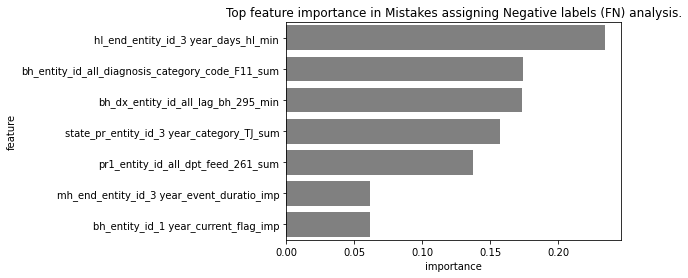


    Rules made with the top features associated with Mistakes assigning Negative labels (FN)
    


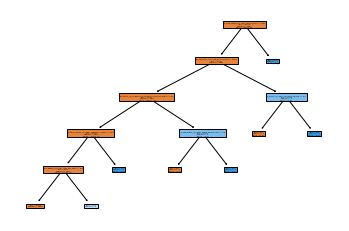

             ######            

        
    Model id: 7892
    Error analysis type: Mistakes assigning Positive labels (FP)
    Size of the list: 100
    Decision Tree with max_depth of, 5

    Top feature importance associated with error in label type Mistakes assigning Positive labels (FP)
    


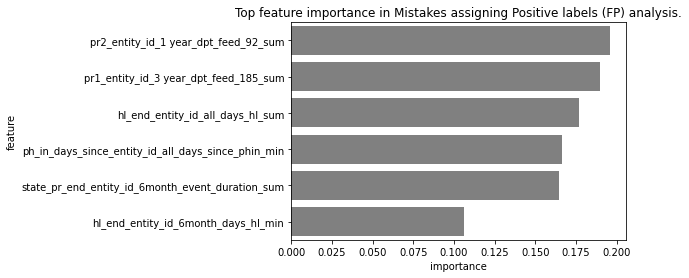


    Rules made with the top features associated with Mistakes assigning Positive labels (FP)
    


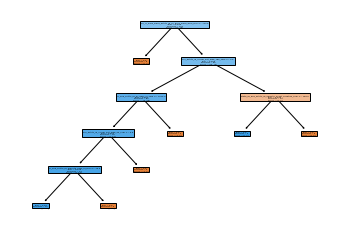

             ######            

        
    Model id: 7892
    Error analysis type: Mistakes assigning Positive and Negative (FP & FN)
    Size of the list: 100
    Decision Tree with max_depth of, 5

    Top feature importance associated with error in label type Mistakes assigning Positive and Negative (FP & FN)
    


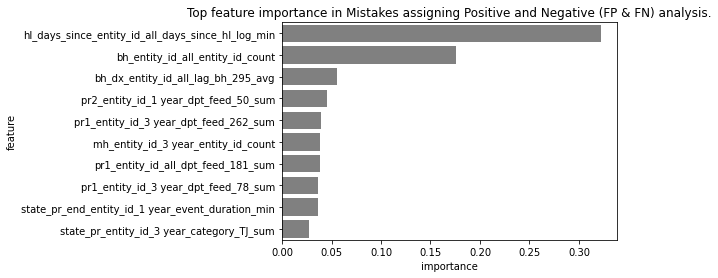


    Rules made with the top features associated with Mistakes assigning Positive and Negative (FP & FN)
    


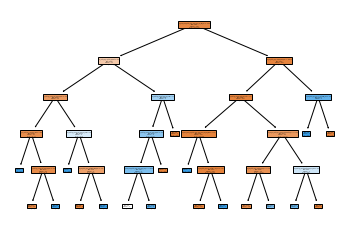

             ######            
*******************************************


In [9]:
# Only testing the the Random Forest model for 2022-08-01 (the last validation with sufficient data to observe labels)
rep.execute_error_analysis(model_ids=[7892])